<a href="https://colab.research.google.com/github/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Cryptocurrency%20price%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Problem</h1>
<p>
In the recent years, cryptocurrencies have been very popular. That's because their values change over time in a great extend. In this notebook we will try to solve this problem by using both historical data and social media activity in order to 
</p>
<ol>
  <li>Predict future prices, <b>Regression problem</b> </li>
  <li>Predict whether the price will increase or decrease, <b>Classification problem</b></li>
</ol>


<h1>Section 1<h1>
<h2> Data preprocessing </h2>
<p> The crypto with which we worked is Bitcoin. Bitcoin was created in January 2009.
Bitcoin offers the promise of lower transaction fees than traditional online payment mechanisms and, unlike government-issued currencies, it is operated by a decentralized authority.</p>
<p>There are many sources from where historical data can get found. For Bitcoin's historical data and the rest cryptocoins (Ethereum, Cardano) which we used, we started by using the yahoo's finance platform. However, because of the Coinmarket provides also the dailly market cap, we collected them also from there.</p>
<p>Regarding, social media activity data, their availabillity is limited accross the internet, at least for free. Cryptocompare and Lunarcrash apis used. Unfortunatelly, we didn't achieve to get data for the whole life of the coin by only for close to 3 years.</p>

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

<h3>Load data and plot them</h3>



Load data

In [2]:
btc_url = 'https://raw.githubusercontent.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/main/Datasets/Market%20info/BTC-USD.csv'
eth_url = 'https://raw.githubusercontent.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/main/Datasets/Market%20info/ETH-USD.csv'
ada_url = 'https://raw.githubusercontent.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/main/Datasets/Market%20info/ADA-USD.csv'

In [7]:
coin_market_info = pd.read_csv(btc_url)

In [8]:
# replace na cells, convert Date column to DateTime
coin_market_info['Date'] = pd.to_datetime(coin_market_info['Date'])
coin_market_info.fillna(method='ffill',inplace=True) 

<p>Yahoo dataset contains 7 columns
<ul>
<li>Date</li>
<li>Open, the open market price</li>
<li>High, the highest market price for this date</li>
<li>Low, the lowest market price for this date</li>
<li>Close, the close market price for this date</li>
<li>Adj Close, the close market price for this date after adjustments</li>
<li>Volume, physical number of cryptos traded</li>
</ul></p>
<p> Also, extra features added manually
<ul>
  <li>day_diff, the difference of Close with Open, divided by the Open price</li>
  <li>volatility, the difference of High with Low, divided by the Open price</li>
</ul>
</p>

In [9]:
extra_fields = {'day_diff': lambda x: (x['Close']-x['Open'])/x['Open'],
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
coin_market_info = coin_market_info.assign(**extra_fields)

<h4> Close price and Volume over time</h4>


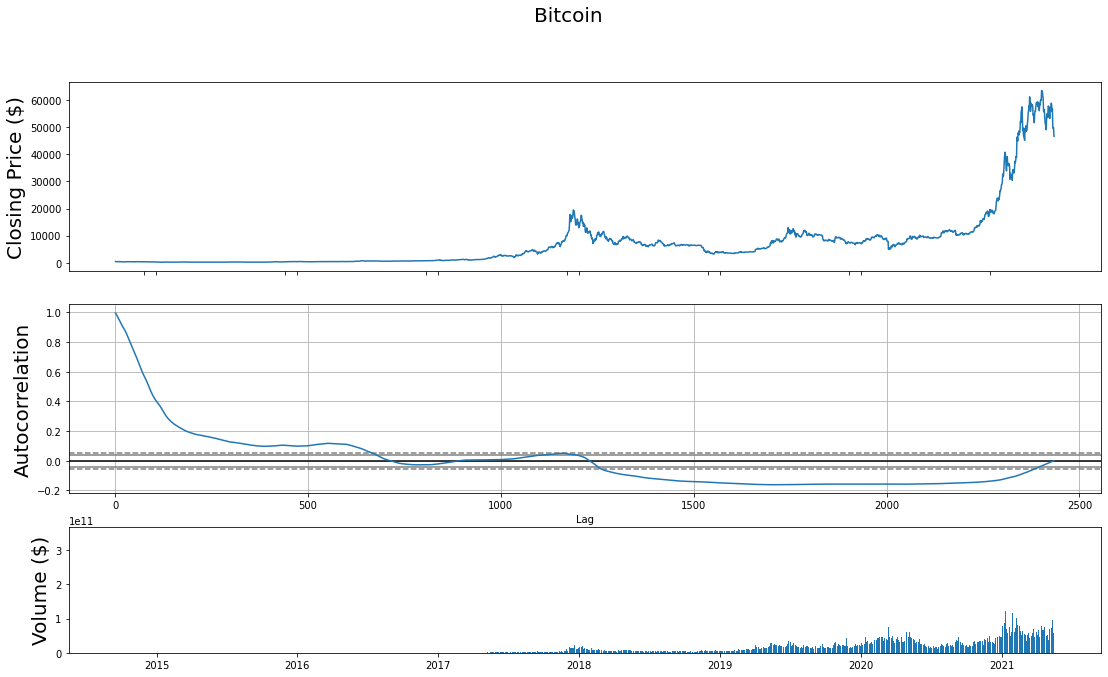

In [10]:
fig, (ax1, ax3, ax2) = plt.subplots(3,1, gridspec_kw = {'height_ratios':[3, 3, 2]})
ax1.set_ylabel('Closing Price ($)',fontsize=20)
ax2.set_ylabel('Volume ($)',fontsize=20)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,12]])
ax1.set_xticklabels('')
ax3.set_ylabel('Autocorrelation' ,fontsize=20)
ax1.plot(coin_market_info['Date'],coin_market_info['Open'])
ax2.bar(coin_market_info['Date'], coin_market_info['Volume'].values)
autocorrelation_plot(coin_market_info['Close'], ax=ax3)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Bitcoin', fontsize = 20)
plt.show()

<p> Regarding the correlation diagram, when the line is out of the grey bounds, then with 95% confidence level there is no significant correlation of Close value with Time, in the given fraction.</p>
<p>If so, it means that these values are randomly distributed or they depend on several other factors.</p>
<p> We will try by including more features apart from Close to increase the model's performance because it seems that the variation of the variable we are trying to predict follows a random distribution.</p>

<h3>Split data to training, testing and validation</h3>
<p> 80% of the dataset will be used to train the model.</p>
<p> The rest 20% percent will get divided in equal portition for the test and the validation.</p>

In [10]:
def split_dataset_to_train_and_validation(ds_to_split, percentage_of_train_from_all, percentage_of_validation_from_training):
    split_date = ds_to_split.iloc[round(ds_to_split.shape[0] * percentage_of_train_from_all)]['Date']
    training_set, val_test_set = ds_to_split[ds_to_split['Date'] < split_date], \
                            ds_to_split[ds_to_split['Date'] >= split_date]


    split_date_val = val_test_set.iloc[round(val_test_set.shape[0] * percentage_of_validation_from_training)]['Date']

    val_set, test_set = val_test_set[val_test_set['Date'] < split_date_val], \
                        val_test_set[val_test_set['Date'] >= split_date_val]

    return training_set, test_set, val_set, split_date, split_date_val

In [12]:
percent_train_set = 0.8
percent_val_set = 0.5

training_set, test_set, val_set, split_date, split_date_val = split_dataset_to_train_and_validation(coin_market_info, percent_train_set, percent_val_set)

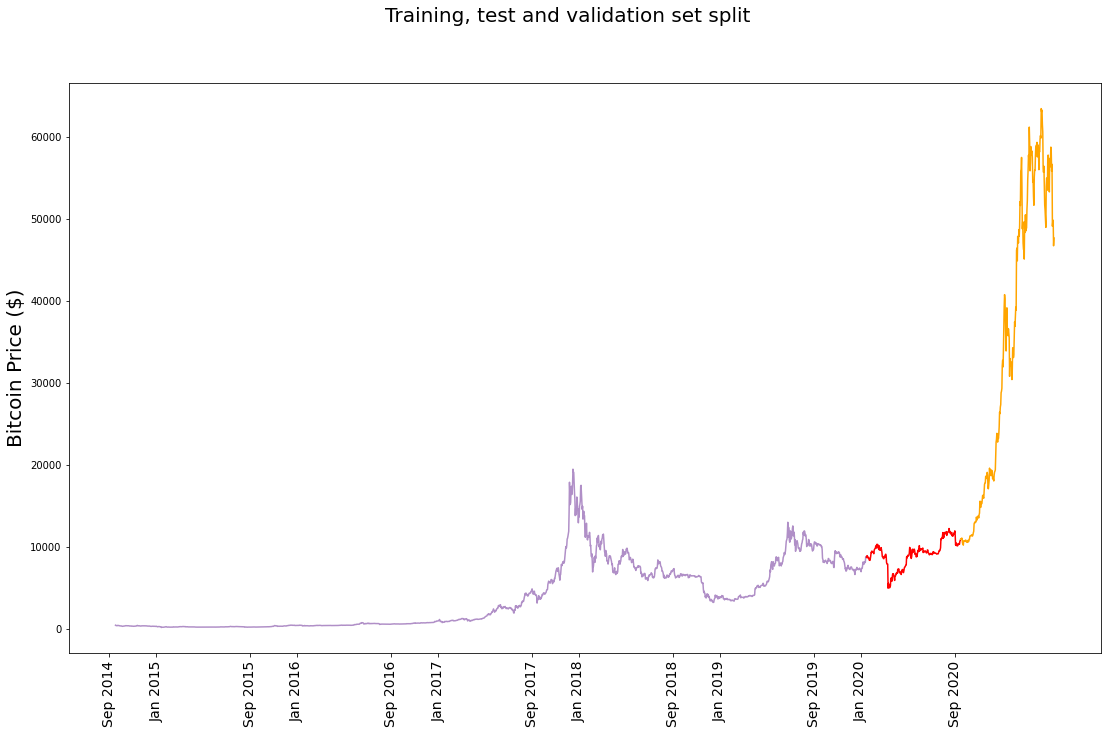

In [13]:
fig, (ax2) = plt.subplots(1,1)
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,9]])
ax2.plot(coin_market_info[coin_market_info['Date'] < split_date]['Date'],
         coin_market_info[coin_market_info['Date'] < split_date]['Close'], 
         color='#B08FC7')
ax2.plot(coin_market_info.loc[(coin_market_info['Date'] >= split_date) & (coin_market_info['Date'] < split_date_val)]['Date'],
         coin_market_info.loc[(coin_market_info['Date'] >= split_date) & (coin_market_info['Date'] < split_date_val)]['Close'], color='red')
ax2.plot(coin_market_info.loc[coin_market_info['Date'] >= split_date_val]['Date'],
         coin_market_info.loc[coin_market_info['Date'] >= split_date_val]['Close'], color='orange')
ax2.set_ylabel('Bitcoin Price ($)',fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.xticks(fontsize=14, rotation=90)
fig.suptitle('Training, test and validation set split', fontsize = 20)
plt.show()


<h3>Data normalization</h3>
<p>Data normalized on windows of X days. That's because even in the range of [0,1] the first years data wouldn't contribute the same as the data of the latests. This is an idea proposed in work [1]. Particularly, the authors of this work suggest to use a moving average or exponential smoothing, thus we utilized sliding windows to normalized the data in range of [-1,1].</p> 


In [14]:
window_len = 10

In [15]:
def normalize_data_in_windows(window_size, data):
  training_inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Date'], axis=1)
    temp_set = temp_set.drop(['Open'], axis=1)
    temp_set = temp_set.drop(['High'], axis=1)
    temp_set = temp_set.drop(['Low'], axis=1)
    temp_set = temp_set.drop(['Adj Close'], axis=1)

    for col in ['Close', 'Volume']:
        # inputs normalization
        temp_set[:][col] = temp_set[col] / temp_set[col].iloc[0] - 1

    training_inputs.append(temp_set)
  # outputs normalization
  training_outputs = (data['Close'][window_len:].values / data['Close'][:-window_len].values) - 1

  # convert to numpy
  training_inputs = [np.array(training_input) for training_input in training_inputs]
  training_inputs = np.array(training_inputs)
  return training_inputs, training_outputs

In [16]:
LSTM_training_inputs, LSTM_training_outputs = normalize_data_in_windows(window_len, training_set)
LSTM_test_inputs, LSTM_test_outputs = normalize_data_in_windows(window_len, test_set)
LSTM_val_inputs, LSTM_val_outputs = normalize_data_in_windows(window_len, val_set)

<h1>Section 2<h1>
<h2> Regression with historical data </h2>

<p> For the neural network implementation, the tensorflow library was used. </p>
<h3> Next, we define a sequencial model using LSTM cells.</h3>
<p> On our first attempt a simple LSTM architecture utilized with a single dense output layer. More specifically, the model architecture is an LSTM layer followed by a dropout, followed by a single dense and passed through an activation function before the predicted value return from the network.</p>
<p>A method has been made for the model creation. Number of neurons, activation function, dropout percentage, loss function and optimizer are variable values. For the presented case, we used 20 neurons, with *linear* activation function, 25% dropout percentage, Mean Absolute Error loss function and *Adam* optimizer.</p>

In [21]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf


def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [17]:
np.random.seed(202)
epochs = 20
batch_size = 64
neurons = 20

In [ ]:
bitcoin_model = build_model(LSTM_training_inputs, output_size=1, neurons=neurons)
hist = bitcoin_model.fit(LSTM_training_inputs, LSTM_training_outputs, validation_data=(LSTM_val_inputs, LSTM_val_outputs),
                        epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

<h3>Plot loss and validation set loss</h3>

In [98]:
def plot_loss_and_val_loss(hist, loss_label = 'Mean Absolute Error (MAE)', title=''):
  fig, ax1 = plt.subplots(1, 1)
  ax1.plot(hist.epoch, hist.history['loss'], color='b', label='Loss')
  ax1.plot(hist.epoch, hist.history['val_loss'], color='orange', label='Val_loss')
  ax1.set_xticks(range(0, len(hist.epoch)))
  ax1.set_title('Training Error ' + title )
  ax1.set_ylabel(loss_label, fontsize=12)
  ax1.set_xlabel('#Epoch', fontsize=12)
  fig.set_size_inches(18.5, 10.5)
  plt.legend()
  plt.show()

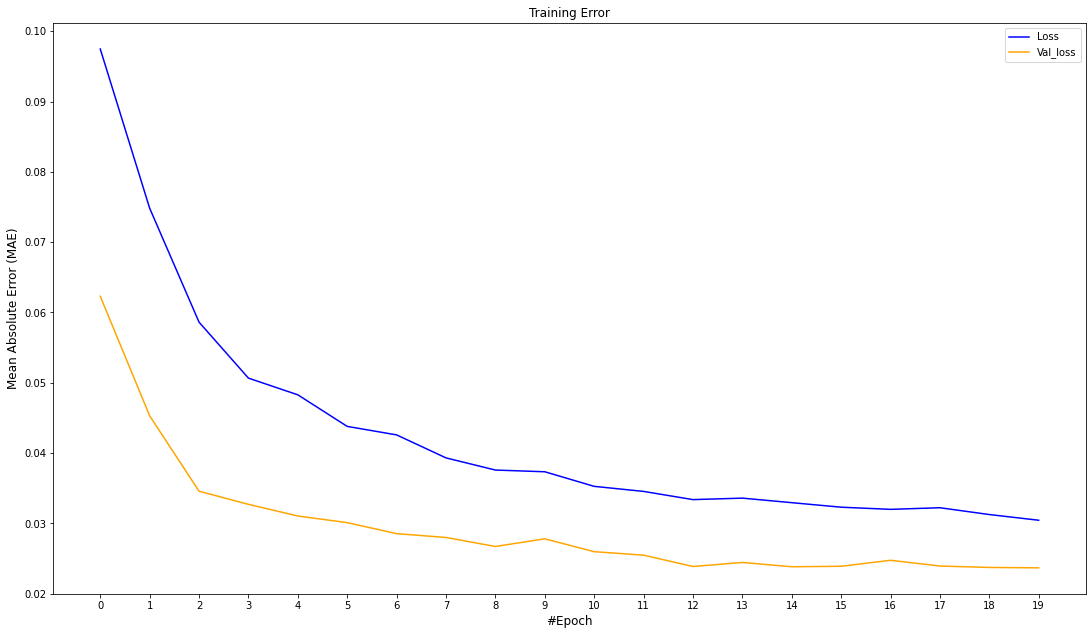

In [ ]:
plot_loss_and_val_loss(hist)

<p>We can observe that both losse's curves decrease together so seems like the model goes quite well in terms of generalization.</p>

<h3>Plot side by side prediction with actuals</h3>

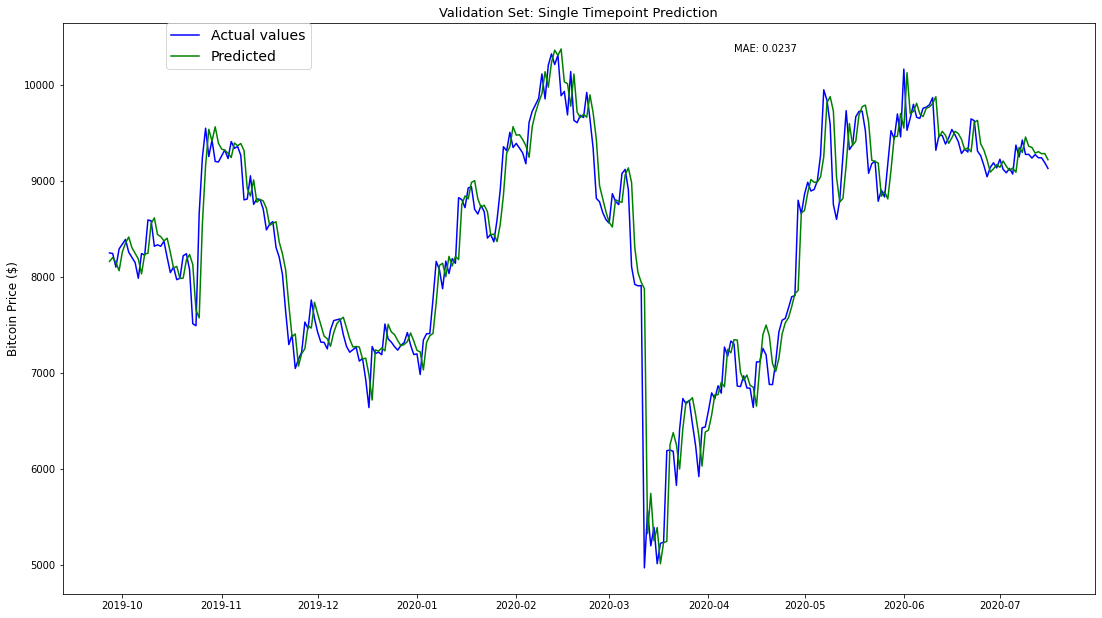

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
ax1.plot(pd.to_datetime(coin_market_info.loc[(coin_market_info['Date'] >= split_date) & (coin_market_info['Date'] < split_date_val)]['Date'][window_len:]),
         val_set['Close'][window_len:], label='Actual values', color='b')
ax1.plot(pd.to_datetime(coin_market_info.loc[(coin_market_info['Date'] >= split_date) & (coin_market_info['Date'] < split_date_val)]['Date'][window_len:]),
         ((np.transpose(bitcoin_model.predict(LSTM_val_inputs)) + 1) * val_set['Close'].values[:-window_len])[0],
         label='Predicted', color='g')
ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f' % np.mean(np.abs((np.transpose(bitcoin_model.predict(LSTM_val_inputs)) + 1) - \
                                          (val_set['Close'].values[window_len:]) / (val_set['Close'].values[:-window_len]))),
             xy=(0.65, 0.95), xycoords='axes fraction',
             xytext=(0.65, 0.95), textcoords='axes fraction')
ax1.set_title('Validation Set: Single Timepoint Prediction', fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
fig.set_size_inches(18.5, 10.5)
plt.show()

<p>From the previous diagram we can easily infer that the model learns to predict as close value equal to previous day's close value and that's because the differ between these two values is not as high in order to cause big increase of the loss function. For this reason the two diagrams are almost identical, with the prediction shifted to the right.</p>
<p>For this reason and in order to make the network's prediction harder, we increased complexity to 5 days prediction. By doing that we focus more to price increase/decrease prediction rather than the actual price.</p>
<p>In order this to be done, we have to configure the output sets</p>

In [19]:
pred_range = 5

LSTM_ranged_training_outputs = []
for i in range(window_len, len(training_set['Close']) - pred_range):
    LSTM_ranged_training_outputs.append((training_set['Close'][i:i+pred_range].values/training_set['Close'][training_set.index[0]+i-window_len]) - 1)

LSTM_ranged_training_outputs = np.array(LSTM_ranged_training_outputs)


LSTM_ranged_val_outputs = []
for i in range(window_len, len(val_set['Close']) - pred_range):
    LSTM_ranged_val_outputs.append((val_set['Close'][i:i+pred_range].values/val_set['Close'][val_set.index[0]+i-window_len]) - 1)

LSTM_ranged_val_outputs = np.array(LSTM_ranged_val_outputs)

<p> Create new model with different output size, as we now expect 5 outputs instead of 1. </p>

In [22]:
ranged_bitcoin_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons=neurons)

In [23]:
hist = ranged_bitcoin_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, validation_data=(LSTM_val_inputs[:-pred_range], LSTM_ranged_val_outputs), epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True, workers=8)

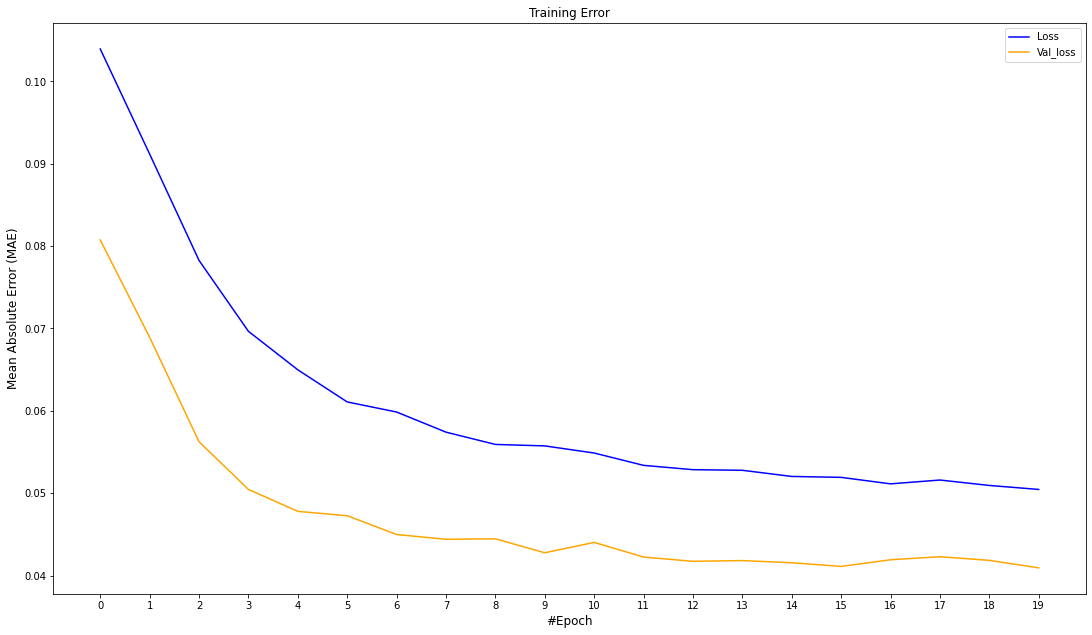

In [ ]:
plot_loss_and_val_loss(hist)

<p>As we can see, neither the loss nor the validation loss dicrease. This means that the model is still underfit. For this reason we will increase the number of epochs and we will try again.</p>

In [24]:
epochs = 100
hist = ranged_bitcoin_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, validation_data=(LSTM_val_inputs[:-pred_range], LSTM_ranged_val_outputs), epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True, workers=8)

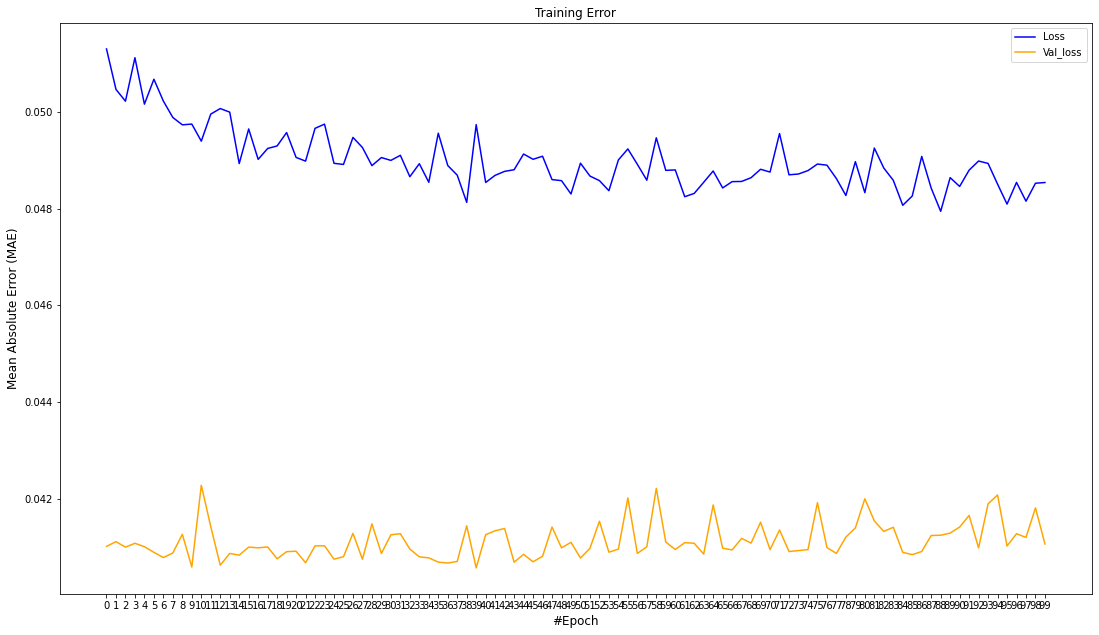

In [ ]:
plot_loss_and_val_loss(hist)

<p>As we can still see, the model continues to not performs as expected. Validation loss increases while the loss decreases. This means that the model tends to overfit. We will try again by increasing the number of neurons.</p>

In [26]:
neurons = 100
ranged_bitcoin_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons=neurons)

In [27]:
hist = ranged_bitcoin_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, validation_data=(LSTM_val_inputs[:-pred_range], LSTM_ranged_val_outputs), epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True, workers=8)

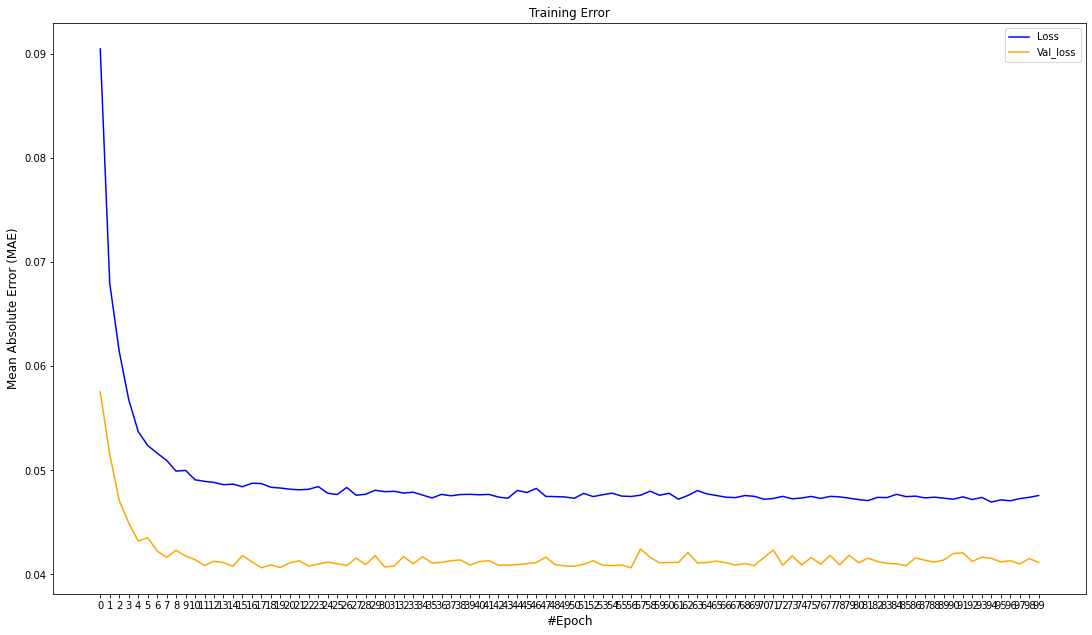

In [ ]:
plot_loss_and_val_loss(hist)

<p>The results seems to be quite better than before. Both losses decreases together. </p>

<h3>Plot side by side prediction with actuals</h3>

In [28]:
def plot_actual_against_ranged_prediction(ds, m, p_range, w_length, lstm_val_input, val_inp, s_date, s_date_val, predicted_column, figure_title = ''):
  #Get predictions which are scaled
  scaled_pred_prices = (m.predict(lstm_val_input)[:-p_range][::p_range])

  #Apply inverse tranformation to get unscaled predictions
  pred_prices = (scaled_pred_prices + 1) *\
                val_inp[predicted_column].values[:-(w_length + p_range)][::p_range].reshape(int(np.ceil((len(lstm_val_input) -
                                                                                              p_range)/float(p_range))), 1)

  #Reshape scaled predictions in order to use them in computing MAE of normalized data
  scaled_pred_prices = ((m.predict(lstm_val_input)[:-p_range][::p_range]).copy()).reshape(-1)
  pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F", "#A569BD", "#45B39D"]
  fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
  ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:]),
         val_inp[predicted_column][w_length:], label='Actual values', color='b')

  for i, pred in enumerate(pred_prices):

      if i < p_range: #Print label=predicted for the first time

          ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                  pred, color=pred_colors[i % p_range], label='Predicted')

      else: #Dont print label=predicted again

          ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[
                  (i * p_range):((i * p_range) + p_range)],
                  pred, color=pred_colors[i % p_range])

  ax1.set_title('Validation Set: 5 Timepoint Predictions', fontsize=13)
  ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
  ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
  ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})
  fig.suptitle(figure_title, fontsize=20)
  fig.set_size_inches(18.5, 10.5)
  plt.show()

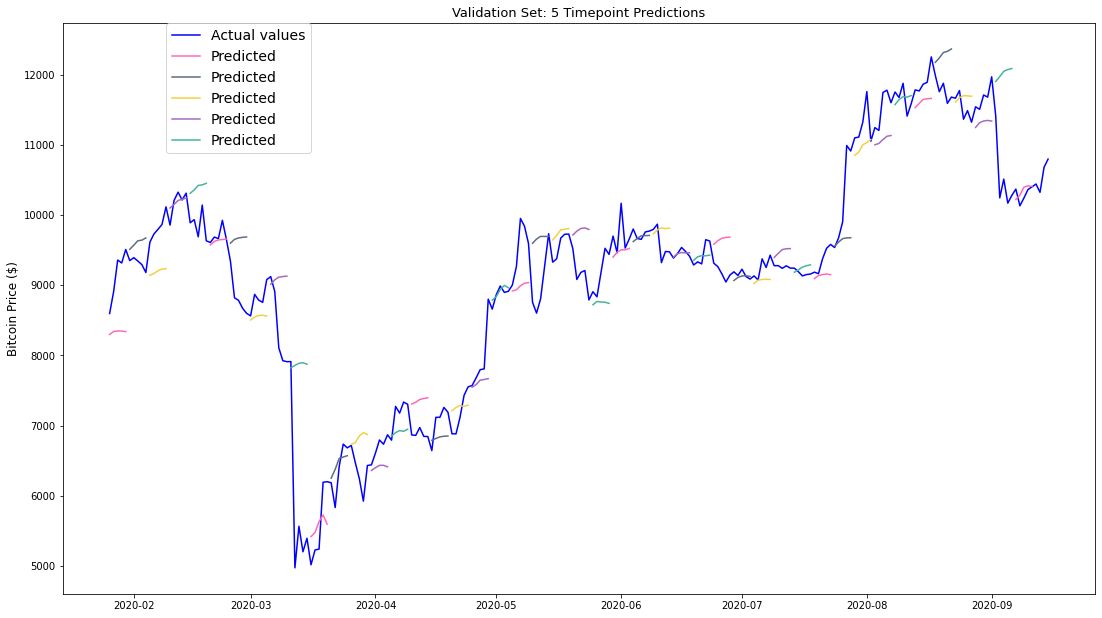

In [29]:
plot_actual_against_ranged_prediction(coin_market_info, ranged_bitcoin_model, pred_range, window_len, LSTM_val_inputs, val_set, split_date, split_date_val, 'Close')

<p> We can easily understand now, using the diagram that even if the model seems to start to perform well on the problem, the predictions are not as accured as expected.</p>
<p> Moving forward, we will try multiple different architectures and configurations of networks. In addition we will hypertune them in order to get the best results from each of them.</p>
<p> More specifically, we will perform several experiments with different combinations of features - datasets, multiple batch sizes, different number of neurons, architectures of LSTM, etc.</p>

<h1>Section 3<h1>
<h2> Model hypertuning for regression problem </h2>

<p> We will continue with the model hypertuning. First of all, a method will be defined which will produce a main dataset which will include multiple cryptocoins market info and also some extra features will be added apart from the previous, like:
<ul>
  <li>previous 7 days mean close value</li>
  <li>previous 30 days mean close value</li>
  <li>previous 7 days standard daviation of close value</li>
  <li>previous 30 days standard daviation of close value</li>
</ul>

In [30]:
pip install keras-tuner

     |████████████████████████████████| 102kB 6.5MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=47bd343282760e39b0995efc5c7c9bf988faaf8f1b35bfd49cae68cfa6ba75e6
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


Let's create a function which will automatically create the whole dataset with all the features.

In [3]:
def dataset_creation(crypto_list):
    datasets = {} #Store all datasets here
    min_dates = {} #Store all minimum dates here
    max_dates = {} #Store all maximum dates here
    datasets_list = {'BTC' : btc_url, 'ETH' : eth_url, 'ADA' : ada_url}
    
    for dataset_name, dataset_url in datasets_list.items():
        if (dataset_name) in crypto_list:
            datasets[dataset_name] = pd.read_csv(dataset_url)
            datasets[dataset_name]['Date'] = pd.to_datetime(datasets[dataset_name]['Date']) 
            datasets[dataset_name].rename(columns={'Adj Close':dataset_name+'Adj_Close'})
            #There are a few missing values, so let fill them with the previous value
            datasets[dataset_name].fillna(method='ffill', inplace=True)
            #Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:
            kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
              'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])
              }
            datasets[dataset_name] = datasets[dataset_name].assign(**kwards)
            datasets[dataset_name].fillna(-1, inplace=True) #Fill possible NaN close_off_high values with -1
                                                            #Because NaN values caused by (0/0)-1

            first_date = pd.to_datetime(datasets[dataset_name]['Date'][0])
            min_dates[dataset_name]=first_date
            last_date = pd.to_datetime(datasets[dataset_name]['Date'].iloc[-1])
            max_dates[dataset_name] = last_date
            

    max_date = max(min_dates.values(), key=lambda v: v)
    min_date = min(max_dates.values(), key=lambda v: v)

    #Drop all the data which are prior to max_date and later to min_date
    for dataset in datasets:
        datasets[dataset] = datasets[dataset][(datasets[dataset]['Date'] >= max_date) & 
                                              (datasets[dataset]['Date'] <= min_date)]

    #Compute the average and standard deviation of 'Close' value for the last 7-days and 30-days(month): 
    for dataset in datasets:
        temp = datasets[dataset].copy()
        #Drop the first 30 days to be able to compute average and standard deviation of month for the rows of the table
        temp = temp[29:]
        temp['mean_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).mean()
        temp['mean_month_Close'] = datasets[dataset]['Close'].rolling(window=30).mean()
        temp['std_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).std()
        temp['std_month_Close'] = datasets[dataset]['Close'].rolling(window=30).std()
        datasets[dataset] = temp.copy()

    #Rename the columns and concatenate the all datasets to one 
    count = 0
    for dataset in datasets:
        datasets[dataset] = datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        datasets[dataset] = datasets[dataset].rename(columns={dataset+'_Date': 'Date'})                                                          
        if count == 0:
            date_col = (datasets[dataset]['Date'].reset_index()).drop(['index'], axis=1)
        datasets[dataset] = ((datasets[dataset].drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1)              
    whole_dataset = pd.concat([datasets[dataset] for dataset in datasets], axis=1)
    whole_dataset = pd.concat([date_col, whole_dataset], axis=1)
   
    return whole_dataset

The same should be done for the normalization of inputs and outputs:

In [57]:
def normalize_in_out(prd_range, wind_len, tr_set, val_set, tst_set, feats, coin_targ, crypto_list):
    
    all_feats = tr_set.columns #Get all features
    feats = [crypto+"_"+feat for crypto in crypto_list for feat in feats] #Get the features in the appropriate format 
                                                                          #(e.g 'Close' --> 'BTC-USD_Close')
    
    #Normalize training inputs
    LSTM_tr_in = []
    for i in range(len(tr_set) - wind_len):
        tmp_set = tr_set[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used

        LSTM_tr_in.append(tmp_set)
    
    #Transform from DataFrame to numpy array
    LSTM_tr_in = [np.array(LSTM_tr_i) for LSTM_tr_i in LSTM_tr_in]
    LSTM_tr_in = np.array(LSTM_tr_in)
    
    
    #Normalize validation inputs
    LSTM_val_in = []
    for i in range(len(val_set) - wind_len):
        tmp_set = val_set[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used
    
        LSTM_val_in.append(tmp_set)
        
    #Transform from DataFrame to numpy array
    LSTM_val_in = [np.array(LSTM_val_i) for LSTM_val_i in LSTM_val_in]
    LSTM_val_in = np.array(LSTM_val_in)
    
    
    #Normalize test inputs
    LSTM_test_in = []
    for i in range(len(tst_set) - wind_len):
        tmp_set = tst_set[i:(i + wind_len)].copy() 
        
        for col in all_feats:
            if col not in feats:
                
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used

        LSTM_test_in.append(tmp_set)
    
    
    #Transform from DataFrame to numpy array
    LSTM_test_in = [np.array(LSTM_test_i) for LSTM_test_i in LSTM_test_in]
    LSTM_test_in = np.array(LSTM_test_in)
    
    
    #Normalize training outputs
    LSTM_rangd_train_out = []
    for i in range(wind_len, len(tr_set[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_train_out.append((tr_set[coin_targ+'_Close'][i:i+prd_range].values/tr_set[coin_targ+'_Close'][tr_set.index[0]+i-wind_len]) - 1)

    LSTM_rangd_train_out = np.array(LSTM_rangd_train_out)
    
    
    #Normalize validation outputs
    LSTM_rangd_val_out = []
    for i in range(wind_len, len(val_set[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_val_out.append((val_set[coin_targ+'_Close'][i:i+prd_range].values/val_set[coin_targ+'_Close'][val_set.index[0]+i-wind_len]) - 1)
    
    LSTM_rangd_val_out = np.array(LSTM_rangd_val_out)

    #Normalize test outputs
    LSTM_rangd_tst_out = []
    for i in range(wind_len, len(tst_set[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_tst_out.append((tst_set[coin_targ+'_Close'][i:i+prd_range].values/tst_set[coin_targ+'_Close'][tst_set.index[0]+i-wind_len]) - 1)

    LSTM_rangd_tst_out = np.array(LSTM_rangd_tst_out)
    
    return LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_tr_in, LSTM_val_in, LSTM_test_in, LSTM_rangd_tst_out

<p>Apart from this, a method about model tuning made. This method uses the tensorflow's Hyperband algorithm. The model architecture we ended up after the experiments we did is the follow:</p>
<ul>
  <li>LSTM</li>
  <li>Dropout layer after LSTM</li>
  <li>Dense</li>
  <li>Dense</li>
  <li>Dense</li>
  <li>Activation</li>
</ul>
<p>
We concluded to this architecture after many tries.
We also try to add a 1D CNN layer before LSTM as a high level feature extractor by combining the inputs features. This is also a tecnique described in [1]. As a further regularization method, we tried out some Batch Normalization layers, but without achieving greater model efficiency.
Check the commented out Layers for the different combinations we tried.
</p>

In [34]:
########Model with CNN layers, followed by LSTM layers, followed by Dense layers #####################
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import tensorflow as tf


def model_tuning(inputs, outputs, output_size, validation_inputs, validation_outputs, epochs, early_stop_patience, 
                 neurons, dropout, prd_range, batch_size, keras_tuner_dir, activ_func="linear", loss="mae", 
                 optimizer="adam"):
    
    def build_model(hp):
        model = Sequential()
        
        
        ###########1D CONV############
        #filters_conv1 = hp.Choice('filters_Conv1', values=[16, 32, 64])
        #kernel_size_conv1 = hp.Choice('kernel_size_Conv1', values=[2, 3, 5])
        #strides_conv1 = hp.Choice('strides_Conv1', values=[1, 2, 3])
        #model.add(Conv1D(filters=filters_conv1, kernel_size=kernel_size_conv1, strides=strides_conv1, 
        #                 activation='relu',
        #                input_shape=(inputs.shape[1], inputs.shape[2])))
        
        #moment_batchNormConv1 = hp.Float('momentum_batchNormConv1', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormConv1))
        
        
        ######1D POOL########
        #pool_size_maxPool1 = hp.Choice('pool_size_MaxPool1', values=[2, 3, 4])
        #model.add(MaxPool1D(pool_size=2))
        #model.add(AveragePooling1D(pool_size=2))
        
        neurLSTM1 = hp.Choice('neurons_1_LSTM', values=neurons)
        model.add(LSTM(neurLSTM1, input_shape=(inputs.shape[1], inputs.shape[2]))) #return_sequences=True

        dropLSTM1 = hp.Choice('dropout_LSTM_1', values=dropout)
        model.add(Dropout(dropLSTM1))
        
        #neurLSTM2 = hp.Choice('neurons_2_LSTM', values=neurons)
        #model.add(LSTM(neurLSTM2))
        
        #dropLSTM2 = hp.Choice('dropout_LSTM_2', values=dropout)
        #model.add(Dropout(dropLSTM2))
        
        #moment_batchNormLSTM2 = hp.Float('momentum_batchNormLSTM2', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormLSTM2))

        neurD1 = hp.Choice('neurons_1_Dense', values=[32, 64, 128, 256])
        model.add(Dense(units=neurD1, activation='relu'))
        
        #dropDense1 = hp.Choice('dropout_Dense_1', values=dropout)
        #model.add(Dropout(dropDense1))
        
        #moment_batchNormDense1 = hp.Float('momentum_batchNormDense1', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormDense1))
        
        neurD2 = hp.Choice('neurons_2_Dense', values=[32, 64, 128, 256])
        model.add(Dense(units=neurD2, activation='relu'))
        
        #dropDense2 = hp.Choice('dropout_Dense_2', values=dropout)
        #model.add(Dropout(dropDense2))
        
        #moment_batchNormDense2 = hp.Float('momentum_batchNormDense2', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormDense2))
        
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))
        
        hp_learning_rate = hp.Float(name='learning_rate', min_value=0.0001, max_value=0.05, step=0.0005)
        
        hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)
        
        hp_beta_2 = hp.Float('beta_2', min_value=0.98, max_value=0.999, step=0.001)
        
        hp_epsilon = hp.Float('epsilon', min_value=1e-08, max_value=1e-07, sampling='LOG')
        
        optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2, epsilon=hp_epsilon)
        
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
        return model
    
    
    
    #Create_tuner
    tuner = kt.Hyperband(build_model,
                 objective='val_loss',
                 max_epochs=epochs,
                 factor=3,
                 directory=keras_tuner_dir,
                 project_name='keras_tuner')

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience)

    tuner.search(inputs[:-prd_range], outputs, 
                 validation_data=(validation_inputs[:-prd_range], validation_outputs), 
                 epochs=epochs, batch_size=batch_size,callbacks=[stop_early],
                 use_multiprocessing=True,
                 workers=8)

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]

    
    return best_hps, tuner



In [35]:
def build_and_train_model(epchs, btch_size, neurs, dropout, prd_range, LSTM_train_in, LSTM_rangd_train_out, LSTM_valid_in, LSTM_rangd_valid_out, shffl, verb, early_st_pat):#, tbd_ck):

    rnged_btcoin_model = build_model(LSTM_train_in, output_size=prd_range, neurons=neurs, dropout=dropout)
    
    np.random.seed(202)
    
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_st_pat)]#, tbd_ck] #Uncomment to 
                                                                                                        #enable tensorboard

    rnged_hist = rnged_btcoin_model.fit(LSTM_train_in[:-prd_range], LSTM_rangd_train_out,
                                      validation_data=(LSTM_valid_in[:-prd_range], LSTM_rangd_valid_out), 
                                        epochs=epchs, batch_size=btch_size, verbose=verb,  callbacks=callbacks, 
                                        shuffle=shffl)
    
    return rnged_btcoin_model, rnged_hist

<p>Above is presented a function that generates 2 dataset, one with only BTC and a composition of BTC, ETH. After the creation of the dataset, a list with different combination of features sets is defined, using those which we tested against all possible models parameters in order to fine the best tuple in terms of performance.
We suggest not to run the following cell as it can take up too 8 hours to finish. </p>

In [37]:
crypto_list = [['BTC'], ['BTC', 'ETH']]

#**!!!!!!!!!!!!!!!!!!! Warning, dont run this cell !!!!!!!!!!!!!!!!!!**





In [37]:
# Try to tune only using BTC dataset, and using BTC and ETH combination.
first_txt_flag = 0
for cryptocurrency_list in crypto_list:
    cryptocurrency_list_output = 'Using cryptocurrencies: '+str(cryptocurrency_list)
    print(cryptocurrency_list_output)
    data = dataset_creation(cryptocurrency_list)
    #Split data
    percent_train_set = 0.8
    percent_val_set = 0.5
    
    training_set, test_set, validation_set, _, _ = split_dataset_to_train_and_validation(data, percent_train_set, percent_val_set)
    
    features_list = [['Close', 'Open', 'High']]
    """[['Close'], ['Close', 'Volume'], ['Close', 'Open', 'High'],
                     ['Close', 'close_off_high', 'volatility'],
                     ['Close', 'mean_7days_Close', 'mean_month_Close'],
                     ['Close', 'std_7days_Close', 'std_month_Close']]""" #Define the sets of features to be tested 
    
    for featurs in features_list: 
        
        new_txt_flag = 0 
        
        featurs_output = '\tUsing the features: '+str(featurs)
        print('\tUsing the features: '+str(featurs))
        
        
        #Create inputs and outputs for the model training, validation and testing
        pred_range = 5
        window_len = 10
        features = featurs
        coin_target = 'BTC'

        LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs, _ = normalize_in_out(
                                                                                                      pred_range, window_len, 
                                                                                                      training_set, 
                                                                                                      validation_set, 
                                                                                                      test_set, 
                                                                                                      features, coin_target,
                                                                                                      cryptocurrency_list)

        batch_size_list = [64] #[1, 32, 64]
        neuron_list = [20, 40, 60, 100]
        dropout_list = [0.0, 0.1, 0.2, 0.25, 0.3, 0.4]
        early_stop_patience = 10
        epochs = 500
        shuffle = True
        verbose = 0
        
        for bat_s in batch_size_list:

            #Build and train model
            batch_size = bat_s
            
            
            exper_params_output = '\t\tBatch_size: '+str(batch_size)
            print(exper_params_output)
           
            
            #Path to write log files
            cur_path = os.getcwd()+'/'
            log_dir = cur_path + "logs/fit/" + str(cryptocurrency_list) + '/' + str(featurs) + '/' + 'Batch_size='+str(batch_size)
            if not os.path.exists(log_dir):
                os.makedirs(log_dir)
            
            #Path to save its checkpoints the keras_tuner because it raises an error when it is in the current working
            #directory or in a sub-folder
            keras_tuner_dir = 'keras_tuner_dir'
            if not os.path.exists(keras_tuner_dir):
                os.makedirs(keras_tuner_dir)
            
            best_hps, tuner = model_tuning(inputs=LSTM_training_inputs, outputs=LSTM_ranged_training_outputs,
                                output_size=pred_range, 
                                validation_inputs = LSTM_validation_inputs, 
                                validation_outputs = LSTM_ranged_validation_outputs,
                                epochs=epochs, early_stop_patience=early_stop_patience, neurons=neuron_list, 
                                dropout=dropout_list, prd_range=pred_range, batch_size=bat_s, 
                                           keras_tuner_dir=keras_tuner_dir)
        
            exper_outputs = "\t\tThe hyperparameter search is complete. The optimal parameter were found to be: \n" + \
                            str(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)
        
            
            
            # Build the model with the optimal hyperparameters and train it
            best_model = tuner.hypermodel.build(best_hps)
            mod_history = best_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, 
                                         validation_data=(LSTM_validation_inputs[:-pred_range], 
                                                          LSTM_ranged_validation_outputs), 
                                         epochs=epochs)
            
            #Get the epoch with the best validation loss
            val_loss_per_epoch = mod_history.history['val_loss']
            best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
            exper_outputs += '\n\n\t\tBest epoch: '+ str(best_epoch) + ' with validation loss: ' + str((min(val_loss_per_epoch)))
            
            #Print results to a .txt file
            if first_txt_flag == 0:
                
                if new_txt_flag == 0:
                    
                    #Create a .txt file and write the results
                    txt_log_dir = "logs/fit/" + str(cryptocurrency_list) + '/' + str(featurs) + '/'
                    f = open(txt_log_dir+"/"+coin_target+"_results.txt", "w")
                    f.write(cryptocurrency_list_output)
                    f.write("\n"+featurs_output)
                    
                    first_txt_flag += 1
                    new_txt_flag += 1
            else:
                
                if new_txt_flag == 0:
                    
                    f.close() #Close previous txt file
                    
                    #Create a .txt file and write the results
                    txt_log_dir = "logs/fit/" + str(cryptocurrency_list) + '/' + str(featurs) + '/'
                    f = open(txt_log_dir+"/"+coin_target+"_results.txt", "w")
                    f.write(cryptocurrency_list_output)
                    f.write("\n"+featurs_output)
                    
                    new_txt_flag += 1
                    
                
            
            f.write("\n"+exper_params_output)
            f.write("\n"+exper_outputs)
            
            f.write("\n\nFull keras tuner results: \n")
            with redirect_stdout(f): 
                tuner.results_summary()
            
            
            create_plot(mod_history, log_dir, coin_target)

f.close()


#Write best model summary to a txt file
with open(cur_path + 'logs/fit/modelsummary.txt', 'w') as f_sum:
    with redirect_stdout(f_sum):
        best_model.summary()
        

#Remove folder with is created by keras tuner
shutil.rmtree(keras_tuner_dir)

<p>The results of model and dataset tuning are
</p>
<ul>
  <li>Combination of different coins, helps in performance increase (in terms of better MAE results). This means that the information of different cryptocoins provides a positive impact and useful knowledge about their combinatorial movements, thus there are dependencies among them.</li>
  <li>Batch of 64 size.</li>
  <li>100 units in LSTM.</li>
  <li>Using feature sets ['Close', 'Open', 'High'] or ['Close', 'Volume'] we get the best results.</li>
</ul>
<p> Bellow, we will present the results using the best model architecture - parameters using also the early stopping functionality against validation loss in order to reduce the possibility of overfitting.</p>
<p> Additionally, we will present the results of a dataset of BTC best feature set market info against BTC and ETH combination. </p>


In [58]:
def get_specific_features_normalized(ds, f, crypt_list=['BTC']):
    percent_train_set = 0.8
    percent_val_set = 0.5
    training_set, test_set, validation_set, split_date, split_date_val = split_dataset_to_train_and_validation(ds, percent_train_set, percent_val_set)
    pred_range = 5
    window_len = 10
    coin_target = 'BTC'
    LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs, LSTM_ranged_test_outputs = normalize_in_out(pred_range, window_len, training_set, validation_set, test_set, f, coin_target, crypt_list)
    return LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_ranged_test_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs, split_date, split_date_val, validation_set

In [39]:
def build_model_with_best_architecture(inputs):
    model = Sequential()
    model.add(LSTM(100, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(0.3))
    model.add(Dense(32))
    model.add(Dense(64))
    model.add(Dense(units=pred_range))
    model.add(Activation("linear"))
    model.compile(loss="mae", optimizer="adam")
    return model

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

<h4> Best model architecture: </h4>

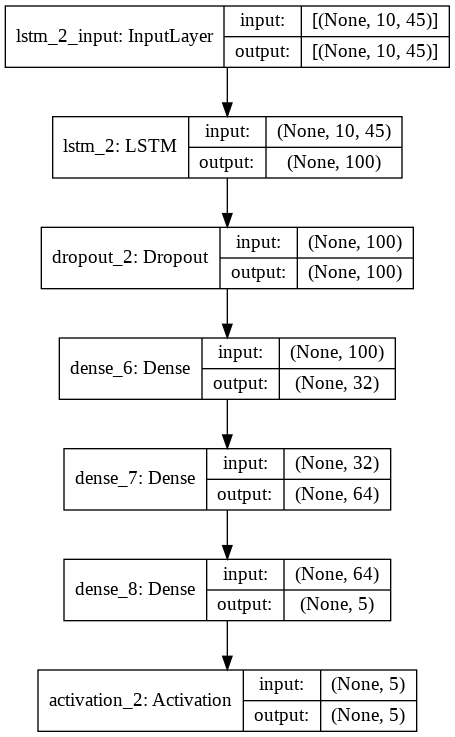

In [ ]:
tf.keras.utils.plot_model(best_model_BTC, show_shapes=True)

Create a dataset with only BTC data and train a model.

In [59]:
btc_dataset_with_3_features = dataset_creation(['BTC'])
LSTM_ranged_training_outputs_BTC, LSTM_ranged_validation_outputs_BTC, LSTM_ranged_test_outputs_BTC, LSTM_training_inputs_BTC, LSTM_validation_inputs_BTC, LSTM_test_inputs_BTC, split_date_BTC, split_date_val_BTC, validation_set_original_BTC = get_specific_features_normalized(btc_dataset_with_3_features, ['Close', 'Open', 'High'],['BTC'])
best_model_BTC = build_model_with_best_architecture(LSTM_training_inputs_BTC)
hist_of_BTC_with_best_model = best_model_BTC.fit(LSTM_training_inputs_BTC[:-pred_range], LSTM_ranged_training_outputs_BTC, validation_data=(LSTM_validation_inputs_BTC[:-pred_range], LSTM_ranged_validation_outputs_BTC), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

In the same way, create a dataset with both BTC and ETH data.

In [76]:
btc_eth_dataset_with_3_features = dataset_creation(['BTC', 'ETH'])
LSTM_ranged_training_outputs_BTC_ETH, LSTM_ranged_validation_outputs_BTC_ETH, LSTM_ranged_test_outputs_BTC_ETH, LSTM_training_inputs_BTC_ETH, LSTM_validation_inputs_BTC_ETH, LSTM_test_inputs_BTC_ETH, split_date_BTC_ETH, split_date_val_BTC_ETH, validation_set_original_BTC_ETH = get_specific_features_normalized(btc_eth_dataset_with_3_features, ['Close', 'Open', 'High'], ['BTC', 'ETH'])
best_model_BTC_ETH = build_model_with_best_architecture(LSTM_training_inputs_BTC_ETH)
hist_of_BTC_ETH_with_best_model = best_model_BTC_ETH.fit(LSTM_training_inputs_BTC_ETH[:-pred_range], LSTM_ranged_training_outputs_BTC_ETH, validation_data=(LSTM_validation_inputs_BTC_ETH[:-pred_range], LSTM_ranged_validation_outputs_BTC_ETH), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

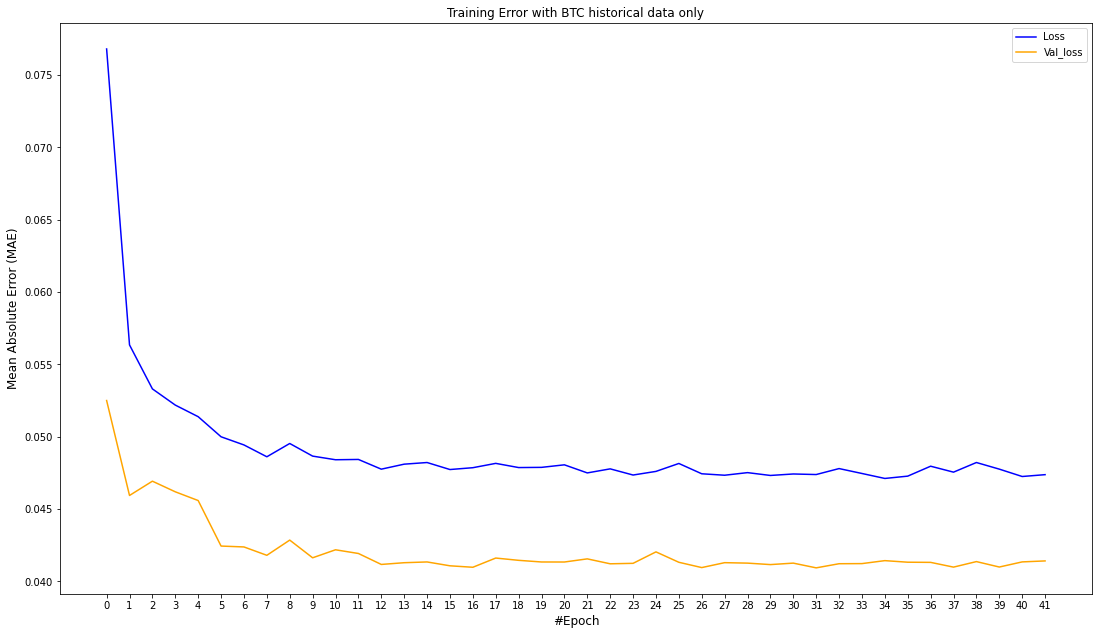

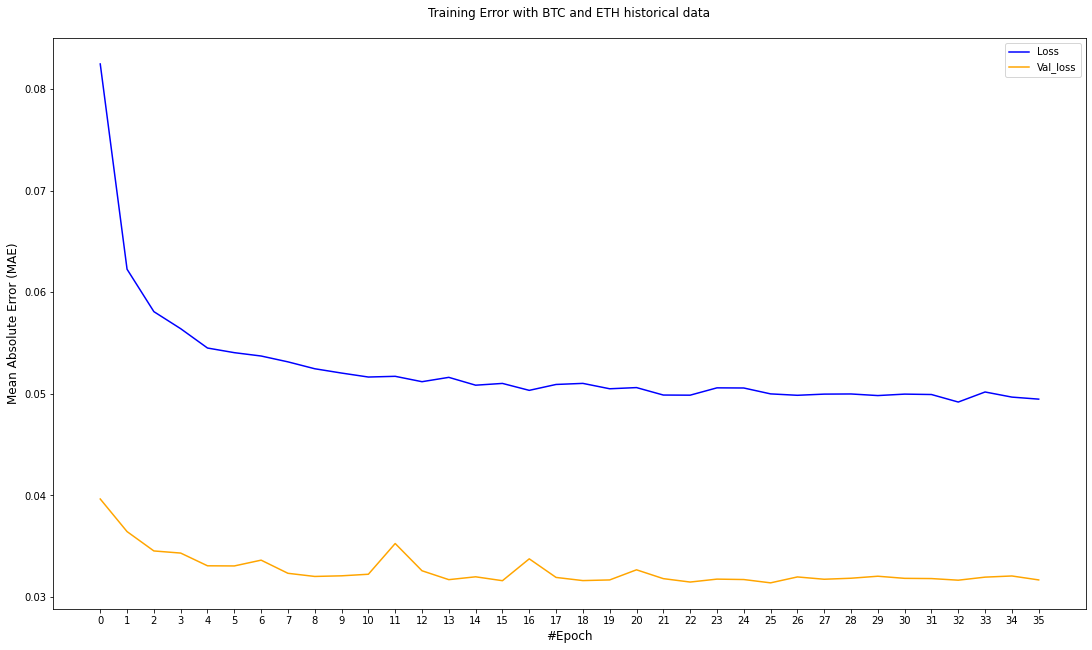

In [54]:
plot_loss_and_val_loss(hist_of_BTC_with_best_model, title='with BTC historical data only')
print('\n\n')
plot_loss_and_val_loss(hist_of_BTC_ETH_with_best_model, title='with BTC and ETH historical data\n')

<p> It worths to mention, that even if the losses of the training set (for the two different plots above) are almost the same, the dataset with the two coins exhibits a better performance in terms of validation loss, because it reaches almost 0.03 in comparison with the first plot where validation curves is constantly above 0.04.</p>

<p>Afterwards, let's plot the predicted close prices for both of these models:</p>

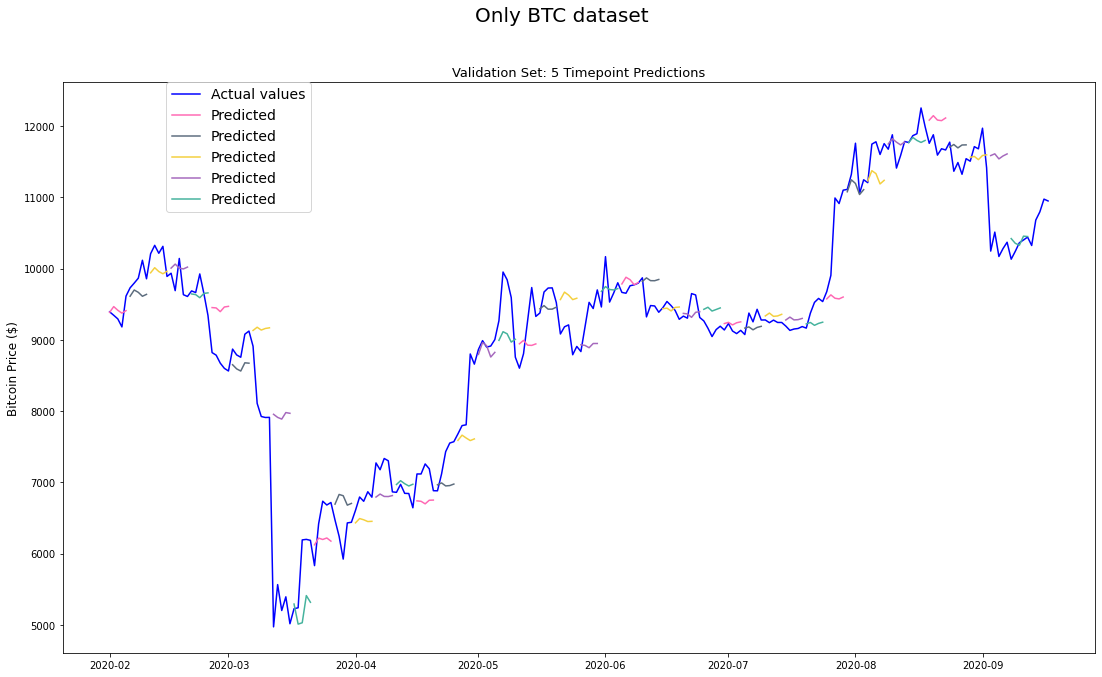

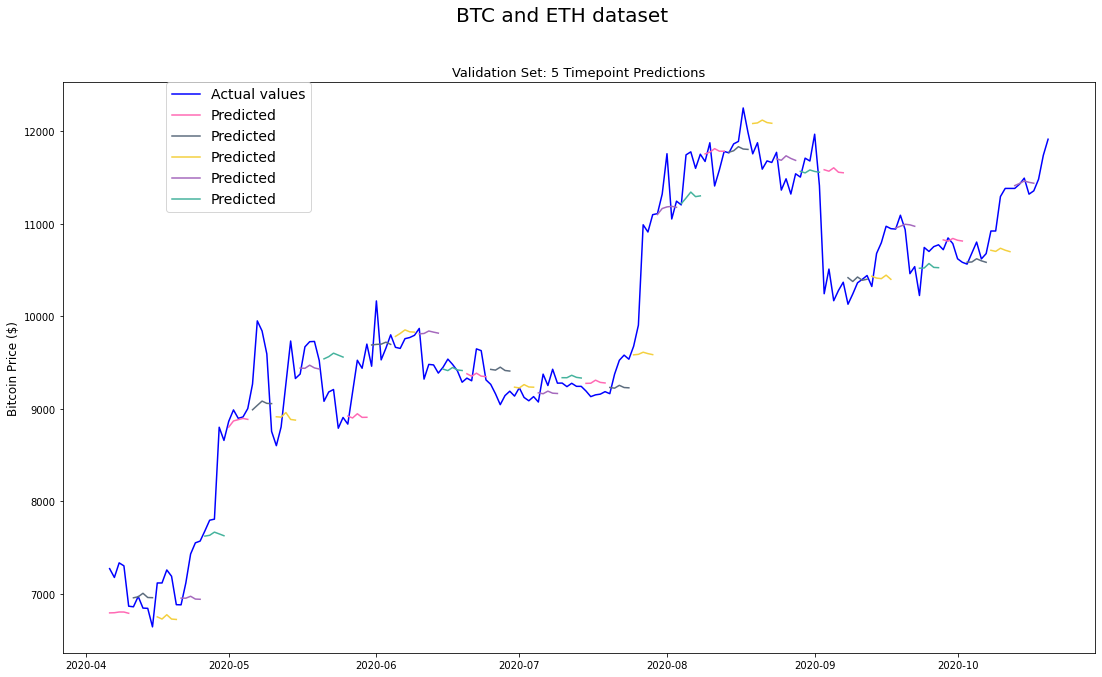

In [ ]:
plot_actual_against_ranged_prediction(btc_dataset_with_3_features, best_model_BTC, pred_range, window_len, LSTM_validation_inputs_BTC, validation_set_original_BTC, split_date_BTC, split_date_val_BTC, 'BTC_Close', 'Only BTC dataset')
print('\n\n')
plot_actual_against_ranged_prediction(btc_eth_dataset_with_3_features, best_model_BTC_ETH, pred_range, window_len, LSTM_validation_inputs_BTC_ETH, validation_set_original_BTC_ETH, split_date_BTC_ETH, split_date_val_BTC_ETH, 'BTC_Close', 'BTC and ETH dataset')

<p> As you may see, the validation sets differ. That's because during the creation of the dataset with the two coins, the merge is being done over the *Date* field and as the Ethereum coin exists less than the Bitcoin, we ended up with a smaller dataset. Then because we keep the same percentage for the validation sets these two date ranges, ending up not to be the same. Even if this fact makes the comparison between the two models unfair, whether we have been performed a training with the same dates, then this would be unfair for the model trained with plain BTC data, because it could not exploit all the history of BTC.</p>
<p>Nevertheless, even if the MAE decreases in the second case, the predictions plot does not appeared to be better (or we do not have a way to intrepret the reason this happens and how to explain it). </p>
<p> Also, it worths to be mention that during this phase, we tried also with different loss functions like Mean Square Error and different optimizers like RMSProp and Stochastic Gradient Descent.</p>

Now, we will calculate MAE for test sets that have not been used until now in order to determine the validity of our conlusions that the model trained with both cryptocoins is able to produce more accurate predictions.   

In [88]:
#Get predictions for test set utilizing the model trained with only BTC
scaled_pred_prices_BTC = (best_model_BTC.predict(LSTM_test_inputs_BTC)[:-pred_range][::pred_range])
mae_losses_of_BTC_model = tf.keras.losses.mean_absolute_error(LSTM_ranged_test_outputs_BTC[:-pred_range][::pred_range], scaled_pred_prices_BTC[:-1])
avg_mae_BTC = np.sum(mae_losses_of_BTC_model)/len(mae_losses_of_BTC_model)

In [89]:
#Get predictions for test set utilizing the model trained with both BTC and ETH
scaled_pred_prices_BTC_ETH = (best_model_BTC_ETH.predict(LSTM_test_inputs_BTC_ETH)[:-pred_range][::pred_range])
mae_losses_of_BTC_ETH_model = tf.keras.losses.mean_absolute_error(LSTM_ranged_test_outputs_BTC_ETH[:-pred_range][::pred_range], scaled_pred_prices_BTC_ETH[:-1])
avg_mae_BTC_ETH = np.sum(mae_losses_of_BTC_ETH_model)/len(mae_losses_of_BTC_ETH_model)

In [90]:
print('Average MAE for test set using model trained with only BTC data: '+str(avg_mae_BTC))
print('Average MAE for test set using model trained with both BTC and ETH data: '+str(avg_mae_BTC_ETH))

Average MAE for test set using model trained with only BTC data: 0.05614497926500109
Average MAE for test set using model trained with both BTC and ETH data: 0.06654721812198036


Unfortunately, now the the results are inverse compared with the corresponding of validation set. Model trained with both cryptocoins has higher loss than the other. Here again, the different dates might has a significant impact in losses calculation, thus the conclusions are controversial. 

<h1>Section 4<h1>
<h2> Extend dataset with social media information</h2>
<p> As we already mentioned earlier, we will continure our experiments by extending the datasets to contain also social media feed. We used the cryptocompare's api free version. The dataset for Bitcoin that we constructed can be found in this <a href='https://github.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Datasets/Social%20media/Bitcoin_social_media_info.csv'>link</a> and for Ethereum in this <a href='https://github.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Datasets/Social%20media/Ethereum_social_media_info.csv'>link</a> .</p>
<p>First, we will combine the social media and market info datasets into one.</p>

In [91]:
btc_social_media_url = 'https://raw.githubusercontent.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/main/Datasets/Social%20media/Bitcoin_social_media_info.csv'
eth_social_media_url = 'https://raw.githubusercontent.com/teoad95/Deep-learning-Cryptocurrency-price-prediction/main/Datasets/Social%20media/Ethereum_social_media_info.csv'

<p> Below, we define a function for the dataset creation merging historical market data and social media data.</p>

In [92]:
def dataset_creation_with_social(crypto_list):
    datasets = {} #Store all datasets with market information here
    social_datasets = {} #Store all datasets with social media information here
    datasets_list = {'BTC' : [btc_url, btc_social_media_url], 'ETH' : [eth_url, eth_social_media_url]}
    
    min_dates = {} #Store all minimum dates here
    max_dates = {} #Store all maximum dates here
    
    #Get market information for each coin from the corresponding csv
    for dataset_name, urls in datasets_list.items():
        if (dataset_name) in crypto_list:
            datasets[dataset_name] = pd.read_csv(urls[0]) 

            datasets[dataset_name]['Date'] = pd.to_datetime(datasets[dataset_name]['Date'])
            datasets[dataset_name].fillna(method='ffill', inplace=True)

            #Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:
            kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
              'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])
              }

            datasets[dataset_name] = datasets[dataset_name].assign(**kwards)
            
            datasets[dataset_name].fillna(-1, inplace=True) #Fill possible NaN close_off_high values with -1
                                                            #Because NaN values caused by (0/0)-1
            

            first_date = pd.to_datetime(datasets[dataset_name]['Date'][0])
            min_dates[dataset_name]=first_date
            
            last_date = pd.to_datetime(datasets[dataset_name]['Date'].iloc[-1])
            max_dates[dataset_name] = last_date
    
    
    #Get social media information for each coin from the corresponding csv
    for dataset_name, urls in datasets_list.items():
        if (dataset_name) in crypto_list:
          
            social_datasets[dataset_name] = pd.read_csv(urls[1]) 
            
            social_datasets[dataset_name]['time'] = pd.to_datetime(social_datasets[dataset_name]['time'])
            
            #Drop first column which is an unused index
            social_datasets[dataset_name] = social_datasets[dataset_name].iloc[:, 1:]
            
            #We observed that there are many zero rows at social media datasets.
            #We should find the first row which is non-zero
            res = [next(((j, i) for i, j in enumerate(social_datasets[dataset_name][col]) if j != 0), (0, 0)) 
                   for col in social_datasets[dataset_name] if col != 'time']
            
            #Get all columns except 'time'
            columns_except_time = [col for col in social_datasets[dataset_name].columns if col != 'time']
            
            #Store the index of each column with the first non-zero element
            df_res = pd.DataFrame(res, columns=['value', 'position'], index=columns_except_time)
            
            #Get the minimum of these indices
            first_non_zero_row = df_res['position'].min()

            
            first_date = pd.to_datetime(social_datasets[dataset_name]['time'][first_non_zero_row])
            if first_date >  min_dates[dataset_name]:
                 min_dates[dataset_name] = first_date
                    
            last_date = pd.to_datetime(social_datasets[dataset_name]['time'].iloc[-1])
            if last_date < max_dates[dataset_name]:
                max_dates[dataset_name] = last_date
            

    max_date = max(min_dates.values(), key=lambda v: v)
    min_date = min(max_dates.values(), key=lambda v: v)
    

    #Drop all the data which are prior to max_date and later to min_date
    for dataset in datasets:
        datasets[dataset] = datasets[dataset][(datasets[dataset]['Date'] >= max_date) & 
                                              (datasets[dataset]['Date'] <= min_date)]
        
    for dataset in social_datasets:
        social_datasets[dataset] = social_datasets[dataset][(social_datasets[dataset]['time'] >= max_date) & 
                                                            (social_datasets[dataset]['time'] <= min_date)]

    
    #Compute the average and standard deviation of 'Close' value for the last 7-days and 30-days(month): 
    for dataset in datasets:

        temp = datasets[dataset].copy()

        #Drop the first 30 days to be able to compute average and standard deviation of month for the rows of the table
        temp = temp[29:]

        temp['mean_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).mean()

        temp['mean_month_Close'] = datasets[dataset]['Close'].rolling(window=30).mean()

        temp['std_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).std()

        temp['std_month_Close'] = datasets[dataset]['Close'].rolling(window=30).std()

        datasets[dataset] = temp.copy()
        
    
    #Drop the first 30 days of 'social_datasets' to be aligned with 'datasets'
    for dataset in social_datasets:
            social_datasets[dataset] = social_datasets[dataset][29:]
        
        



    #Rename the columns
    count = 0
    for dataset in datasets:

        datasets[dataset] = datasets[dataset].rename(columns={'Close':dataset+'_Close', 'Open':dataset+'_Open', 
                                                              'High':dataset+'_High', 'Low':dataset+'_Low', 
                                                              'Adj Close':dataset+'_Adj_Close', 
                                                              'Volume':dataset+'_Volume', 
                                                              'close_off_high':dataset+'_close_off_high',
                                                              'volatility':dataset+'_volatility',
                                                              'mean_7days_Close':dataset+'_mean_7days_Close',
                                                              'mean_month_Close':dataset+'_mean_month_Close',
                                                              'std_7days_Close':dataset+'_std_7days_Close',
                                                              'std_month_Close':dataset+'_std_month_Close'})
        
        
        if count == 0:
            
            date_col = (datasets[dataset]['Date'].reset_index()).drop(['index'], axis=1)
            
            
        datasets[dataset] = ((datasets[dataset].drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1) 
        
    
    
    for dataset in social_datasets:
        
        social_datasets[dataset] = social_datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        
        social_datasets[dataset] = ((social_datasets[dataset].drop([dataset+'_time'], axis=1)).reset_index()).drop(['index'], 
                                                                                                          axis=1) 
                                                            
    
    
    #Concatenate all datasets to one 
    whole_market_dataset = pd.concat([datasets[dataset] for dataset in datasets], axis=1)
    whole_social_dataset = pd.concat([social_datasets[dataset] for dataset in social_datasets], axis=1)
    whole_dataset = pd.concat([date_col, whole_market_dataset, whole_social_dataset], axis=1)
    
   
    return whole_dataset

<p> By using the function we created 2 new datasets, one with BTC market info and social media feed, and one with BTC and ETH market info and social media feed. </p>

In [93]:
btc_sm_and_mi_combined_ds = dataset_creation_with_social(['BTC'])
btc_and_eth_sm_and_mi_combined_ds = dataset_creation_with_social(['BTC', 'ETH'])

In [94]:
feature_list = list(map(lambda x: x.replace("BTC_", ""), btc_sm_and_mi_combined_ds.columns[1:].to_list()))

<p>Next, we will test the performance of the models with the new datasets without performing any adjustment into the feature lists.</p>

In [111]:
LSTM_ranged_training_outputs_BTC_with_social, LSTM_ranged_validation_outputs_BTC_with_social, LSTM_ranged_test_outputs_BTC_with_social, LSTM_training_inputs_BTC_with_social, LSTM_validation_inputs_BTC_with_social, LSTM_test_inputs_BTC_with_social, split_date, split_date_val, validation_set_original_BTC_with_social = get_specific_features_normalized(btc_sm_and_mi_combined_ds, feature_list)
model_BTC_with_social = build_model_with_best_architecture(LSTM_training_inputs_BTC_with_social)
hist_of_BTC_with_social_media_included = model.fit(LSTM_training_inputs_BTC_with_social[:-pred_range], LSTM_ranged_training_outputs_BTC_with_social, validation_data=(LSTM_validation_inputs_BTC_with_social[:-pred_range], LSTM_ranged_validation_outputs_BTC_with_social), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

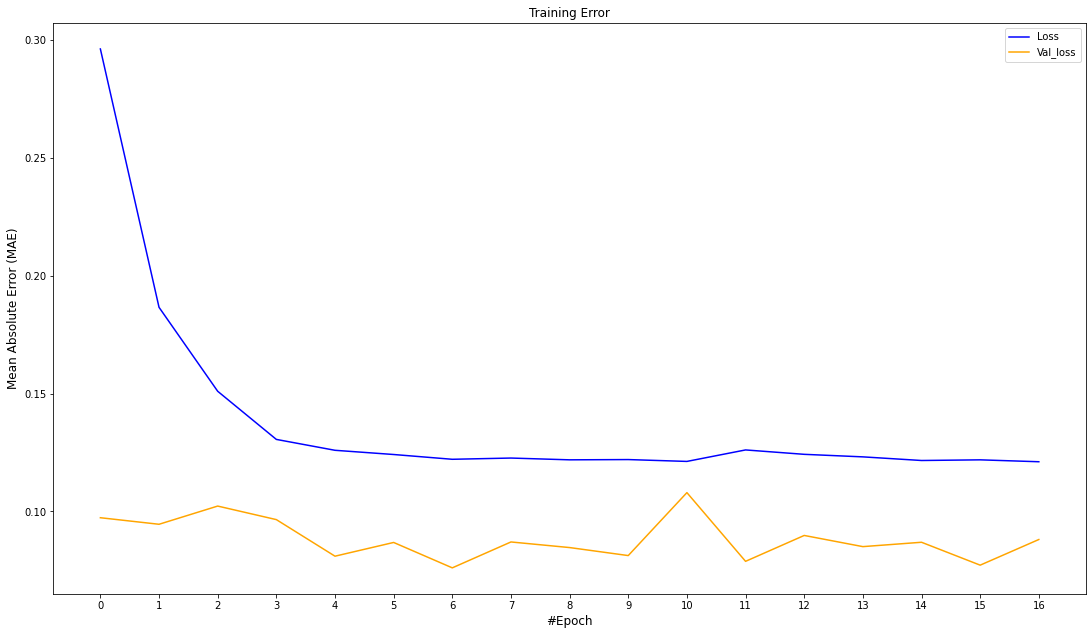

In [ ]:
plot_loss_and_val_loss(hist_of_BTC_with_social_media_included)

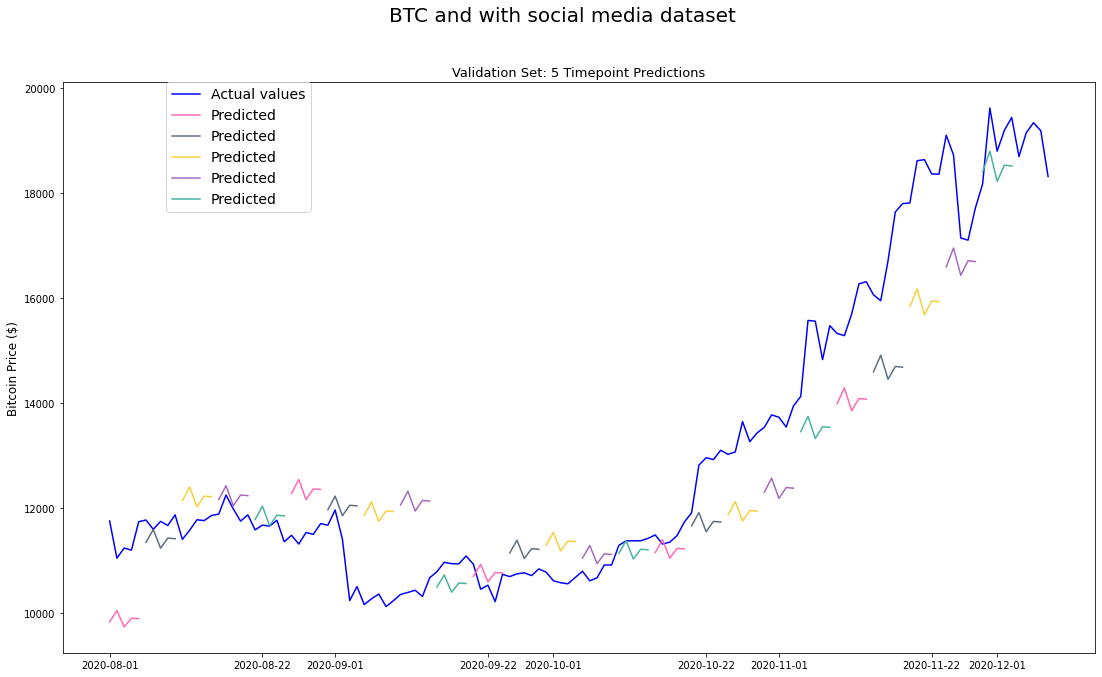

In [ ]:
plot_actual_against_ranged_prediction(btc_sm_and_mi_combined_ds, model_BTC_with_social, pred_range, window_len, LSTM_validation_inputs_BTC_with_social, validation_set_original_BTC_with_social, split_date, split_date_val, 'BTC_Close', 'BTC and with social media dataset')

In [112]:
LSTM_ranged_training_outputs_BTC_ETH_with_social, LSTM_ranged_validation_outputs_BTC_ETH_with_social, LSTM_ranged_test_outputs_BTC_ETH_with_social, LSTM_training_inputs_BTC_ETH_with_social, LSTM_validation_inputs_BTC_ETH_with_social, LSTM_test_inputs_BTC_ETH_with_social, split_date, split_date_val, validation_set_original_BTC_ETH_with_social = get_specific_features_normalized(btc_and_eth_sm_and_mi_combined_ds, feature_list)
model_BTC_ETH_with_social = build_model_with_best_architecture(LSTM_training_inputs_BTC_ETH_with_social)
hist_of_BTC_ETH_with_social_media_included = model_BTC_ETH_with_social.fit(LSTM_training_inputs_BTC_ETH_with_social[:-pred_range], LSTM_ranged_training_outputs_BTC_ETH_with_social, validation_data=(LSTM_validation_inputs_BTC_ETH_with_social[:-pred_range], LSTM_ranged_validation_outputs_BTC_ETH_with_social), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

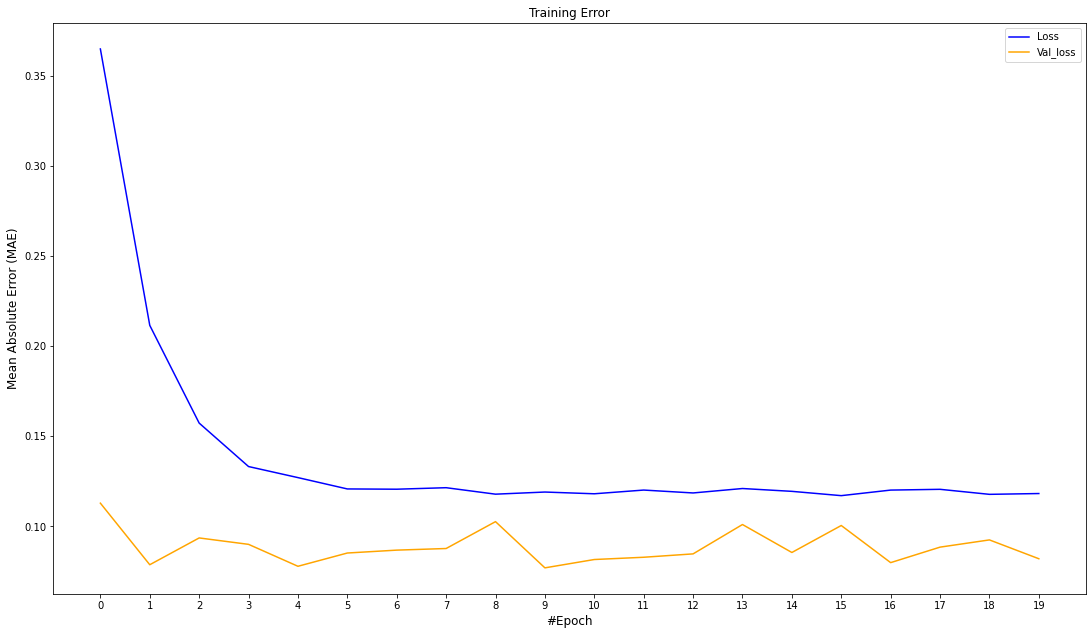

In [ ]:
plot_loss_and_val_loss(hist_of_BTC_ETH_with_social_media_included)

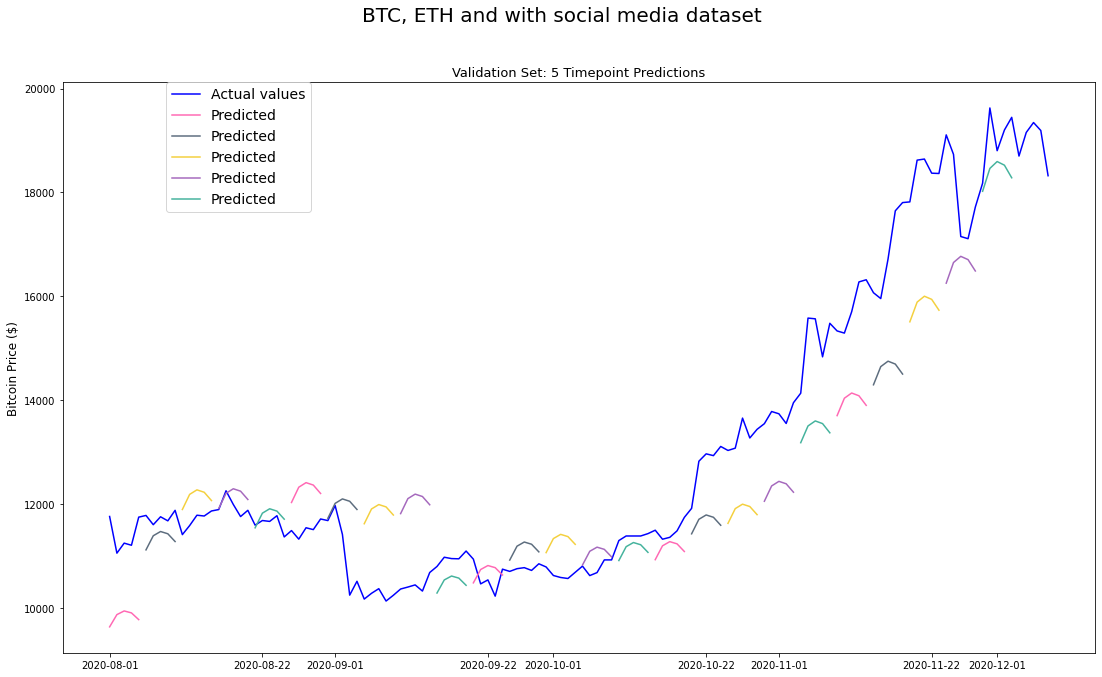

In [ ]:
plot_actual_against_ranged_prediction(btc_and_eth_sm_and_mi_combined_ds, model_BTC_ETH_with_social, pred_range, window_len, LSTM_validation_inputs_BTC_ETH_with_social, validation_set_original_BTC_ETH_with_social, split_date, split_date_val, 'BTC_Close', 'BTC, ETH and with social media dataset')

<p>As we can easily conclude from the above diagrams, our best model, does not perform well nor with the new dataset. More specifically, it seems like the validation losses are higher than without the social media feed. Using both datasets the model "learns a specific pattern". We could say that using the dataset with both coins the model learns that the Close value decreases more smooth than before.</p>
<p> We will continue by trying to exclude some of the features and keep only the most significant based on their correlation. In this way, we will try to aim the model by removing the "noisy" features. For this task we will use correlation matrices.</p>

Using cryptocurrencies: ['BTC']


Without normalization


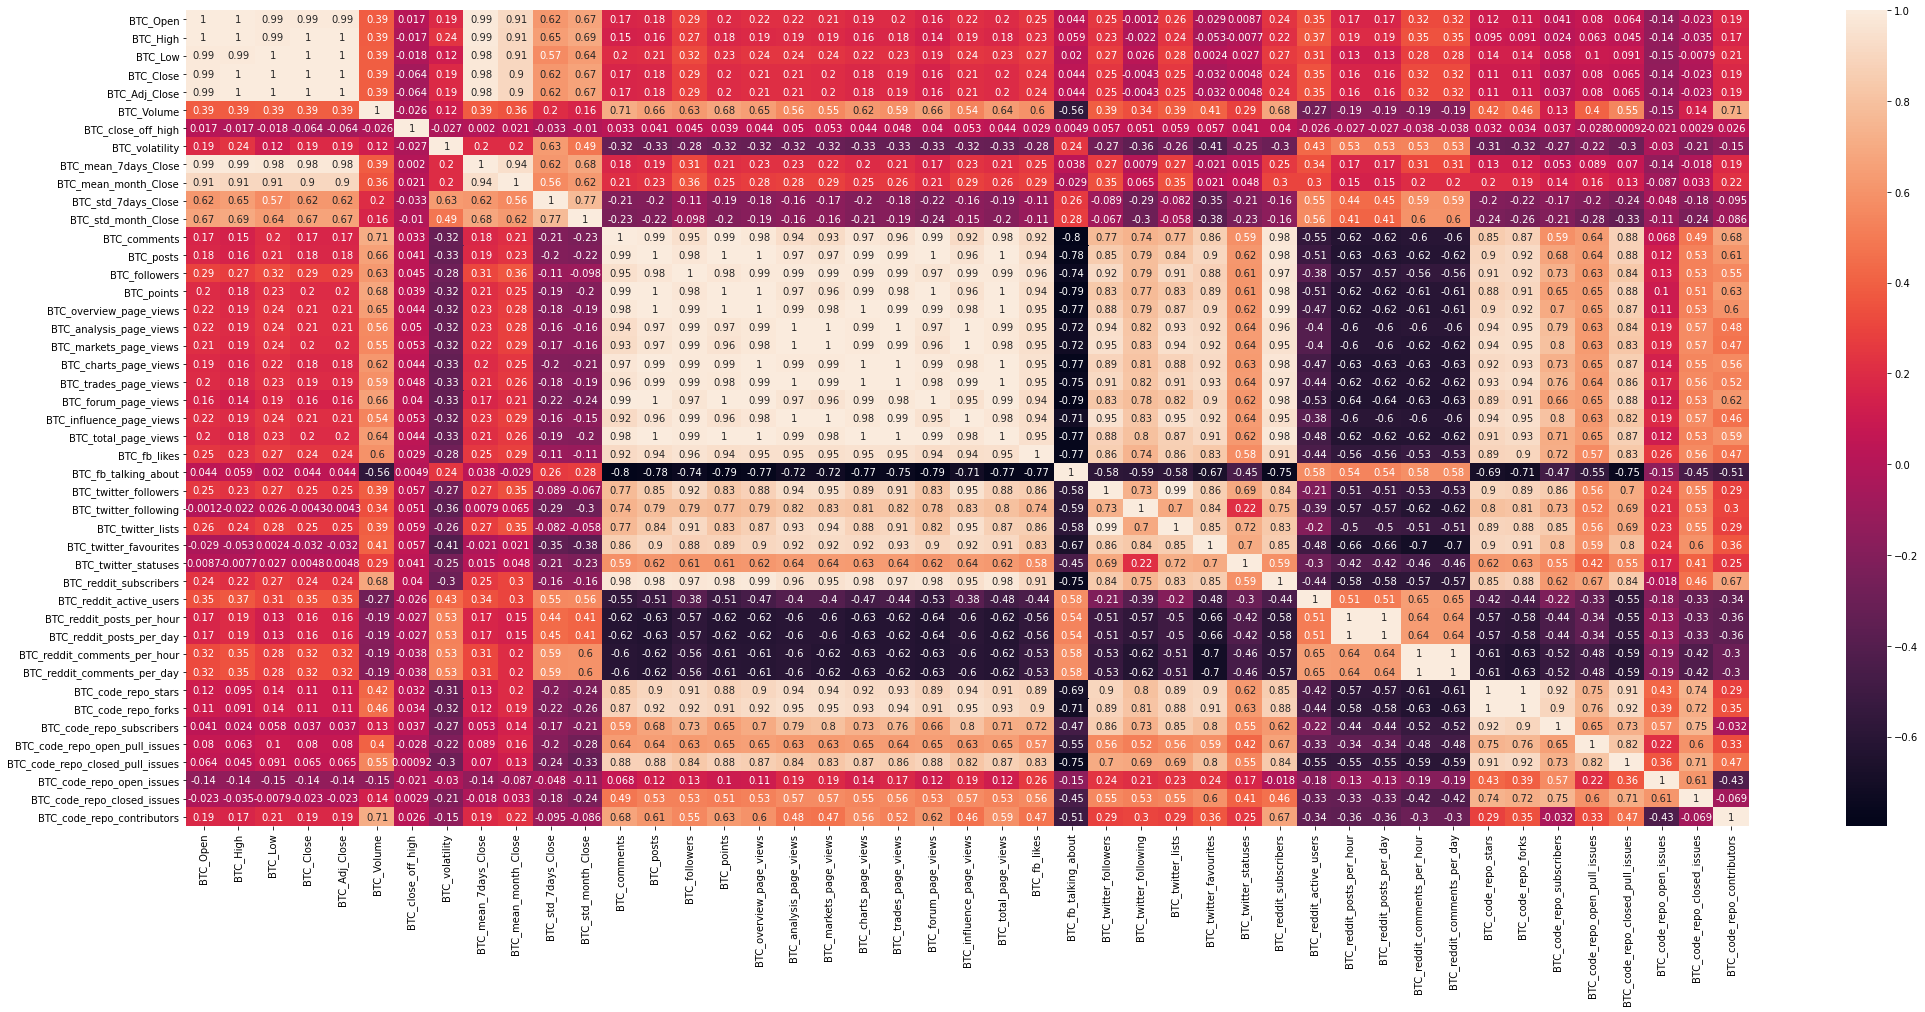

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


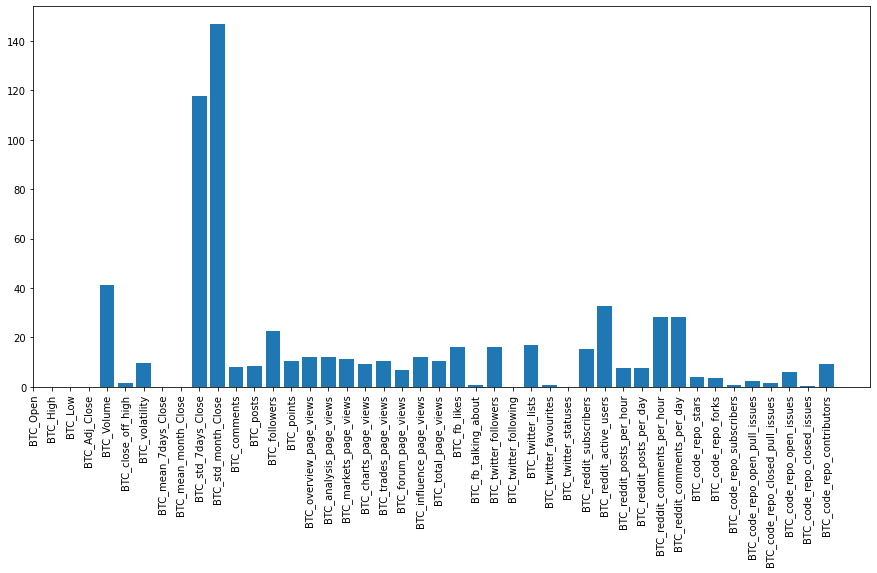

                        Feature_Name         Score
3                      BTC_Adj_Close  1.263260e+18
1                           BTC_High  1.426853e+05
2                            BTC_Low  1.138598e+05
0                           BTC_Open  5.951659e+04
7               BTC_mean_7days_Close  3.119418e+04
8               BTC_mean_month_Close  4.931590e+03
10               BTC_std_month_Close  9.139615e+02
9                BTC_std_7days_Close  6.846654e+02
4                         BTC_Volume  2.007190e+02
31           BTC_reddit_active_users  1.542505e+02
34      BTC_reddit_comments_per_hour  1.316458e+02
35       BTC_reddit_comments_per_day  1.316458e+02
13                     BTC_followers  1.034961e+02
27                 BTC_twitter_lists  7.625326e+01
25             BTC_twitter_followers  7.183862e+01
23                      BTC_fb_likes  7.071510e+01
30            BTC_reddit_subscribers  6.708853e+01
21          BTC_influence_page_views  5.299748e+01
16           BTC_analysis_page_

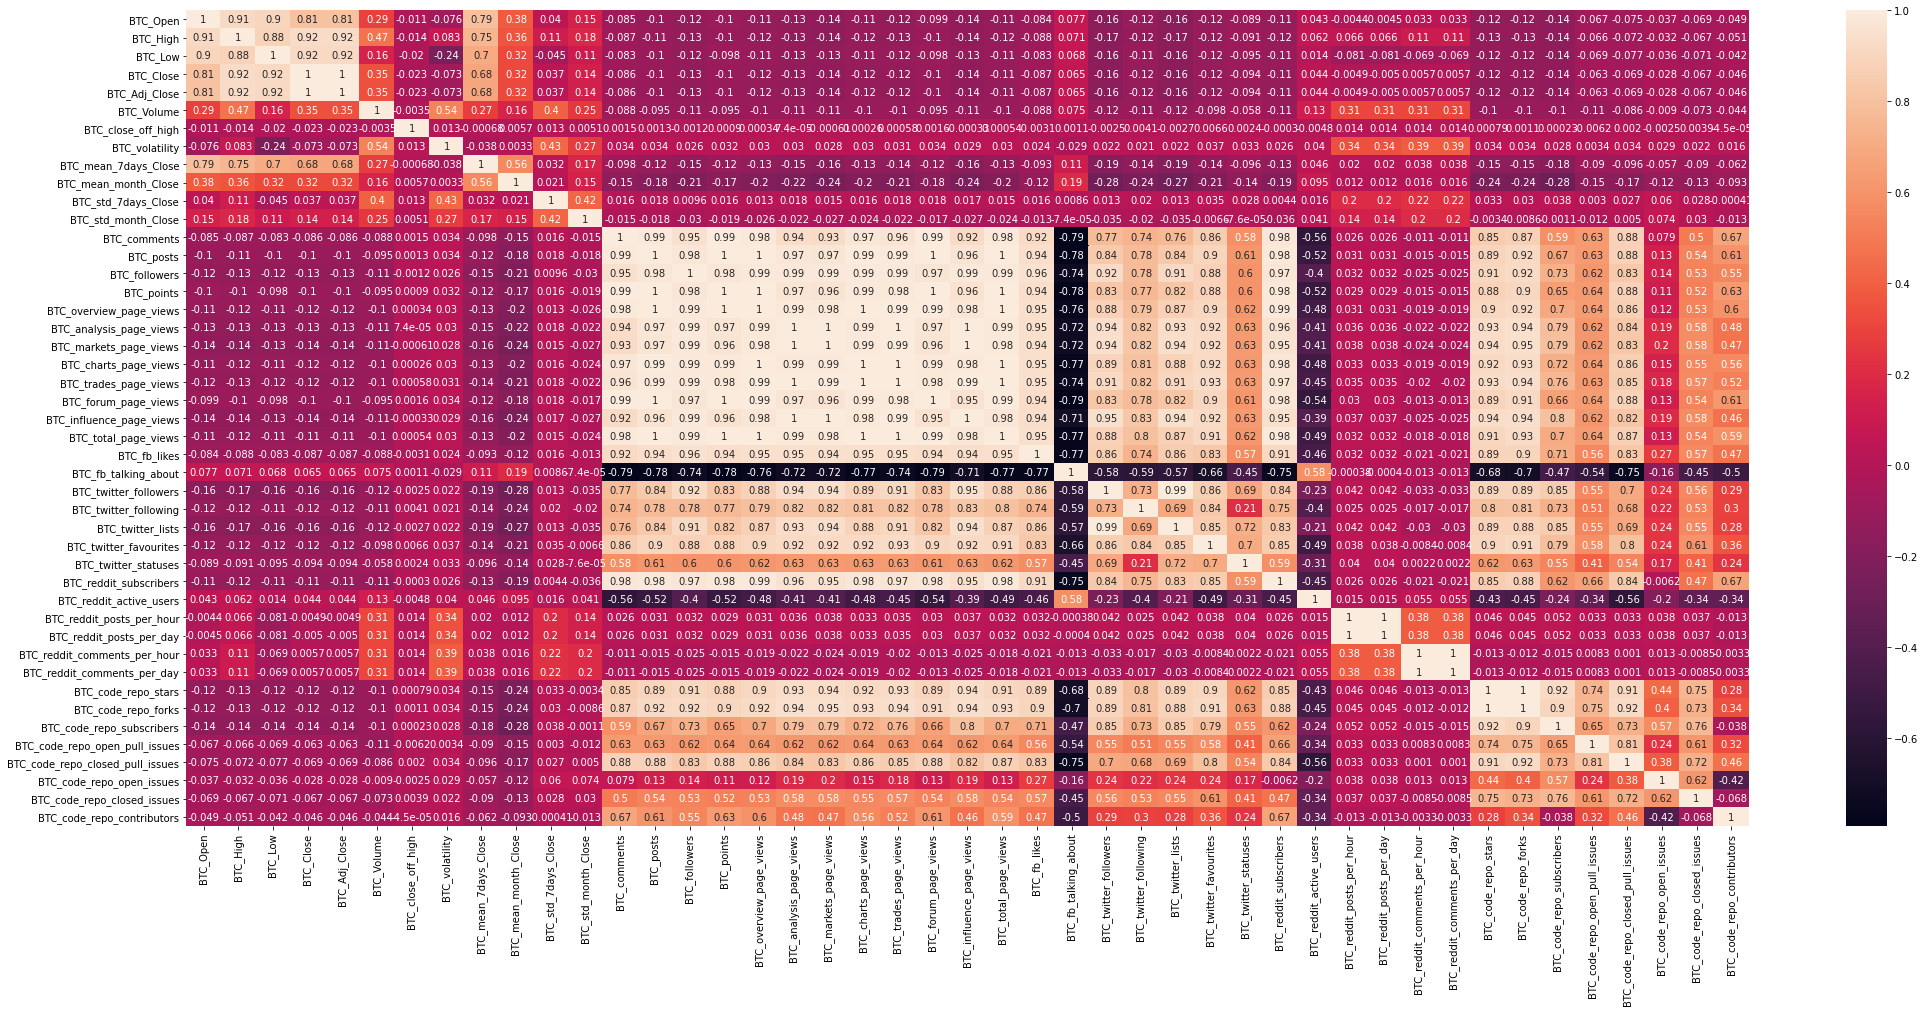

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


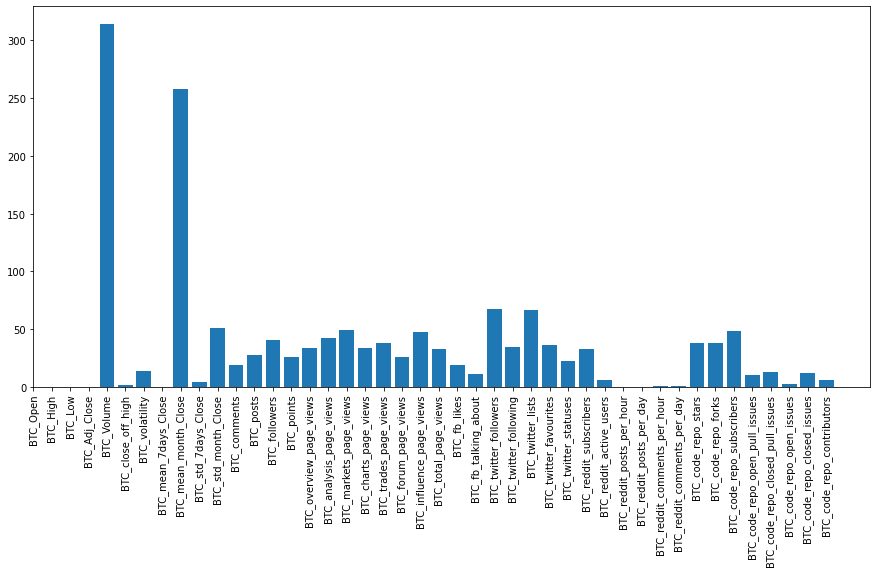

                        Feature_Name         Score
3                      BTC_Adj_Close  3.582935e+18
1                           BTC_High  6.520199e+04
2                            BTC_Low  5.739778e+04
0                           BTC_Open  2.087374e+04
7               BTC_mean_7days_Close  9.689002e+03
4                         BTC_Volume  1.534564e+03
8               BTC_mean_month_Close  1.246334e+03
25             BTC_twitter_followers  3.094355e+02
27                 BTC_twitter_lists  3.054255e+02
10               BTC_std_month_Close  2.298435e+02
17            BTC_markets_page_views  2.223665e+02
38         BTC_code_repo_subscribers  2.190157e+02
21          BTC_influence_page_views  2.139549e+02
16           BTC_analysis_page_views  1.910136e+02
13                     BTC_followers  1.829785e+02
19             BTC_trades_page_views  1.717511e+02
36               BTC_code_repo_stars  1.699240e+02
37               BTC_code_repo_forks  1.685846e+02
28            BTC_twitter_favou

In [ ]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression

def plot_corr_matrix(datast):
    corrMatrix = datast.corr()
    plt.figure(figsize=(35,15))
    sns.heatmap(corrMatrix, annot=True)
    plt.show()
    
def select_best_feats(x_corr_matr, y_corr_matr):
    selector = SelectKBest(f_regression, k='all')
    fit = selector.fit(x_corr_matr, y_corr_matr)
    
    # Get the raw p-values for each feature, and transform from p-values into scores
    scores = -np.log10(selector.pvalues_)
    
    # Plot the scores. 
    predictors = x_corr_matrix.columns
    plt.figure(figsize=(15,7))
    plt.bar(range(len(predictors)), scores)
    plt.xticks(range(len(predictors)), predictors, rotation='vertical')
    plt.show()
    
    #Create a Data Frame with the scores of features
    df_scores = pd.DataFrame(fit.scores_)
    
    #Create a Data Frame with the names of features
    df_columns = pd.DataFrame(predictors) 
    
    #Concatenate the two above Data Frames to get in one column the names of features and in other their scores
    feature_scores = pd.concat([df_columns, df_scores],axis=1)

    #Specify column names
    feature_scores.columns = ['Feature_Name','Score'] 
    print(feature_scores.nlargest(45,'Score'))

    
def normalize_data(tr_set, wind_len):
    
    #Normalize training inputs
    count = 0
    for i in range(len(tr_set) - wind_len):
        tmp_set = tr_set[i:(i + wind_len)].copy()
        
        for col in tr_set.columns:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used
        
        if count == 0:
            
            tr_in = tmp_set.copy()
            count += 1
        
        else:
            
            tr_in = pd.concat([tr_in.copy(), tmp_set.copy()], ignore_index=True)

    return tr_in
    
#Get data
crypto_list = [['BTC']] #Define the sets of cryptocurrencies to be tested

coin_target = 'BTC'


for cryptocurrency_list in crypto_list:
    
    cryptocurrency_list_output = 'Using cryptocurrencies: '+str(cryptocurrency_list)
    print(cryptocurrency_list_output)
    data = dataset_creation_with_social(cryptocurrency_list)
    
    #Split data
    percent_train_set = 0.8
    percent_val_set = 0.5

    training_set, test_set, validation_set, split_date_train, split_date_valid = split_dataset_to_train_and_validation(data,percent_train_set, 
                                                                                           percent_val_set)

    #####Without normalization###
    print('\n\n\033[1mWithout normalization\033[0m')
    
    #Plot correlation matrix 
    initial_corr_matrix_data = training_set.drop(['Date'], axis=1)
    corr_matrix_data = initial_corr_matrix_data.copy()
    plot_corr_matrix(corr_matrix_data)
    
    #Select best features using SelectKBest method with f_regression
    y_corr_matrix = corr_matrix_data.pop(coin_target+'_Close') 
    x_corr_matrix = corr_matrix_data.copy()
    select_best_feats(x_corr_matrix, y_corr_matrix)
    
    
    ###With normalization####
    
    print('\n\n\033[1mWith normalization\033[0m')
    
    window_len = 10
    norm_corr_matrix_data = normalize_data(initial_corr_matrix_data, window_len) #Normalize in sliding windows
    
    #Plot correlation matrix 
    plot_corr_matrix(norm_corr_matrix_data)
    
    
    #Select best features using SelectKBest method with f_regression
    norm_y_corr_matrix = norm_corr_matrix_data.pop(coin_target+'_Close') 
    norm_x_corr_matrix = norm_corr_matrix_data.copy()
    select_best_feats(norm_x_corr_matrix, norm_y_corr_matrix)

<p>As we can observe the score of some features at the barplot are zero. For the first of them (BTC_Open, BTC_Low, BTC_High, BTC_mean_7days_Close, BTC_mean_month_Close), it happens because their <i>p-value</i>  is close to 0, thus -log10 returns an <i>Infinite</i> value.
A low <i>p-value</i> means that we can reject null hypothesis. In <i>f_regression</i> method, the null hypothesis of test performed is that all of the regression coefficients are equal to 0, which means that the model has no predictive capability. The variables which have 0 or almost 0 </i>p-value</i> should be considered that they are very effective predictors.

Next, it is significant to observe that correlation matrix and SelextKBest results are different for normazided and non-normalized data. This discrepancy should be taken into consideration on feature selection. We should choose the features based on results of normalized data, otherwise we will be biased due to numeric scale of each feature.

As we have already found out that 'Open' and 'High' lead to the best results in terms of the <i>market features</i>, now we will try the best <i>social media features</i>. We will begin with the 5 first of them. When a feature will have a correlation greater than 0.9 in relation with the rest of already chosen ones, it will be skipped.

The first is 'twitter_followers', next is 'twitter_lists', but they are extreme correlated (0.99), thus we will skip 'twitter_lists'.

Next in the list is 'market_page_views', which is also extreme correlated (0.94) with 'twitter_followers'. 

'code_repo_subscibers' has a correlation of grade 0.85 with 'twitter_followers' so we can include it.

'influence_page_view', 'analysis_page_views', 'followers' and 'trade_page_views' are correlated with 'twitter_followers' (0.95, 0.94, 0.92 and 0.91 respectively), then they will be excluded.

'code_repo_stars' and 'code_repo_forks' are correlated with 'code_repo_subscibers' (0.92 and 0.9, respectively), then they will be skipped.

'twitter_favourites' will be used as it has correlation values lower than 0.9 with the rest of the selected features.

Also, 'twitter_following' is suitable based on its correlation values with 'twitter_followers', 'code_repo_subscibers', 'twitter_favourites'.

'overview_page_views' and 'charts_page_views' are high correlated with 'twitter_favourites' (0.9  and 0.92, respectively), thus they will not be included.

'reddit_subscribers' is not overcome the correlation threshold of 0.9, so we should use it.

Finally, we have the 5 most informative social media features ('twitter_followers', 'code_repo_subscribers', 'twitter_favourites', 'twitter_following', 'reddit_subscribers')

So, we will try again with the following feature list:
'Close', 'Open', 'High', 'twitter_followers', 'code_repo_subscribers','twitter_favourites', 'twitter_following', 'reddit_subscribers'.
</p>

In [99]:
feature_list = ['Close', 'Open', 'High', 'twitter_followers', 'code_repo_subscribers','twitter_favourites', 
                      'twitter_following', 'reddit_subscribers']

In [104]:
LSTM_ranged_training_outputs_BTC_spec_feat, LSTM_ranged_validation_outputs_BTC_spec_feat, LSTM_ranged_test_outputs_BTC_spec_feat, LSTM_training_inputs_BTC_spec_feat, LSTM_validation_inputs_BTC_spec_feat, LSTM_test_inputs_BTC_spec_feat, split_date, split_date_val, validation_set_original_BTC_spec_feat = get_specific_features_normalized(btc_sm_and_mi_combined_ds, feature_list)
model_BTC_spec_feat = build_model_with_best_architecture(LSTM_training_inputs_BTC_spec_feat)
hist_of_BTC_with_social_media_included = model_BTC_spec_feat.fit(LSTM_training_inputs_BTC_spec_feat[:-pred_range], LSTM_ranged_training_outputs_BTC_spec_feat, validation_data=(LSTM_validation_inputs_BTC_spec_feat[:-pred_range], LSTM_ranged_validation_outputs_BTC_spec_feat), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

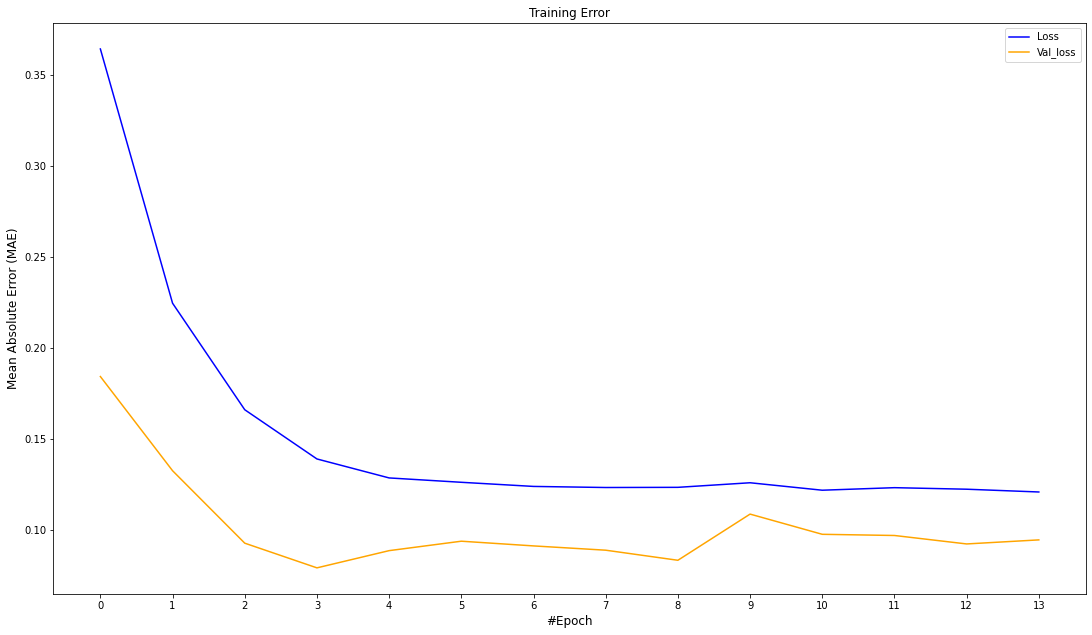

In [ ]:
plot_loss_and_val_loss(hist_of_BTC_with_social_media_included)

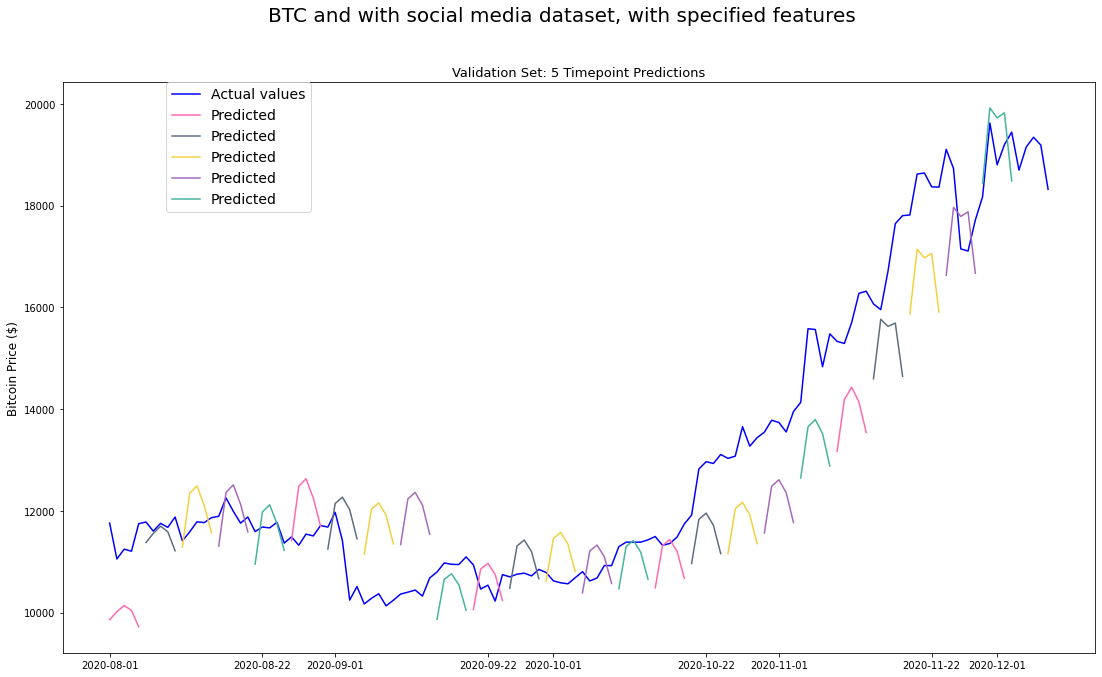

In [ ]:
plot_actual_against_ranged_prediction(btc_sm_and_mi_combined_ds, model_BTC_spec_feat, pred_range, window_len, LSTM_validation_inputs_BTC_spec_feat, validation_set_original_BTC_spec_feat, split_date, split_date_val, 'BTC_Close', 'BTC and with social media dataset, with specified features')

In [105]:
LSTM_ranged_training_outputs_BTC_ETH_spec_feat, LSTM_ranged_validation_outputs_BTC_ETH_spec_feat, LSTM_ranged_test_outputs_BTC_ETH_spec_feat, LSTM_training_inputs_BTC_ETH_spec_feat, LSTM_validation_inputs_BTC_ETH_spec_feat, LSTM_test_inputs_BTC_ETH_spec_feat, split_date, split_date_val, validation_set_original_BTC_ETH_spec_feat = get_specific_features_normalized(btc_and_eth_sm_and_mi_combined_ds, feature_list)
model_BTC_ETH_spec_feat = build_model_with_best_architecture(LSTM_training_inputs_BTC_ETH_spec_feat)
hist_of_BTC_ETH_with_social_media_included = model_BTC_ETH_spec_feat.fit(LSTM_training_inputs_BTC_ETH_spec_feat[:-pred_range], LSTM_ranged_training_outputs_BTC_ETH_spec_feat, validation_data=(LSTM_validation_inputs_BTC_ETH_spec_feat[:-pred_range], LSTM_ranged_validation_outputs_BTC_ETH_spec_feat), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

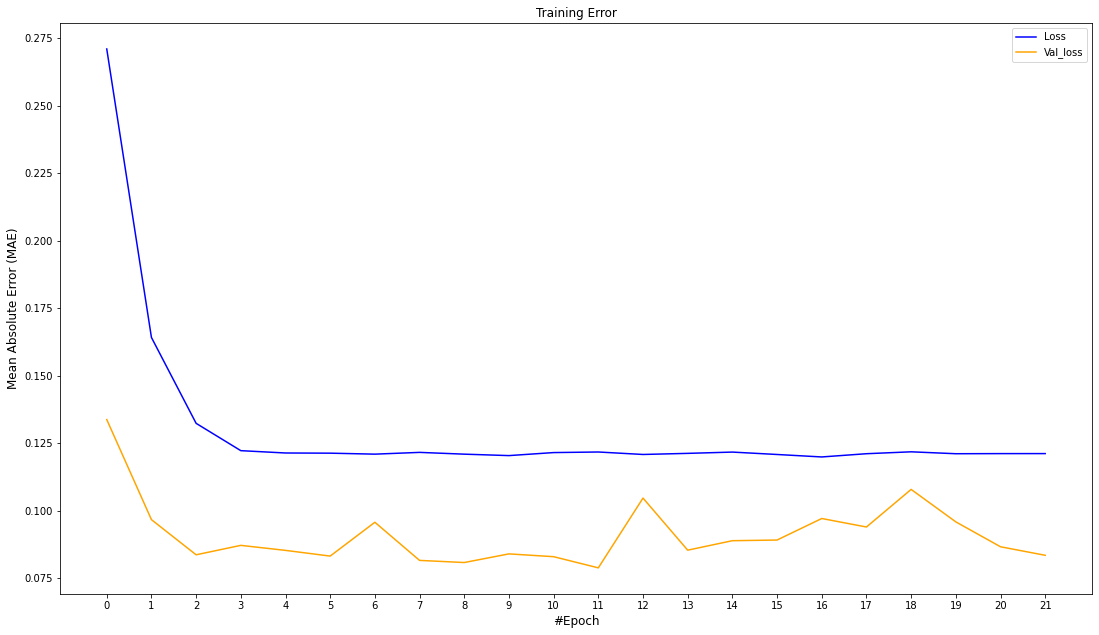

In [ ]:
plot_loss_and_val_loss(hist_of_BTC_ETH_with_social_media_included)

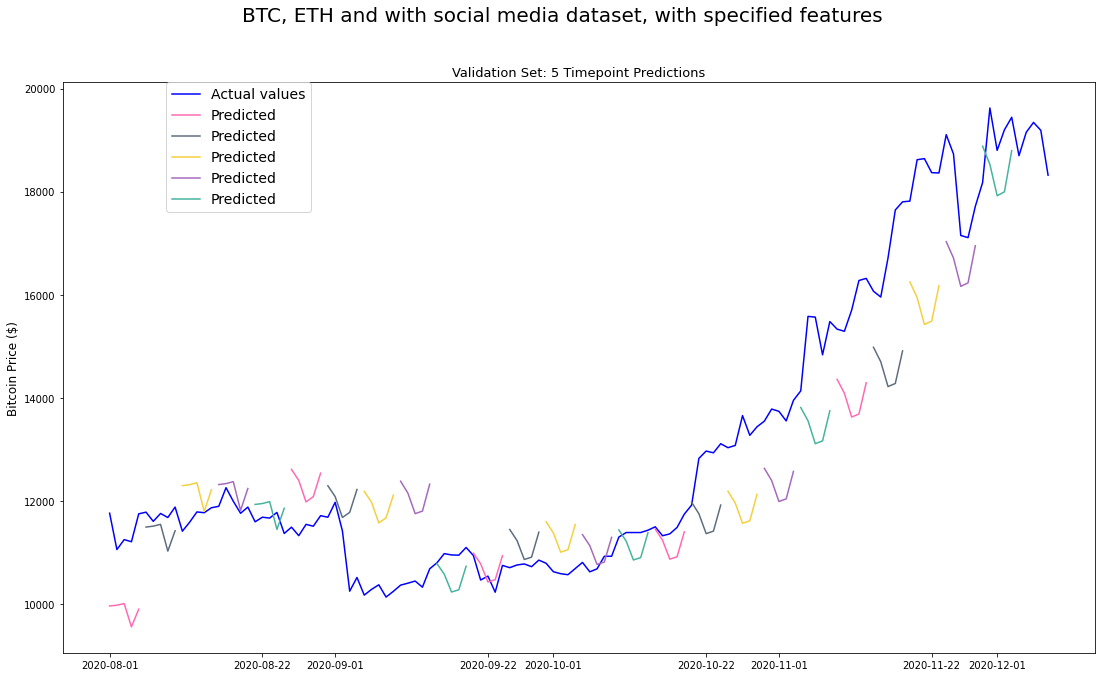

In [ ]:
plot_actual_against_ranged_prediction(btc_and_eth_sm_and_mi_combined_ds, model_BTC_ETH_spec_feat, pred_range, window_len, LSTM_validation_inputs_BTC_ETH_spec_feat, validation_set_original_BTC_ETH_spec_feat, split_date, split_date_val, 'BTC_Close', 'BTC, ETH and with social media dataset, with specified features')

<p> It's clear that by using the specific feature list with both BTC and ETH, we have a small decrease of the validation loss but still the results are not encouraging. </p>
<p>Now, we should make predictions with test sets validate this inference. It should be noticed that the dates range is equivalent for both the model trained with only BTC data (market info and social media) and the one with BTC and ETH. This is a different case than the previous section, because the social media information is for only for the last 3 years for both BTC and ETH. Therefore, the outcomes that will emerge will not be controversial.</p>

In [106]:
#Get predictions for test set utilizing the model trained with only BTC for specific features
scaled_pred_prices_BTC_spec_feat = (model_BTC_spec_feat.predict(LSTM_test_inputs_BTC_spec_feat)[:-pred_range][::pred_range])
mae_losses_of_BTC_spec_feat_model = tf.keras.losses.mean_absolute_error(LSTM_ranged_test_outputs_BTC_spec_feat[:-pred_range][::pred_range], scaled_pred_prices_BTC_spec_feat[:-1])
avg_mae_BTC_spec_feat_model = np.sum(mae_losses_of_BTC_spec_feat_model)/len(mae_losses_of_BTC_spec_feat_model)

In [108]:
#Get predictions for test set utilizing the model trained with both BTC and ETH for specific features
scaled_pred_prices_BTC_ETH_spec_feat = (model_BTC_ETH_spec_feat.predict(LSTM_test_inputs_BTC_ETH_spec_feat)[:-pred_range][::pred_range])
mae_losses_of_BTC_ETH_spec_feat_model = tf.keras.losses.mean_absolute_error(LSTM_ranged_test_outputs_BTC_ETH_spec_feat[:-pred_range][::pred_range], scaled_pred_prices_BTC_ETH_spec_feat[:-1])
avg_mae_BTC_ETH_spec_feat_model = np.sum(mae_losses_of_BTC_ETH_spec_feat_model)/len(mae_losses_of_BTC_ETH_spec_feat_model)

In [113]:
#Get predictions for test set utilizing the model trained with only BTC for all social media features
scaled_pred_prices_BTC_with_social = (model_BTC_with_social.predict(LSTM_test_inputs_BTC_with_social)[:-pred_range][::pred_range])
mae_losses_of_BTC_with_social_model = tf.keras.losses.mean_absolute_error(LSTM_ranged_test_outputs_BTC_with_social[:-pred_range][::pred_range], scaled_pred_prices_BTC_with_social[:-1])
avg_mae_BTC_with_social_model = np.sum(mae_losses_of_BTC_with_social_model)/len(mae_losses_of_BTC_with_social_model)

In [115]:
#Get predictions for test set utilizing the model trained with both BTC and ETH for all social media features
scaled_pred_prices_BTC_ETH_with_social = (model_BTC_ETH_with_social.predict(LSTM_test_inputs_BTC_ETH_with_social)[:-pred_range][::pred_range])
mae_losses_of_BTC_ETH_with_social_model = tf.keras.losses.mean_absolute_error(LSTM_ranged_test_outputs_BTC_ETH_with_social[:-pred_range][::pred_range], scaled_pred_prices_BTC_ETH_with_social[:-1])
avg_mae_BTC_ETH_with_social_model = np.sum(mae_losses_of_BTC_ETH_with_social_model)/len(mae_losses_of_BTC_ETH_with_social_model)

In [117]:
print('Average MAE for test set using model trained with only BTC data and specific social media features: '+str(avg_mae_BTC_spec_feat_model))
print('Average MAE for test set using model trained with both BTC and ETH data and specific social media features: '+str(avg_mae_BTC_ETH_spec_feat_model))
print('Average MAE for test set using model trained with only BTC data and all social media features: '+str(avg_mae_BTC_with_social_model))
print('Average MAE for test set using model trained with both BTC and ETH data and all social media features: '+str(avg_mae_BTC_ETH_with_social_model))

Average MAE for test set using model trained with only BTC data and specific social media features: 0.1745792579650879
Average MAE for test set using model trained with both BTC and ETH data and specific social media features: 0.22375450134277344
Average MAE for test set using model trained with only BTC data and all social media features: 0.4791862106323242
Average MAE for test set using model trained with both BTC and ETH data and all social media features: 0.192088623046875


Based on test set results, the conclusions are hard to be infered. When the mere BTC data with specific social media features are used, the MAE is the lowest. However, when BTC data with all the social media features are used the results are the worst. On the other hand, when both BTC and ETH are used, MAE is quite close for both with the specific and all the features cases. 

These latter cases, are also quite close to the lowest MAE. Consequently, we could conclude that even though the model trained with BTC and ETH dataset can not achieve the higher performance in terms of MAE, it is more stable in its predictions and the error produced. 

Hence, such a model has the ability to generilize in a greater extent the knowledge learnt during training proccess than the one trained only with BTC. 

<h1>Section 5<h1>
<h2> Results after applying normalization in the whole dataset (instead of windows)</h2>
<p> We will normalize data using the min max scaler which moves the data to [0, 1] range. This may have as result better model performance because of we won't have negative weight values and the model may converge to a better solution (in theory should also be faster).</p>

In [9]:
from sklearn.preprocessing import MinMaxScaler
def normalize_in_out_whole_dataset(prd_range, wind_len, tr_set, val_set, tst_set, feats, coin_targ, crypto_list):
    
    
    #Scaling

    scaler = MinMaxScaler(feature_range=(0, 1)) #Scaler for all columns
    
    tr_set = tr_set.drop(['Date'], axis=1)
    train_scaled_data = pd.DataFrame(scaler.fit_transform(tr_set.values), columns=tr_set.columns, 
                                     index=tr_set.index) #Training set fit and transform

    close_scaler = MinMaxScaler(feature_range=(0, 1)) #Scaler for 'Close' column only
    close_scaler.fit((tr_set[coin_targ+'_Close'].values).reshape(-1, 1)) #Training set fit only to 'Close' values

    val_set = val_set.drop(['Date'], axis=1)
    val_scaled_data = pd.DataFrame(scaler.transform(val_set.values), columns=val_set.columns,
                                  index=val_set.index) #Validation set just transform

    tst_set = tst_set.drop(['Date'], axis=1)
    test_scaled_data = pd.DataFrame(scaler.transform(tst_set.values), columns=tst_set.columns,
                                   index=tst_set.index) #Test set just tranform

    
    all_feats = tr_set.columns #Get all features
    feats = [crypto+"_"+feat for crypto in crypto_list for feat in feats] #Get the features in the appropriate format 
                                                                          #(e.g 'Close' --> 'BTC-USD_Close')
    
    
    #Normalize training inputs
    LSTM_tr_in = []
    for i in range(len(train_scaled_data) - wind_len):
        tmp_set = train_scaled_data[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        LSTM_tr_in.append(tmp_set)
    
    #Transform from DataFrame to numpy array
    LSTM_tr_in = [np.array(LSTM_tr_i) for LSTM_tr_i in LSTM_tr_in]
    LSTM_tr_in = np.array(LSTM_tr_in)
    
    
    #Normalize validation inputs
    LSTM_val_in = []
    for i in range(len(val_scaled_data) - wind_len):
        tmp_set = val_scaled_data[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        LSTM_val_in.append(tmp_set)
        
    #Transform from DataFrame to numpy array
    LSTM_val_in = [np.array(LSTM_val_i) for LSTM_val_i in LSTM_val_in]
    LSTM_val_in = np.array(LSTM_val_in)
    
    
    #Normalize test inputs
    LSTM_test_in = []
    for i in range(len(test_scaled_data) - wind_len):
        tmp_set = test_scaled_data[i:(i + wind_len)].copy() 
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        LSTM_test_in.append(tmp_set)
    
    
    #Transform from DataFrame to numpy array
    LSTM_test_in = [np.array(LSTM_test_i) for LSTM_test_i in LSTM_test_in]
    LSTM_test_in = np.array(LSTM_test_in)
    
    
    #Create LSTM outputs for training. Each output is corresponded to the days which are going to be predicted (pred_range)
    LSTM_rangd_train_out = []
    for i in range(wind_len, len(train_scaled_data[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_train_out.append(train_scaled_data[coin_targ+'_Close'][i:i+prd_range].values)

    LSTM_rangd_train_out = np.array(LSTM_rangd_train_out)
    
    
    #Create LSTM outputs for validation. Each output is corresponded to the days which are going to be predicted (pred_range)   
    LSTM_rangd_val_out = []
    for i in range(wind_len, len(val_scaled_data[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_val_out.append(val_scaled_data[coin_targ+'_Close'][i:i+prd_range].values)
    
    LSTM_rangd_val_out = np.array(LSTM_rangd_val_out)

    #Create LSTM outputs for test. Each output is corresponded to the days which are going to be predicted (pred_range)   
    LSTM_rangd_test_out = []
    for i in range(wind_len, len(test_scaled_data[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_test_out.append(test_scaled_data[coin_targ+'_Close'][i:i+prd_range].values)
    
    LSTM_rangd_test_out = np.array(LSTM_rangd_test_out)
    
    
    return LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_rangd_test_out, LSTM_tr_in, LSTM_val_in, LSTM_test_in, close_scaler

In [131]:
percent_train_set = 0.8
percent_val_set = 0.5
training_set_with_social, test_set_with_social, validation_set_with_social, split_date, split_date_val = split_dataset_to_train_and_validation(btc_sm_and_mi_combined_ds, percent_train_set, percent_val_set)
LSTM_rangd_train_out_with_social, LSTM_rangd_val_out_with_social, LSTM_rangd_test_out_with_social, LSTM_tr_in_with_social, LSTM_val_in_with_social, LSTM_test_in_with_social, close_scaler_with_social = normalize_in_out_whole_dataset(pred_range, window_len, training_set_with_social, validation_set_with_social, test_set_with_social, feature_list, 'BTC', ['BTC'])

In [127]:
model_with_social = build_model_with_best_architecture(LSTM_tr_in_with_social)
hist_of_BTC_with_social_media_included = model_with_social.fit(LSTM_tr_in_with_social[:-pred_range], LSTM_rangd_train_out_with_social, validation_data=(LSTM_val_in_with_social[:-pred_range], LSTM_rangd_val_out_with_social), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

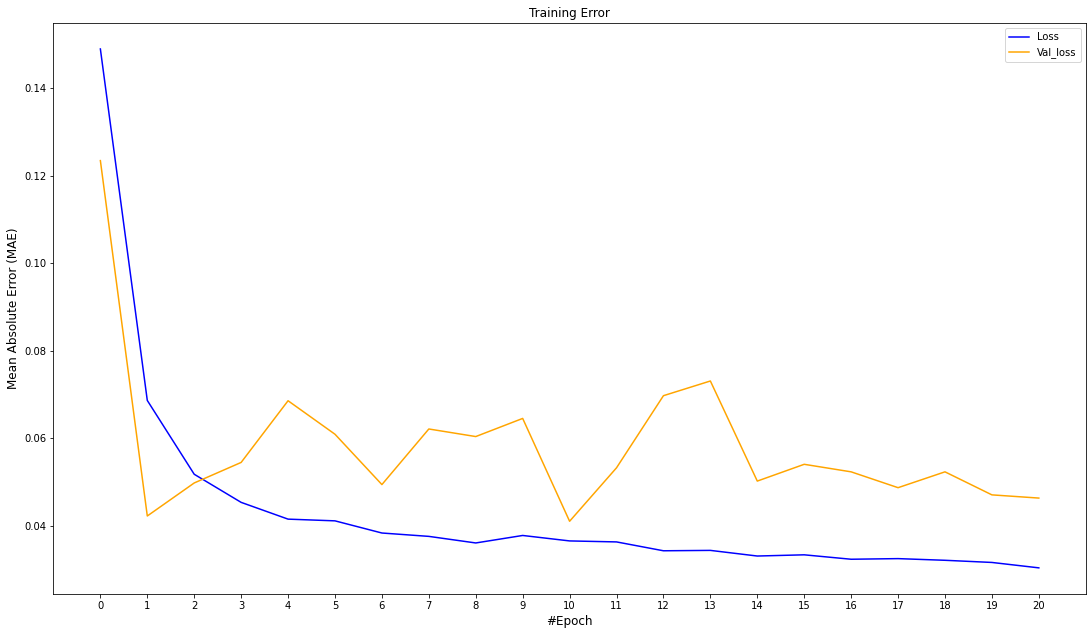

In [ ]:
plot_loss_and_val_loss(hist_of_BTC_with_social_media_included)

<p> It worths to be mentioned that here is the first time that we can observe the validation loss to be higher than the training loss.</p>

<p>Now, we should define a new function with different invert transform in order to plot the close value predictions.</p>

In [121]:
def plot_actual_against_ranged_prediction_with_min_max_scaler(model, initial_data, test_set, split_date_val, close_scaler):
  pred_prices = model.predict(LSTM_val_in)[:-pred_range][::pred_range] #Normalized predictions
  pred_prices_shape = pred_prices.shape
  normalized_pred_prices = (pred_prices.copy()).reshape(-1)
  pred_prices = pred_prices.reshape(-1, 1)

  #Apply inverse transformation
  pred_prices = close_scaler.inverse_transform(pred_prices)
  pred_prices = pred_prices.reshape(pred_prices_shape)
  pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F", "#A569BD", "#45B39D"]

  fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

  ax1.plot((initial_data[initial_data['Date'] > split_date_val][window_len:])['Date'],
          test_set['BTC_Close'][window_len:], label='Actual values', color='b')

  for i, pred in enumerate(pred_prices):

      if i < pred_range: #Print label=predicted for the first time

          ax1.plot(((initial_data[initial_data['Date'] > split_date_val][window_len:])['Date'])[
                  (i * pred_range):((i * pred_range) + pred_range)],
                  pred, color=pred_colors[i % pred_range], label='Predicted')

      else: #Dont print label=predicted again

          ax1.plot(((initial_data[initial_data['Date'] > split_date_val][window_len:])['Date'])[
                  (i * pred_range):((i * pred_range) + pred_range)],
                  pred, color=pred_colors[i % pred_range])

  ax1.set_title('Test Set: 5 Timepoint Predictions', fontsize=13)
  ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
  ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})

  ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})
  fig.set_size_inches(18.5, 10.5)
  plt.show()

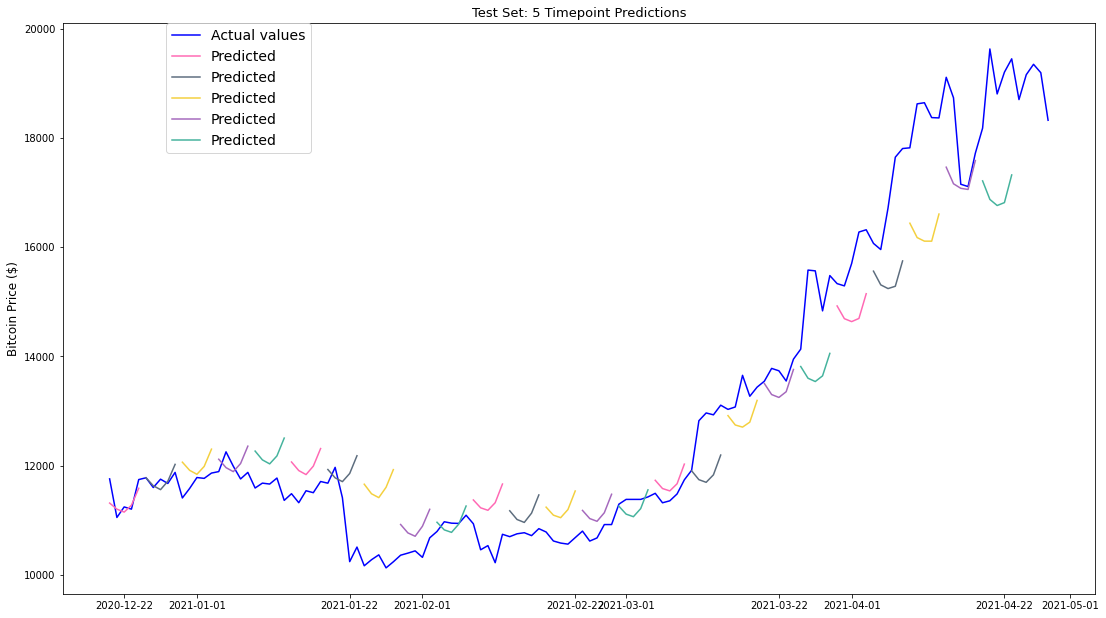

In [ ]:
plot_actual_against_ranged_prediction_with_min_max_scaler(model_with_social, btc_sm_and_mi_combined_ds, validation_set_with_social, split_date_val, close_scaler_with_social)

<p> As we still see, the results are not really well, in terms of predicting the actual value. The thing however is that even if we do not achieve to predict the accurate value, we follow correct the up and down movement. </p>
<p> Let's try the same experiment without the social media data. </p>

In [132]:
training_set_without_social, test_set_without_social, validation_set_without_social, split_date, split_date_val = split_dataset_to_train_and_validation(btc_dataset_with_3_features, percent_train_set, percent_val_set)
LSTM_rangd_train_out_without_social, LSTM_rangd_val_out_without_social, LSTM_rangd_test_out_without_social, LSTM_tr_in_without_social, LSTM_val_in_without_social, LSTM_test_in_without_social, close_scaler_without_social = normalize_in_out_whole_dataset(pred_range, window_len, training_set_without_social, validation_set_without_social, test_set_without_social, ['Close', 'Open', 'High'], 'BTC', ['BTC'])

In [129]:
model_without_social = build_model_with_best_architecture(LSTM_tr_in_without_social)
hist_of_BTC_with_social_media_included = model_without_social.fit(LSTM_tr_in_without_social[:-pred_range], LSTM_rangd_train_out_without_social, validation_data=(LSTM_val_in_without_social[:-pred_range], LSTM_rangd_val_out_without_social), epochs=100, batch_size=64, verbose=0, shuffle=True, workers=8, callbacks=[early_stopping])

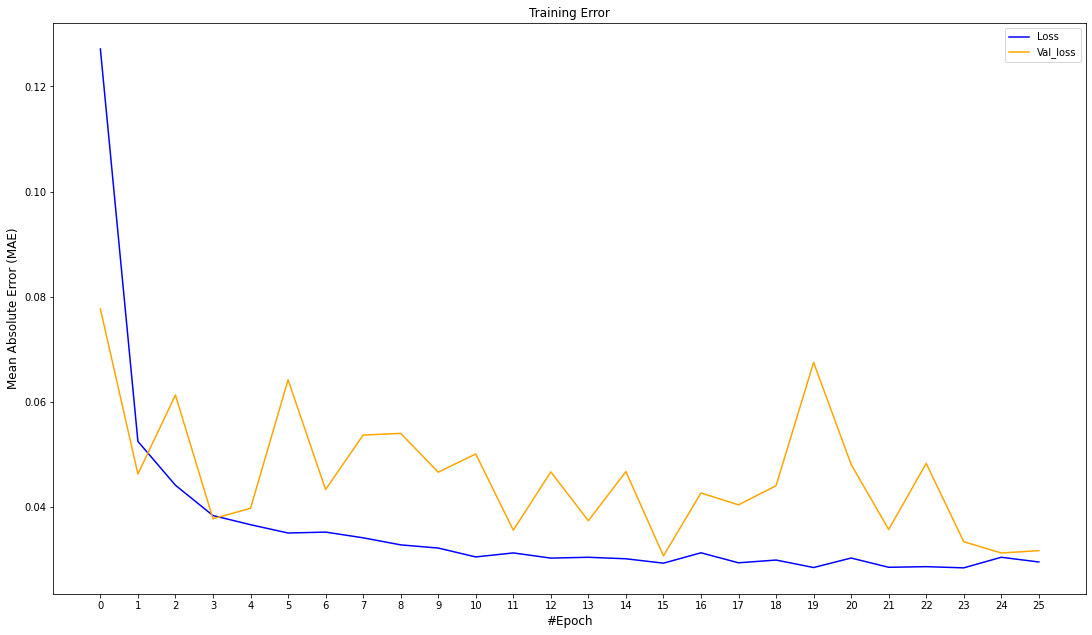

In [ ]:
plot_loss_and_val_loss(hist_of_BTC_with_social_media_included)

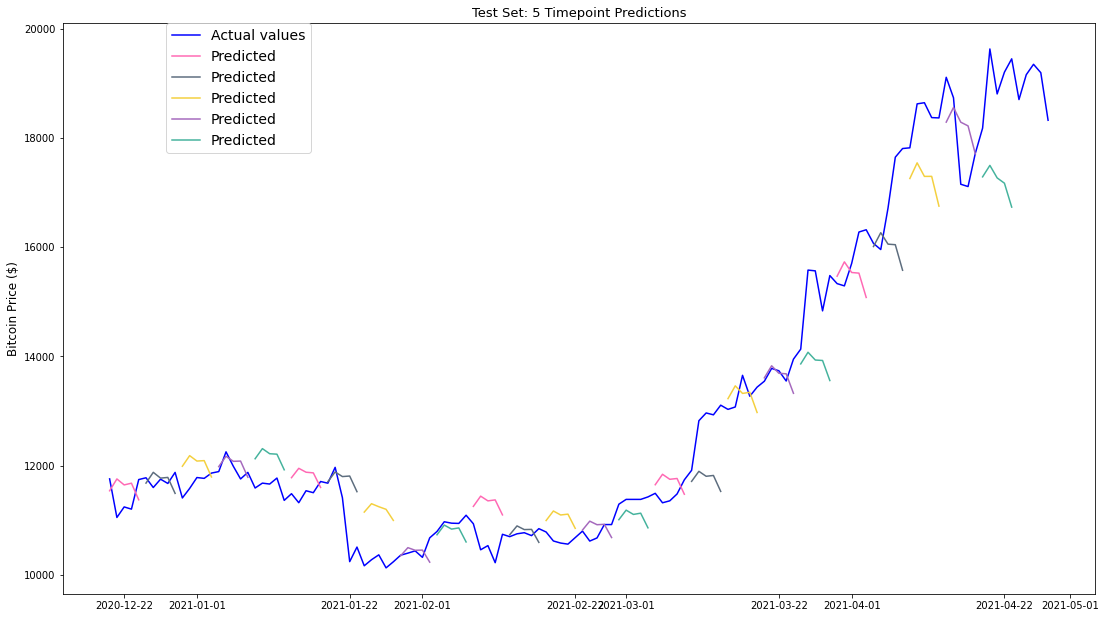

In [ ]:
plot_actual_against_ranged_prediction_with_min_max_scaler(model_without_social, btc_sm_and_mi_combined_ds, validation_set, split_date_val, close_scaler_without_social)

<p>It seems that without social information training and validation, the losses decreases are more alligned than before. Compared to the experiment with the social media feed included, the validation loss is less. Because of this, we conclude that the social media feed instead of helping the model to perform better, it "confuses" it.</p>
<p> By observing the two prediction diagrams, we see that even if the predictions we do, are not really close to the actual prices, the trend they follow seems to be.  Because of MAE, does not have the abillity to describe this trend pattern, we will transform the problem into classification.</p>

Before appling this alteration of the problem, we should examined if the above assumption is true by performing predictions in test set and measure the MAE.

In [133]:
#Get predictions for test set utilizing the model trained with only BTC and specific social media features
scaled_pred_prices_with_social = (model_with_social.predict(LSTM_test_in_with_social)[:-pred_range][::pred_range])
mae_losses_of_model_with_social = tf.keras.losses.mean_absolute_error(LSTM_rangd_test_out_with_social[:-pred_range][::pred_range], scaled_pred_prices_with_social[:-1])
avg_mae_with_social_model = np.sum(mae_losses_of_model_with_social)/len(mae_losses_of_model_with_social)

In [135]:
#Get predictions for test set utilizing the model trained with only BTC and without social features
scaled_pred_prices_without_social = (model_without_social.predict(LSTM_test_in_without_social)[:-pred_range][::pred_range])
mae_losses_of_model_without_social = tf.keras.losses.mean_absolute_error(LSTM_rangd_test_out_without_social[:-pred_range][::pred_range], scaled_pred_prices_without_social[:-1])
avg_mae_without_social_model = np.sum(mae_losses_of_model_without_social)/len(mae_losses_of_model_without_social)

In [137]:
print('Average MAE for test set using model trained with only BTC data and specific social media features: '+str(avg_mae_with_social_model))
print('Average MAE for test set using model trained with only BTC and without social media features: '+str(avg_mae_without_social_model))

Average MAE for test set using model trained with only BTC data and specific social media features: 0.9083200836181641
Average MAE for test set using model trained with only BTC and without social media features: 0.2821459452311198


Indeed, the results based on the test set are in line with the above hypothesis that the model trained without social media data outweighs the one trained with them, even if these social media features are carefully selected. So, from now on we will not use them again. Also, we should state that for the rest of this work we will employ normalization based on MinMax scaler which appears to reverse validation and training loss curves positions (with MinMax scaler validation loss curve is above but not far from training loss curve).    

<h1>Section 6<h1>
<h2> Classification problem</h2>
<p>In order the problem to be transformed into classification we will define labels for the classification task. If a close value <i>p(t)</i> of the target coin <i>p</i> in a current date <i>t</i> is greater or equal than the 99% of the average close value <i>99% * avg(p(t))</i> of the last <i>W</i> days, meaning a period of days [(t-W), W], then this is a positive label (pos), else it is a negative label (neg). In a more formal way:

if: p(t) >= 99% avg(p(t)), where avg(p(t)) = sum(p(t-i))[for i in range(1, W)], then <i>pos</i>

else: <i>neg</i>

This kind of labels will be created for <i>pred_range</i> (<i>D</i>) days ahead for every <i>pred_range</i> (<i>D</i>) days. This classification setting was adopted from paper [2] in order to apply our models in a well study experimentation setting.

So, the number of output nodes of the Neural Network will be equal to pred_range*2 (D*2), because for each day it has to be decided which of the nodes of 1 and 0 is the correct class. Therefore, for each sample to be predicted there will be the following classes: class_day(1)_pos, class_day(1)_neg, class_day(2)_pos, class_day(2)_neg, ..., class_day(pred_range)_pos, class_day(pred_range)_neg.

This means that for each sample to be predicted, we should keep as the predicted label of each day the one with the greater probability among class_day(i)_pos, class_day(i)_neg. </p>

Now, we should define the functions with which will plot our results later. We need one for F1-macro score curves and another one for the confusion matrices.

In [4]:
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix

In [5]:
def create_F1_macro_plot(rangd_h, target_cn = 'BTC', metric='f1_score'):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(25, 10))

    ax1.plot(rangd_h.epoch, rangd_h.history[metric], color='b', label='F1_macro')
    ax1.plot(rangd_h.epoch, rangd_h.history['val_'+metric], color='orange', label='Val_F1_macro')
    ax1.set_xticks(range(0, len(rangd_h.epoch)))
    ax1.set_title('F1 macro score')
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_xlabel('#Epoch', fontsize=12)
    fig.set_size_inches(18.5, 10.5)
    plt.legend()
    plt.show()

In [6]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

def create_conf_matrix(prds, LSTM_ranged_validation_outs, trgt_coin, pretrain_model_coin):
    
    #Convert one_hot_representations to numeric(0 or 1) labels
    y_preds = []
    for i in range(prds.shape[0]):
        if np.round(prds[i]).tolist() == [1, 0]:
            y_preds.append(1)
        else:
            y_preds.append(0)

    y_true = []
    for i in range(LSTM_ranged_validation_outs.shape[0]):
        if np.round(LSTM_ranged_validation_outs[i]).tolist() == [1, 0]:
            y_true.append(1)
        else:
            y_true.append(0)

    
    #Calculate confusion matrix
    cm = confusion_matrix(y_true, y_preds)
    

    labels = ['Decrease', 'Increase']
    df_cm = pd.DataFrame(cm, index = labels,
                      columns = labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.xlabel("Predicted", fontsize=30)
    plt.ylabel("Actuals", fontsize=30) 
    plt.title(trgt_coin + ' predictions using pretrained model with '+pretrain_model_coin+ ' data', fontsize=20)

Then, the fuctions of inputs and outputs data should be set again in order to produce the right outputs labels that are neccessary for this kind of problem (classification).

In [58]:
def normalize_in_out(prd_range, wind_len, tr_set, val_set, tst_set, feats, coin_targ, crypto_list):
    
    
    #Scaling

    scaler = MinMaxScaler(feature_range=(0, 1)) #Scaler for all columns
    
    
    tr_set = tr_set.drop(['Date'], axis=1)
    #transformed_tr_set_values = np.log(tr_set.values)#((tr_set.values**(-3))-1)/-3
    #transformed_tr_set_values[transformed_tr_set_values == -inf] = 0
    train_scaled_data = pd.DataFrame(scaler.fit_transform(tr_set.values), columns=tr_set.columns, #scaler.fit_transform(transformed_tr_set_values)
                                     index=tr_set.index) #Training set fit and transform

    val_set = val_set.drop(['Date'], axis=1) #Keep initial validation set to use average of month close values
    #transformed_val_set_values = np.log(val_set.values)#((val_set.values**(-3))-1)/-3
    #transformed_val_set_values[transformed_val_set_values == -inf] = 0
    val_scaled_data = pd.DataFrame(scaler.transform(val_set.values), columns=val_set.columns, #scaler.transform(transformed_val_set_values)
                                  index=val_set.index) #Validation set just transform

    tst_set = tst_set.drop(['Date'], axis=1) #Keep initial test set to use average of month close values
    #transformed_tst_set_values = np.log(tst_set.values)#((tst_set.values**(-3))-1)/-3
    #transformed_tst_set_values[transformed_tst_set_values == -inf] = 0
    test_scaled_data = pd.DataFrame(scaler.transform(tst_set.values), columns=tst_set.columns, #scaler.transform(transformed_tst_set_values)
                                   index=tst_set.index) #Test set just tranform

    
    all_feats = tr_set.columns #Get all features
    feats = [crypto+"_"+feat for crypto in crypto_list for feat in feats] #Get the features in the appropriate format 
                                                                          #(e.g 'Close' --> 'BTC-USD_Close')
    
    
    #Normalize training inputs
    LSTM_tr_in = []
    for i in range(len(train_scaled_data) - wind_len):
        tmp_set = train_scaled_data[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        LSTM_tr_in.append(tmp_set)
    
    #Transform from DataFrame to numpy array
    LSTM_tr_in = [np.array(LSTM_tr_i) for LSTM_tr_i in LSTM_tr_in]
    LSTM_tr_in = np.array(LSTM_tr_in)
    
    
    #Normalize validation inputs
    LSTM_val_in = []
    for i in range(len(val_scaled_data) - wind_len):
        tmp_set = val_scaled_data[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        LSTM_val_in.append(tmp_set)
        
    #Transform from DataFrame to numpy array
    LSTM_val_in = [np.array(LSTM_val_i) for LSTM_val_i in LSTM_val_in]
    LSTM_val_in = np.array(LSTM_val_in)
    
    
    #Normalize test inputs
    LSTM_test_in = []
    for i in range(len(test_scaled_data) - wind_len):
        tmp_set = test_scaled_data[i:(i + wind_len)].copy() 
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        LSTM_test_in.append(tmp_set)
    
    
    #Transform from DataFrame to numpy array
    LSTM_test_in = [np.array(LSTM_test_i) for LSTM_test_i in LSTM_test_in]
    LSTM_test_in = np.array(LSTM_test_in)
    
    
    #Create LSTM outputs labels for training. Each output is corresponded to the days which are going to 
    #be predicted (pred_range)
    LSTM_rangd_train_out = []
    for i in range(wind_len, len(train_scaled_data[coin_targ+'_Close']) - prd_range):
        
        labels = [] #Create a list with pred_range*2 1s and 0s according with the true value of each class
                    #It is obvious that of a day is pos, it cannot be also negative. So, the ground truth of each
                    #day classes it should be 0,1 or 1,0.
        
        for j in range(i, i+prd_range):
            
            if tr_set[coin_targ+'_Close'][j] >= (tr_set[coin_targ+'_mean_month_Close'][j])*0.99: 
                labels.extend([1, 0])
                
            else:
                labels.extend([0, 1])
        
        
        LSTM_rangd_train_out.append(labels)

    LSTM_rangd_train_out = np.array(LSTM_rangd_train_out)
    
    
    #Create LSTM outputs labels for validation. Each output is corresponded to the days which are going to 
    #be predicted (pred_range)    
    LSTM_rangd_val_out = []
    
    val_set = val_set.reset_index().drop(['index'], axis=1) #Reset index to start from 0
    
    
    for i in range(wind_len, len(val_scaled_data[coin_targ+'_Close']) - prd_range):
        
        labels = []
        
        for j in range(i, i+prd_range):
            
            if val_set[coin_targ+'_Close'][j] >= (val_set[coin_targ+'_mean_month_Close'][j])*0.99: 
                labels.extend([1, 0])
            
            else:
                labels.extend([0, 1])
            
        LSTM_rangd_val_out.append(labels)
    
    LSTM_rangd_val_out = np.array(LSTM_rangd_val_out)
    
    
    #Create LSTM outputs labels for test. Each output is corresponded to the days which are going to 
    #be predicted (pred_range)    
    LSTM_rangd_test_out = []
    
    tst_set = tst_set.reset_index().drop(['index'], axis=1) #Reset index to start from 0
    
    for i in range(wind_len, len(test_scaled_data[coin_targ+'_Close']) - prd_range):
        
        labels = []
        
        for j in range(i, i+prd_range):
            
            if tst_set[coin_targ+'_Close'][j] >= (tst_set[coin_targ+'_mean_month_Close'][j])*0.99: 
                labels.extend([1, 0])
            
            else:
                labels.extend([0, 1])
            
        LSTM_rangd_test_out.append(labels)
    
    LSTM_rangd_test_out = np.array(LSTM_rangd_test_out)
    
    
    return LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_rangd_test_out, LSTM_tr_in, LSTM_val_in, LSTM_test_in

In [11]:
btc_dataset_with_3_features = dataset_creation(['BTC', 'ETH'])
training_set, test_set, val_set, split_date, split_date_val = split_dataset_to_train_and_validation(btc_dataset_with_3_features, 0.8, 0.5)

In [12]:
pred_range = 5
window_len = 10

In [14]:
LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_rangd_test_out, LSTM_tr_in, LSTM_val_in, LSTM_test_in = normalize_in_out(pred_range, window_len, training_set, val_set, test_set,  ['Close', 'Open', 'High'], 'BTC', ['BTC', 'ETH'])

In [15]:
pip install tensorflow_addons

     |████████████████████████████████| 686kB 28.0MB/s 


<p>In this point of our experiments, we tried out instead of LSTM the GRU cells because in paper [2] is proposed to exploit them in order to achieve better performances in short datasets which consist of sequences like cryptocurrencies historical data.</p>
<p> After experiments, we validated that using the GRUs we achieved better performances in terms now of F1 score. Particularly we used the F1 macro because of the problem is multilabel.</p>
<p> Also we should mention that now we use sigmoid activation function for the output layer instead of the linear we were using so far. We chose sigmoid instead of softmax, because for each input we should have <i>pred_range</i> correct outputs (which is the multilabel problem definition).</p>
<p> For loss measurement binary crossentropy will be used. </p>

In [35]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM,GRU
from keras.layers import Dropout
import tensorflow as tf
import tensorflow_addons as tfa

def build_and_train_model(inputs, outputs, output_size, val_inputs, val_outputs, GRU_neurons, first_dense_neurons, 
                          first_dropout, second_dense_neurons, second_dropout, prd_range, epochs, 
                          batch_size, early_stop_patience, 
                          activ_func="sigmoid", dropout=0.25, loss="binary_crossentropy", optimizer="adam"):

    def build_model():

        model = Sequential()
        model.add(GRU(GRU_neurons, input_shape=(inputs.shape[1], inputs.shape[2])))

        model.add(Dense(units=first_dense_neurons))
        
        model.add(Dropout(first_dropout))
        
        model.add(Dense(units=second_dense_neurons))

        model.add(Dropout(second_dropout))
        
        model.add(Dense(units=output_size))
        
        model.add(Activation(activ_func))
        
        #optimizer = tf.keras.optimizers.Adam(
        #learning_rate=0.00001)

        model.compile(loss=loss, optimizer=optimizer, 
                      metrics=[tfa.metrics.F1Score(average='macro', num_classes=output_size)])
        return model

    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    
    rnged_btcoin_model = build_model()
    rnged_hist = rnged_btcoin_model.fit(inputs[:-prd_range], outputs,
                                       validation_data=(val_inputs[:-prd_range], val_outputs), callbacks=[stop_early],
                                        epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True, workers=8)
    
    return rnged_btcoin_model, rnged_hist

<p>In this GRU model architecture we used, the same sequencial model as before, but instead of the LSTM, now we have the GRU. </p>
<p> Also, the parameters are different and more specifically we have:
<ul>
  <li>20 input GRU neurons</li>
  <li>256 first dense neurons</li>
  <li>40% percentage of first dropout</li>
  <li>128 second dense neurons</li>
  <li>25% percentage of second dropout</li>
</ul>
</p>

In [18]:
rnged_btcoin_model, rnged_hist = build_and_train_model(LSTM_tr_in, LSTM_rangd_train_out, 
                                                               pred_range*2, LSTM_val_in,
                                                               LSTM_rangd_val_out, GRU_neurons=20, 
                                                               first_dense_neurons=256, first_dropout=0.4, 
                                                               second_dense_neurons=128, second_dropout=0.25, 
                                                               prd_range=pred_range, epochs=500, batch_size=64,
                                                               early_stop_patience=10)

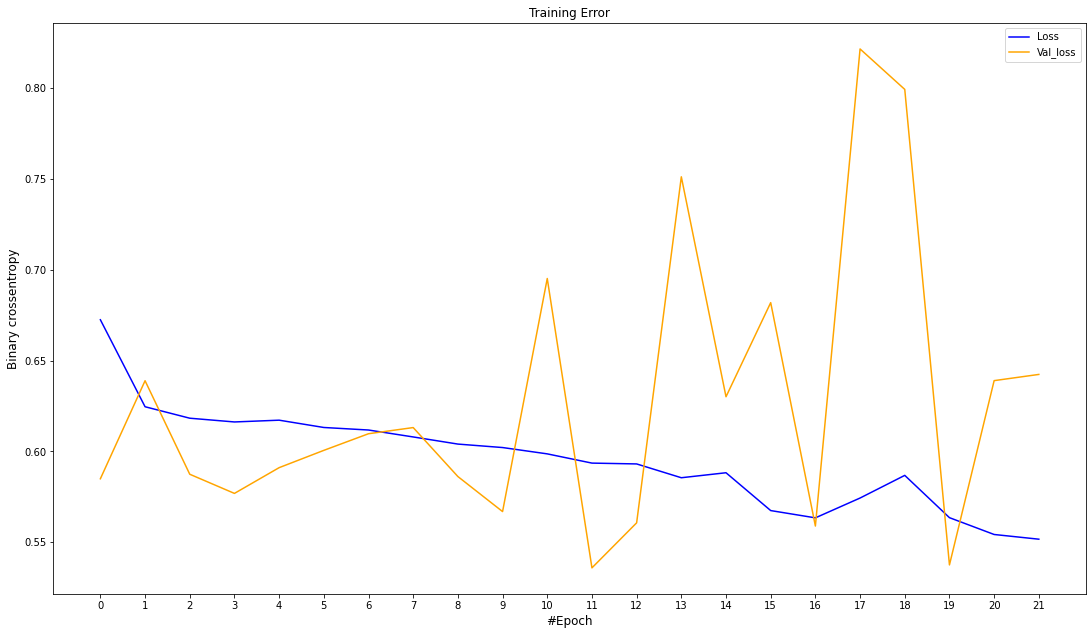

In [ ]:
plot_loss_and_val_loss(rnged_hist, 'Binary crossentropy')

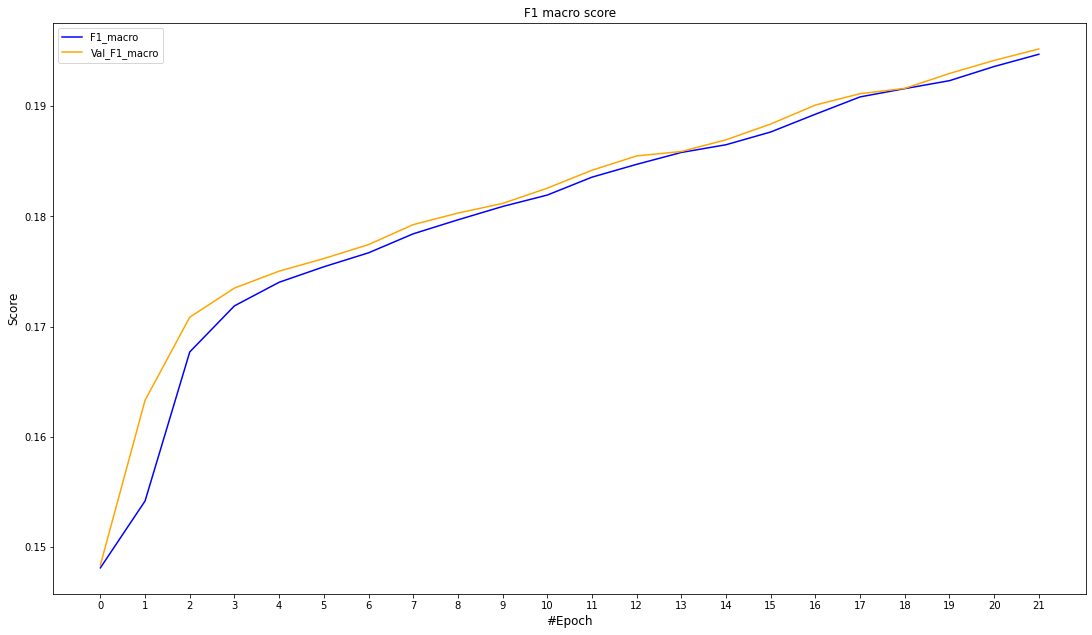

In [ ]:
create_F1_macro_plot(rnged_hist)

<p> Even if the losses seems to move together (validation loss have high oscilation), we do not achieve a great F1 macro score (19%).</p>
<p> After many trials with different architectures and sets of features, we didn't succeed in increasing the performance (in terms of the using metrics) and for this reason we decreased the complexity of the problem to 1 day ahead prediction.</p>

In [36]:
pred_range = 1
LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_rangd_test_out, LSTM_tr_in, LSTM_val_in, LSTM_test_in = normalize_in_out(pred_range, window_len, training_set, val_set, test_set,  ['Close', 'Open', 'High'], 'BTC', ['BTC', 'ETH'])

In [37]:
rnged_btcoin_model, rnged_hist = build_and_train_model(LSTM_tr_in, LSTM_rangd_train_out, 
                                                               pred_range*2, LSTM_val_in,
                                                               LSTM_rangd_val_out, GRU_neurons=20, 
                                                               first_dense_neurons=256, first_dropout=0.4, 
                                                               second_dense_neurons=128, second_dropout=0.25, 
                                                               prd_range=pred_range, epochs=500, batch_size=64,
                                                               early_stop_patience=10)

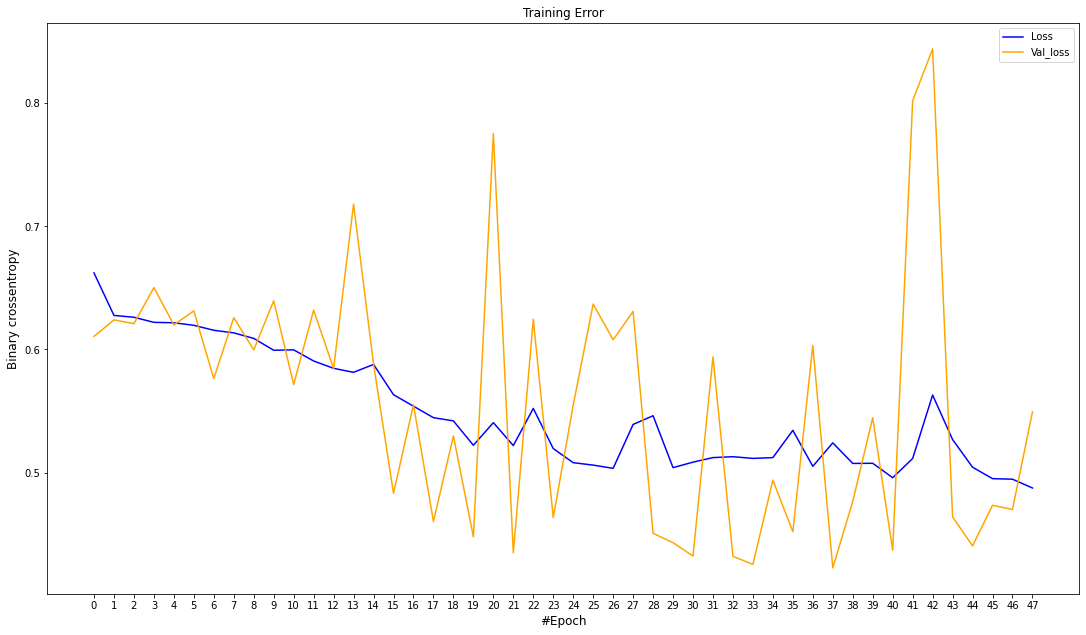

In [ ]:
plot_loss_and_val_loss(rnged_hist, 'Binary crossentropy')

<p>Again we see the losses to decrease together, however in this experiment the model performed a quite better result in F1 macro score (66%).</p>
<p> Also it worths to mention that the F1 macros of train and validation are almost identical. </p>

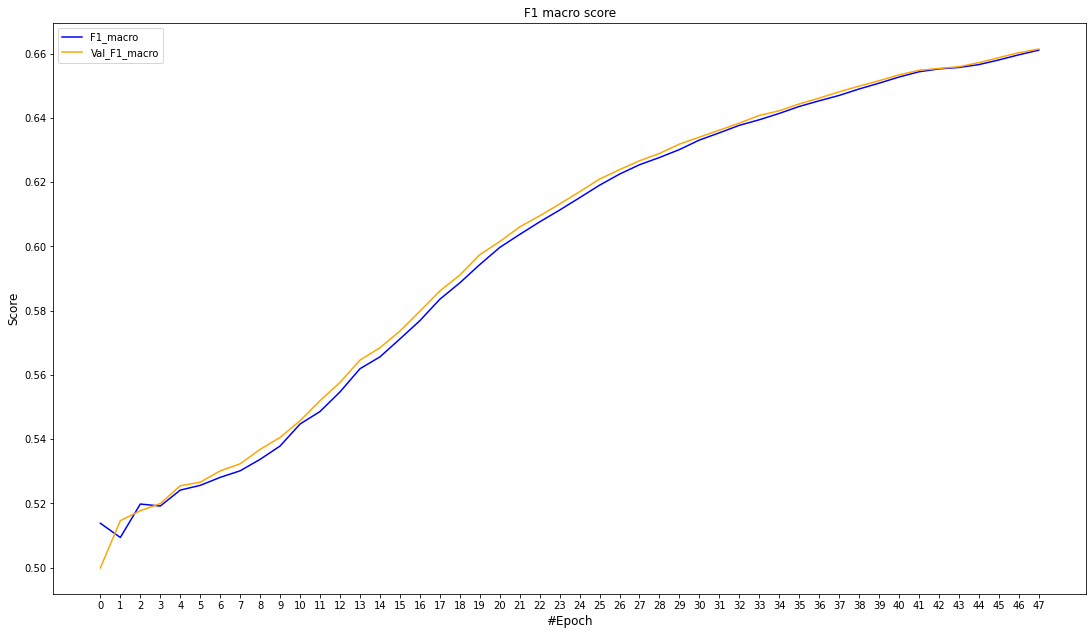

In [ ]:
create_F1_macro_plot(rnged_hist)

In [151]:
  prds = rnged_btcoin_model.predict(LSTM_val_in)[:-pred_range][::pred_range]

In this point, we should define a function which will create a plot where the actual close values will be presented as well as the actual and predicted labels.

In [152]:
def plot_actual_against_prediction_for_classification(ds, prds, p_range, w_length, lstm_val_input, lstm_val_out, val_inp, s_date, s_date_val, predicted_column, figure_title = ''):
  #Get predictions which are scaled

  #Get first index to use for plots
  first_row = val_inp.index[0]
  
  """
  #We should exclude first row because we dont have a prediction for it
  predictions_dataFrame = predictions_dataFrame.drop([first_row+i for i in range(window_len+1)], axis = 0)
  new_first_row = predictions_dataFrame.index[0]"""
  

  y_preds = []
  for i in range(prds.shape[0]):
      if np.round(prds[i]).tolist() == [1, 0]:
          y_preds.append(1)
      else:
          y_preds.append(0)

  """temp_preds_dataFrame = pd.DataFrame(np.array(y_preds), columns=['Predictions'])
  temp_preds_dataFrame.index = predictions_dataFrame.index
  
  preds_dataFrame = pd.concat([predictions_dataFrame, temp_preds_dataFrame], axis=1)"""
    
      
  y_true = []
  for i in range(lstm_val_out.shape[0]):
      if np.round(lstm_val_out[i]).tolist() == [1, 0]:
          y_true.append(1)
      else:
          y_true.append(0)

  pred_colors = ['red', 'green', 'black', 'cyan']
  fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
  ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:]),
         val_inp[predicted_column][w_length:], label='Actual values', color='b')

  percent_dif_for_dots_plot = 0.015
  count_incr = 0
  count_decr = 0
  actual_count_incr = 0
  actual_count_decr = 0
  for i, pred in enumerate(y_preds):#(preds_dataFrame['Predictions'].values):
      
      actual_value = val_inp[predicted_column][first_row+w_length+i]

      ####Predicted labels########
      if pred == 0: 
          
          if count_decr == 0: #Print label='Decrease predicted' for the first time
            ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                    actual_value+(actual_value*percent_dif_for_dots_plot), color=pred_colors[0], label='Decrease Predicted', marker='o')
            count_decr += 1
            
          else:

            ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                    actual_value+(actual_value*percent_dif_for_dots_plot), color=pred_colors[0], marker='o')
            count_decr += 1

          
      elif pred == 1:   
          
          
          if count_incr == 0: #Print label='Increase predicted' for the first time
            
            ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                    actual_value+(actual_value*percent_dif_for_dots_plot), color=pred_colors[1], label='Increase Predicted', marker='o')
            
            count_incr += 1
        
          else:
            
            ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                    actual_value+(actual_value*percent_dif_for_dots_plot), color=pred_colors[1], marker='o')
            count_incr += 1


      #####Actual labels#######
      if y_true[i] == 0: 
          
          if actual_count_decr == 0: #Print label='Decrease predicted' for the first time
            ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                    actual_value-(actual_value*percent_dif_for_dots_plot), color=pred_colors[2], label='Decrease Actual', marker='o')
            actual_count_decr += 1
            
          else:

            ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                    actual_value-(actual_value*percent_dif_for_dots_plot), color=pred_colors[2], marker='o')
            actual_count_decr += 1

          
      elif y_true[i] == 1:   
          
          
          if actual_count_incr == 0: #Print label='Increase predicted' for the first time
            
            ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                    actual_value-(actual_value*percent_dif_for_dots_plot), color=pred_colors[3], label='Increase Actual', marker='o')
            
            actual_count_incr += 1
        
          else:
            
            ax1.plot(pd.to_datetime(ds.loc[(ds['Date'] >= s_date) & (ds['Date'] < s_date_val)]['Date'][w_length:])[(i * p_range):((i * p_range) + p_range)],
                    actual_value-(actual_value*percent_dif_for_dots_plot), color=pred_colors[3], marker='o')
            actual_count_incr += 1


        


          
  ax1.set_title('Validation Set: Increase/Decrease Predictions', fontsize=13)
  ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
  ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
  ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})
  fig.suptitle(figure_title, fontsize=20)
  fig.set_size_inches(18.5, 10.5)
  plt.show()

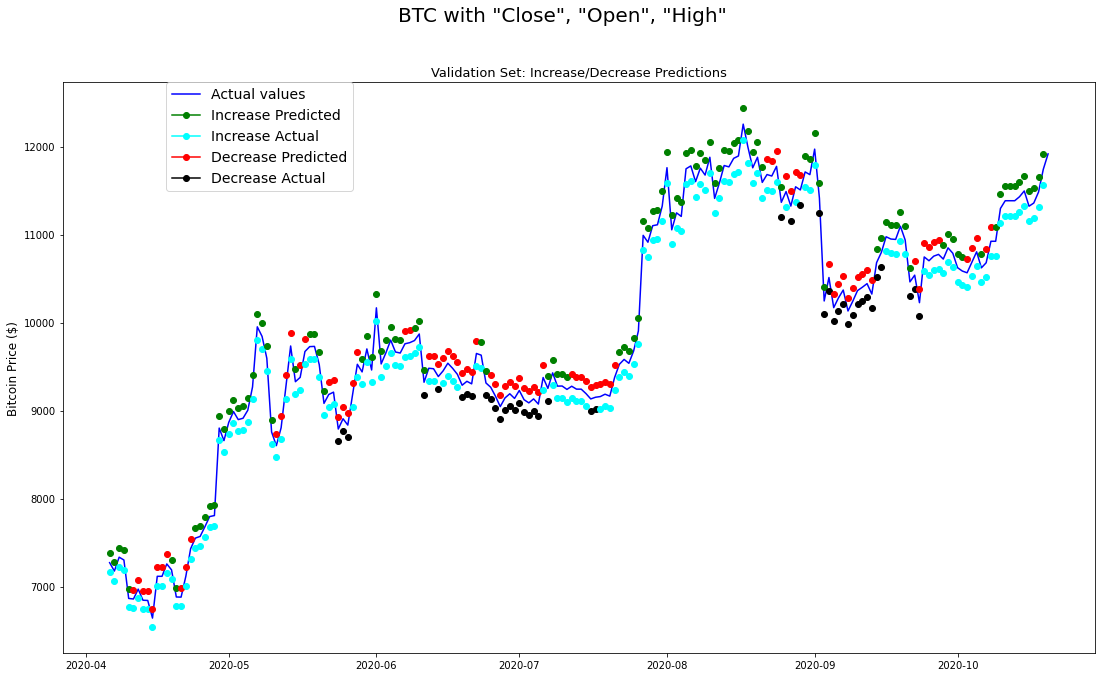

In [ ]:
plot_actual_against_prediction_for_classification(btc_dataset_with_3_features, prds, pred_range, window_len, LSTM_val_in, LSTM_rangd_val_out, val_set, split_date, split_date_val, 'BTC_Close', 'BTC with "Close", "Open", "High"')

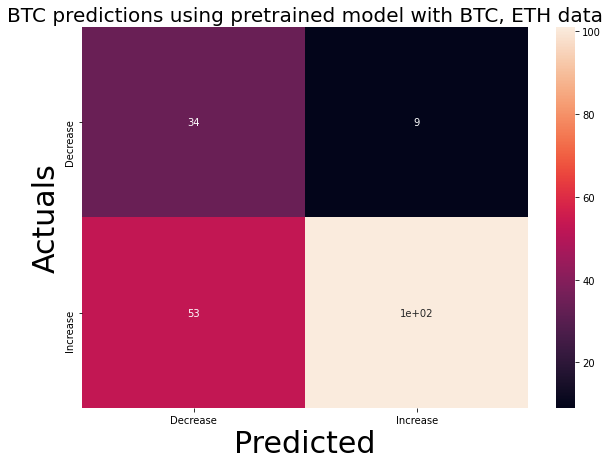

In [ ]:
create_conf_matrix(prds, LSTM_rangd_val_out, 'BTC', 'BTC, ETH')

<p> Using the validation matrix, we can validate that the results of this combination are quite well.</p>
<p> More specifically the model have predicted correct:</p>

*   2/3 increases
*   3/4 decreases

<p> These percentages are higher (68% accuracy) than the 1/2 (0.5%), which is the random's classification accuracy score.</p>
<p>We should also carry out predictions using test set to examined the generalization ability of the model.</p> 

In [38]:
#Get predictions for test set and print f1 macro score 
test_preds = (rnged_btcoin_model.predict(LSTM_test_in)[:-pred_range][::pred_range])
metric_f1 = tfa.metrics.F1Score(average='macro', num_classes=2*pred_range)
metric_f1.update_state(LSTM_rangd_test_out[:-pred_range][::pred_range], test_preds[:-1])
result = metric_f1.result()
result.numpy()

0.4600551

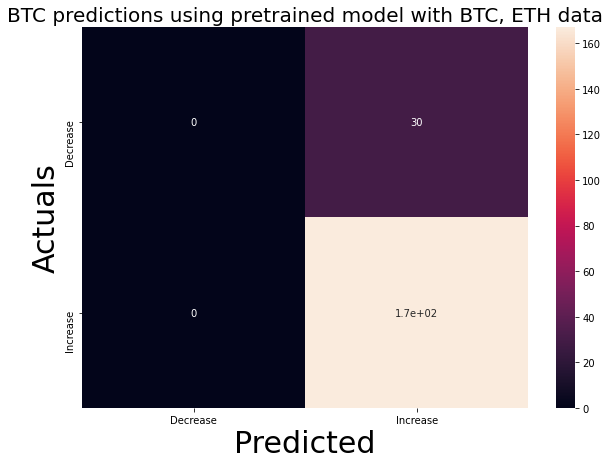

In [39]:
create_conf_matrix(test_preds, LSTM_rangd_test_out, 'BTC', 'BTC, ETH')

Obviously, we cannot conclude that the general ability of this model is to manage an F1 macro score of 68% as in validation set. Based on test set, it seems that the model is biased to predict all close value fluactuations as increases. A possible explanation for this behaviour is that there are much more samples of increase than the ones decrease which means that the dataset is highly unbalanced. This indication is apparent both in confusion matrices for the results of validation and test set. 

After applying *weight decay* regularization method in order to impose the model to update its weights in a different way, avoiding to learn 'noisy' patterns, the results were not better.

Another possible interpetation could the quick pattern changes of cryptocurrencies close value variations through time which does not allow the model to learn certain patterns. For this reason, in the next section we are going to harness a more sophisticated model architecture as last effort towards to the improvement of predictions' accuracy.

<h1>Section 7<h1>
<h2>Concatenated models and transfer learning</h2>
<h3>Concatenated models</h3>
<p>In this section, we will try a different model's architecture. We will train multiple sequencial models with different coins and then we will combine them into one model using concatenated layer. It should be noticed that we tried this also in the regression problem, but the results were not as good.</p>

The concept of concatenated layers each one of which uses historical data form different cryptocurrencies is described in work [1]. The model architecture that was used by its authors, is presented at the below image: 

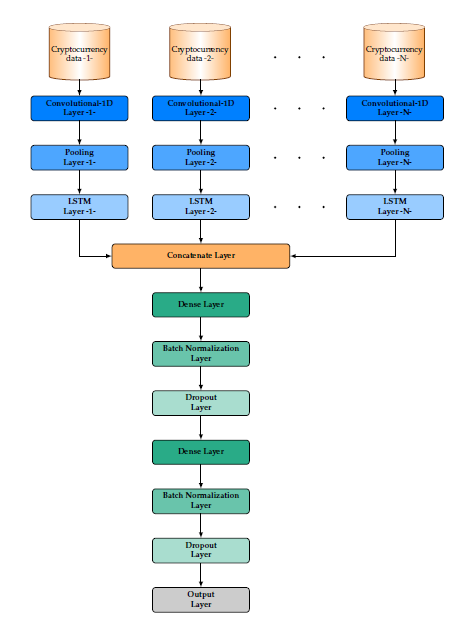

<p>We performed several experimentations based on this archicture and implemented various alternatives. Finally, we figured out that the Batch Normalization and CNN layers harmed the model capabilities for this particular problem, thus we excluded them. In addition, we changed LSTM cells with the GRU ones as they indicated to lead in a greater performance.</p>
<p>To exhibit our work, we will start by defining two different models for BTC and ETH and then we will combine them into one. We have to define again the functions for the dataset creation and the normalization of the inputs and outputs in order to be returned a dictionary with all cryprocurrencies data separetally.</p>

In [41]:
def dataset_creation_for_concatenate(crypto_list):
    datasets = {} #Store all datasets with market information here
    datasets_list = {'BTC' : btc_url, 'ETH' : eth_url, 'ADA' : ada_url}
    min_dates = {} #Store all minimum dates here
    max_dates = {} #Store all maximum dates here
    
    #Get market information for each coin from the corresponding csv
    for dataset_name, url in datasets_list.items():
        if (dataset_name) in crypto_list:
            datasets[dataset_name] = pd.read_csv(url) 
            datasets[dataset_name]['Date'] = pd.to_datetime(datasets[dataset_name]['Date']) #Dataset from yahoo
                                                                                        #is stored ia .csv file.
                
            datasets[dataset_name].rename(columns={'Adj Close':dataset_name+'Adj_Close'}) #Space will cause troubles
                
            
            
            #There are a few missing values, so let fill them with the previous value
            datasets[dataset_name].fillna(method='ffill', inplace=True)

            #Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:
            kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
              'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])
              }

            datasets[dataset_name] = datasets[dataset_name].assign(**kwards)
            
            datasets[dataset_name].fillna(-1, inplace=True) #Fill possible NaN close_off_high values with -1
                                                            #Because NaN values caused by (0/0)-1
            

            first_date = pd.to_datetime(datasets[dataset_name]['Date'][0])
            min_dates[dataset_name]=first_date
            
            last_date = pd.to_datetime(datasets[dataset_name]['Date'].iloc[-1])
            max_dates[dataset_name] = last_date
            

    max_date = max(min_dates.values(), key=lambda v: v)
    min_date = min(max_dates.values(), key=lambda v: v)

    #Drop all the data which are prior to max_date and later to min_date
    for dataset in datasets:
        datasets[dataset] = datasets[dataset][(datasets[dataset]['Date'] >= max_date) & 
                                              (datasets[dataset]['Date'] <= min_date)]
  

    #Compute the average and standard deviation of 'Close' value for the last 7-days and 30-days(month): 
    for dataset in datasets:

        temp = datasets[dataset].copy()

        #Drop the first 30 days to be able to compute average and standard deviation of month for the rows of the table
        temp = temp[29:]

        temp['mean_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).mean()

        temp['mean_month_Close'] = datasets[dataset]['Close'].rolling(window=30).mean()

        temp['std_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).std()

        temp['std_month_Close'] = datasets[dataset]['Close'].rolling(window=30).std()

        datasets[dataset] = temp.copy()
        


    #Rename the columns and concatenate all datasets to one 
    count = 0
    for dataset in datasets:

        datasets[dataset] = datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        datasets[dataset] = datasets[dataset].rename(columns={dataset+'_Date': 'Date'})                                                   
        
        if count == 0:
            
            date_col = (datasets[dataset]['Date'].reset_index()).drop(['index'], axis=1)
            
            
        datasets[dataset] = ((datasets[dataset].drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1)    
                    
    
    #Concatenate market and social datasets for each each cryptocurrency separately 
    
    cryprocurrencies_data = {}
    for dataset in datasets:
        cryprocurrencies_data[dataset] = pd.concat([date_col, datasets[dataset]], axis=1)
          
   
    return cryprocurrencies_data

In [43]:
def split_data_conc(perc_train_set, perc_val_set, dict_currency_data):
        
        dict_tr_set = {}
        dict_val_set = {}
        dict_tst_set = {}
        for coin, currency_data in dict_currency_data.items():
            
            #Compute the date to split the dataset into training and validation_test set based on 'perc_train_set'
            splt_date_train = currency_data.iloc[round(currency_data.shape[0] * perc_train_set)]['Date']

            #Split the dataset into trainning and validation_test set
            tr_set, val_tst_set = currency_data[currency_data['Date'] < splt_date_train], \
                             currency_data[currency_data['Date'] >= splt_date_train]

            #Compute the date to split the val_tst_set into validation and test set based on 'perc_val_set'
            splt_date_val = val_tst_set.iloc[round(val_tst_set.shape[0] * perc_val_set)]['Date']

            #Split the val_tst_set into validation and test set        
            val_set, tst_set = val_tst_set[val_tst_set['Date'] < splt_date_val], \
                                val_tst_set[val_tst_set['Date'] >= splt_date_val]
            
            
            
            #Drop 'Date' column and save train, validation and test sets of each coin at the corresponding dictionary 
            tr_set = ((tr_set.drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1)
            dict_tr_set[coin] = tr_set
            
            val_set = ((val_set.drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1)
            dict_val_set[coin] = val_set
            
            tst_set = ((tst_set.drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1)
            dict_tst_set[coin] = tst_set
        
        return dict_tr_set, dict_val_set, dict_tst_set, splt_date_train, splt_date_val

In [57]:
from sklearn.preprocessing import MinMaxScaler
def normalize_in_out_conc(prd_range, wind_len, dict_tr_set, dict_val_set, dict_tst_set, target_feats, coin_targ, crypto_list):
    
    dict_LSTM_tr_in = {}
    dict_LSTM_val_in = {}
    dict_LSTM_test_in = {}
    
    
    for crypto in crypto_list:
        
        tr_set = dict_tr_set[crypto]
        val_set = dict_val_set[crypto]
        tst_set = dict_tst_set[crypto]
        
        
        scaler = MinMaxScaler(feature_range=(0, 1)) #Scaler for all columns for each cryptocurrency
        
        train_scaled_data = pd.DataFrame(scaler.fit_transform(tr_set.values), columns=tr_set.columns, 
                                         index=tr_set.index) #Training set fit and transform
        
        
        if crypto == coin_targ:
            close_scaler = MinMaxScaler(feature_range=(0, 1)) #Scaler for 'Close' column only
            close_scaler.fit((tr_set[coin_targ+'_Close'].values).reshape(-1, 1)) #Training set fit only to 'Close' 
                                                                                 #values of target coin
            coin_target_train_scaled_data = train_scaled_data.copy()    
                

        val_scaled_data = pd.DataFrame(scaler.transform(val_set.values), columns=val_set.columns,
                                      index=val_set.index) #Validation set just transform
        
        if crypto == coin_targ:
                coin_target_val_scaled_data = val_scaled_data.copy()

        
        test_scaled_data = pd.DataFrame(scaler.transform(tst_set.values), columns=tst_set.columns,
                                       index=tst_set.index) #Test set just tranform
        
        if crypto == coin_targ:
                coin_target_test_scaled_data = test_scaled_data.copy()
        
        
        all_feats = tr_set.columns #Get all features
        feats = [crypto+"_"+feat for feat in target_feats] #Get the features in the appropriate format 
                                                           #(e.g 'Close' --> 'BTC-USD_Close')
        
        
        #Create LSTM inputs for training
        LSTM_tr_in = []
        for i in range(len(train_scaled_data) - wind_len):
            tmp_set = train_scaled_data[i:(i + wind_len)].copy()

            for col in all_feats:
                if col not in feats:
                    tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

            LSTM_tr_in.append(tmp_set)

        #Transform from DataFrame to numpy array
        LSTM_tr_in = [np.array(LSTM_tr_i) for LSTM_tr_i in LSTM_tr_in]
        LSTM_tr_in = np.array(LSTM_tr_in)
        
        dict_LSTM_tr_in[crypto] = LSTM_tr_in


        #Create LSTM inputs for validation
        LSTM_val_in = []
        for i in range(len(val_scaled_data) - wind_len):
            tmp_set = val_scaled_data[i:(i + wind_len)].copy()

            for col in all_feats:
                if col not in feats:
                    tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

            LSTM_val_in.append(tmp_set)

        #Transform from DataFrame to numpy array
        LSTM_val_in = [np.array(LSTM_val_i) for LSTM_val_i in LSTM_val_in]
        LSTM_val_in = np.array(LSTM_val_in)
        
        dict_LSTM_val_in[crypto] = LSTM_val_in

        
        
        #Normalize test inputs
        LSTM_test_in = []
        for i in range(len(test_scaled_data) - wind_len):
            tmp_set = test_scaled_data[i:(i + wind_len)].copy() 

            for col in all_feats:
                if col not in feats:

                    tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

            LSTM_test_in.append(tmp_set)


        #Transform from DataFrame to numpy array
        LSTM_test_in = [np.array(LSTM_test_i) for LSTM_test_i in LSTM_test_in]
        LSTM_test_in = np.array(LSTM_test_in)
        
        dict_LSTM_test_in[crypto] = LSTM_test_in 
    
    
    tr_set = dict_tr_set[coin_targ].copy()
    val_set = dict_val_set[coin_targ].copy()
    tst_set = dict_tst_set[coin_targ].copy()
    
    #Create LSTM outputs labels for training. Each output is corresponded to the days which are going to 
    #be predicted (pred_range)
    LSTM_rangd_train_out = []
    for i in range(wind_len, len(coin_target_train_scaled_data[coin_targ+'_Close']) - prd_range):
        
        labels = [] #Create a list with pred_range*2 1s and 0s according with the true value of each class
                    #It is obvious that of a day is pos, it cannot be also negative. So, the ground truth of each
                    #day classes it should be 0,1 or 1,0.
        
        for j in range(i, i+prd_range):
            
            if tr_set[coin_targ+'_Close'][j] >= (tr_set[coin_targ+'_mean_month_Close'][j])*0.99: 
                labels.extend([1, 0])
                
            else:
                labels.extend([0, 1])
        
        
        LSTM_rangd_train_out.append(labels)

    LSTM_rangd_train_out = np.array(LSTM_rangd_train_out)
    
    
    #Create LSTM outputs labels for validation. Each output is corresponded to the days which are going to 
    #be predicted (pred_range)    
    LSTM_rangd_val_out = []
    
    val_set = val_set.reset_index().drop(['index'], axis=1) #Reset index to start from 0
    
    
    for i in range(wind_len, len(coin_target_val_scaled_data[coin_targ+'_Close']) - prd_range):
        
        labels = []
        
        for j in range(i, i+prd_range):
            
            if val_set[coin_targ+'_Close'][j] >= (val_set[coin_targ+'_mean_month_Close'][j])*0.99: 
                labels.extend([1, 0])
            
            else:
                labels.extend([0, 1])
            
        LSTM_rangd_val_out.append(labels)
    
    LSTM_rangd_val_out = np.array(LSTM_rangd_val_out)
    
    
    #Create LSTM outputs labels for test. Each output is corresponded to the days which are going to 
    #be predicted (pred_range)    
    LSTM_rangd_test_out = []
    
    tst_set = tst_set.reset_index().drop(['index'], axis=1) #Reset index to start from 0
    
    for i in range(wind_len, len(coin_target_test_scaled_data[coin_targ+'_Close']) - prd_range):
        
        labels = []
        
        for j in range(i, i+prd_range):
            
            if tst_set[coin_targ+'_Close'][j] >= (tst_set[coin_targ+'_mean_month_Close'][j])*0.99: 
                labels.extend([1, 0])
            
            else:
                labels.extend([0, 1])
            
        LSTM_rangd_test_out.append(labels)
    
    LSTM_rangd_test_out = np.array(LSTM_rangd_test_out)
    
    
    return LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_rangd_test_out, dict_LSTM_tr_in, dict_LSTM_val_in, dict_LSTM_test_in

Let's define model architecture with concatenated layers. There is also a condition where some layers are set to be non-trainable. This will be used thereupon for the transfer learning procedure.

In [45]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
import tensorflow as tf
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import AveragePooling1D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras import Input
import tensorflow_addons as tfa


def build_concatenated_model(coin_list, inputs, output_size, activ_func="sigmoid", loss="binary_crossentropy", 
                 optimizer="adam", pretrained_models = {},  target_coin = ""):
    
    separate_coin_layers = {}
    
    for coin in coin_list:
      separate_coin_layers[coin] = {}
      #Input layer for each coin with each own data
      separate_coin_layers[coin]['input'] = Input(shape=((inputs[coin].shape[1], inputs[coin].shape[2])),
                                                            name=coin)
      if target_coin != "" and coin != target_coin:
        separate_coin_layers[coin]['GRU1'] = pretrained_models[coin](separate_coin_layers[coin]['input'])
        separate_coin_layers[coin]['GRU1'].trainable = False
      else:            
        separate_coin_layers[coin]['GRU1'] = GRU(20)(separate_coin_layers[coin]['input'])#separate_coin_layers[coin]['GRU1'] = GRU(neurGRU1)(separate_coin_layers[coin]['input']) #, input_shape=(inputs[coin].shape[1], inputs[coin].shape[2]) #return_sequences=True
    # Merge all available features into a single large vector via concatenation
    conc_layer_output = Concatenate()([separate_coin_layers[coin]['GRU1'] for coin in coin_list])#conc_layer_output = Concatenate()([separate_coin_layers[coin]['GRU1'] for coin in coin_list])
    
    dense1_output = Dense(units=256, activation='relu')(conc_layer_output)
    
    drop1_dense_out = Dropout(0.1)(dense1_output)
    
    dense2_output = Dense(units=128, activation='relu')(drop1_dense_out)#(dense1_output) 

    final_output = Dense(units=output_size, activation=activ_func)(dense2_output) #(dense2_output)
    
    overall_model = Model([separate_coin_layers[coin]['input'] for coin in coin_list], final_output)
    
    overall_model.compile(loss=loss, optimizer=optimizer,
                          metrics=[tfa.metrics.F1Score(average='macro', num_classes=output_size)])
    return overall_model

In [46]:
pred_range = 1
window_len = 10

In [47]:
ds_for_concatenate = dataset_creation_for_concatenate(['BTC', 'ETH'])
dict_tr_set, dict_val_set, dict_tst_set, splt_date_train, splt_date_val = split_data_conc(0.8, 0.5, ds_for_concatenate)
LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_rangd_test_out, dict_LSTM_tr_in, dict_LSTM_val_in, dict_LSTM_test_in = normalize_in_out_conc(pred_range, window_len, dict_tr_set, dict_val_set, dict_tst_set,  ['Close', 'Open', 'High'], 'BTC', ['BTC', 'ETH'])

In [51]:
conc_model = build_concatenated_model(['BTC', 'ETH'], dict_LSTM_tr_in, pred_range*2)

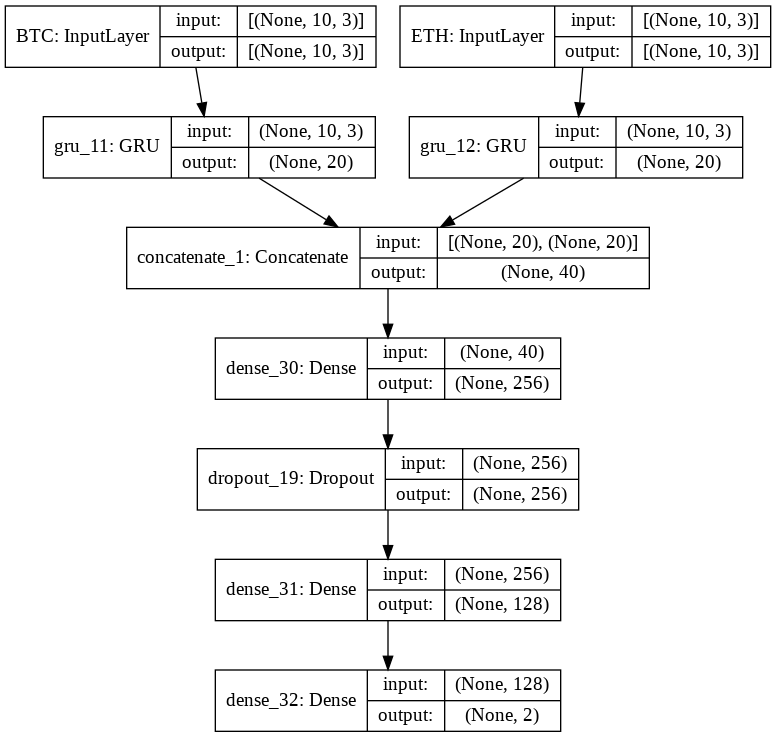

In [ ]:
tf.keras.utils.plot_model(conc_model, show_shapes=True)

In [52]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
conc_model_hist = conc_model.fit(x= {'BTC':dict_LSTM_tr_in['BTC'][:-pred_range], 'ETH':dict_LSTM_tr_in['ETH'][:-pred_range]}, y=LSTM_rangd_train_out, validation_data=({'BTC':dict_LSTM_val_in['BTC'][:-pred_range], 'ETH':dict_LSTM_val_in['ETH'][:-pred_range]}, LSTM_rangd_val_out),
                                 callbacks=[stop_early], epochs=500, batch_size=64, verbose=0, shuffle=True, workers=8)

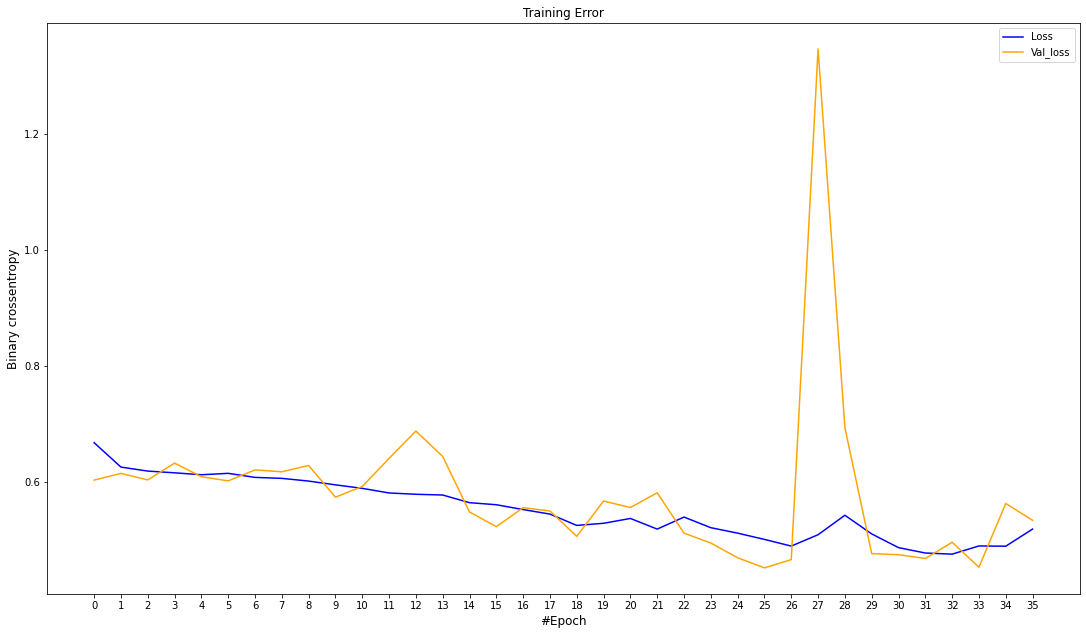

In [ ]:
plot_loss_and_val_loss(conc_model_hist, 'Binary crossentropy')

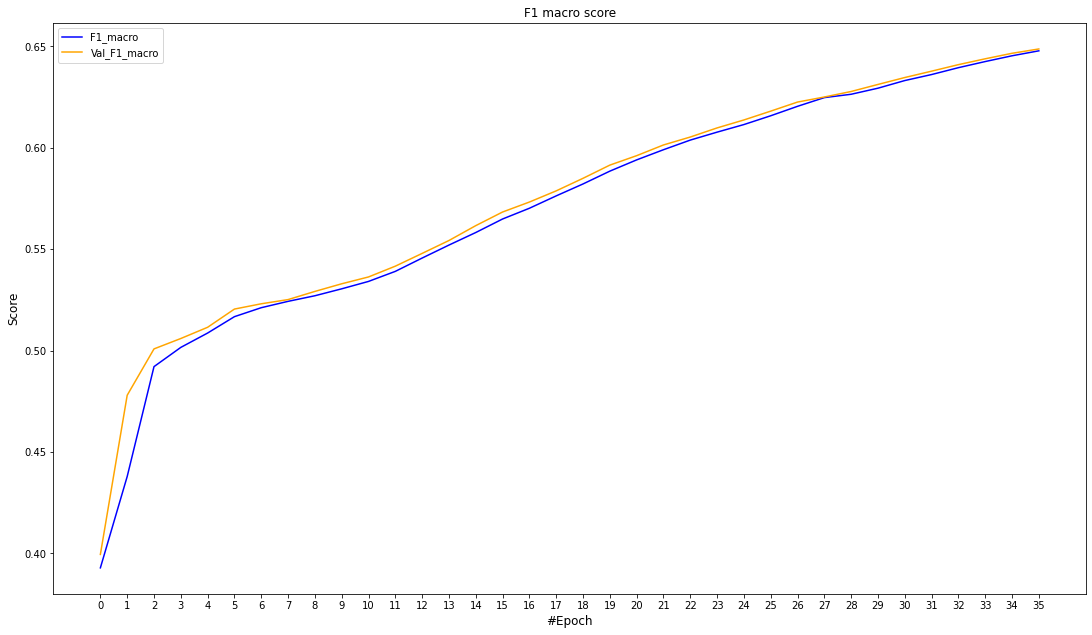

In [ ]:
create_F1_macro_plot(conc_model_hist)

In [ ]:
conc_preds = conc_model.predict({'BTC':dict_LSTM_val_in['BTC'], 'ETH':dict_LSTM_val_in['ETH']})[:-pred_range][::pred_range]

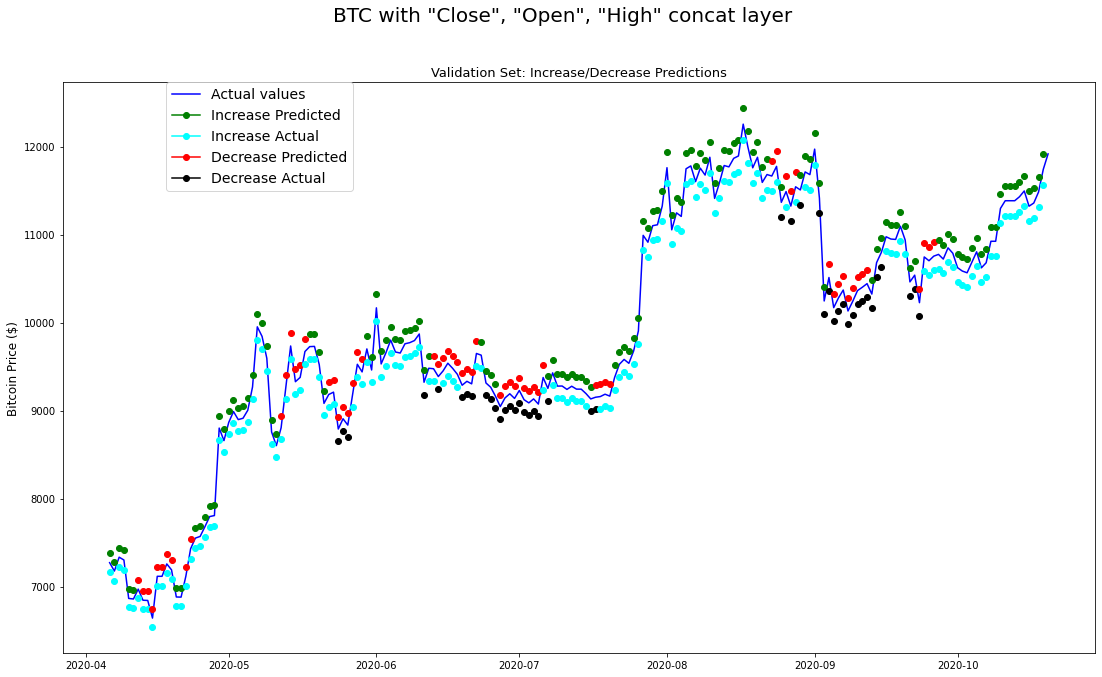

In [ ]:
plot_actual_against_prediction_for_classification(ds_for_concatenate['BTC'], conc_preds, pred_range, window_len, dict_LSTM_val_in['BTC'], LSTM_rangd_val_out, dict_val_set['BTC'], splt_date_train, splt_date_val, 'BTC_Close', 'BTC with "Close", "Open", "High" concat layer')

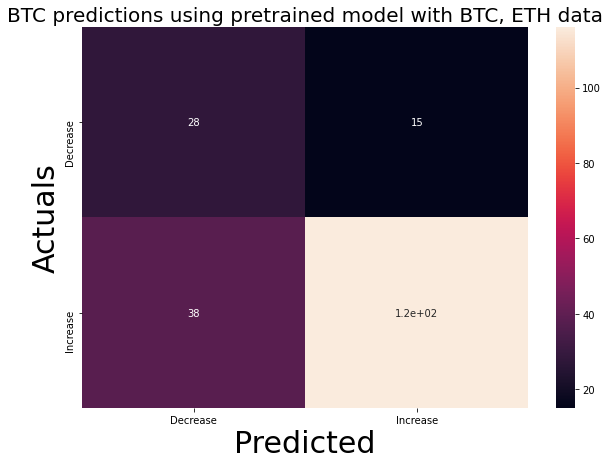

In [ ]:
create_conf_matrix(conc_preds, LSTM_rangd_val_out, 'BTC', 'BTC, ETH')

<p> As we can easily see, the results are not as good. Actually, they are almost the same as the single's GRU layer with the combined dataset. More specifically we can see that the F1 values are almost the same (66-67%).</p>
<p>Now as usually, we have to use the test set in order to obtain a deeper realization of the model prediction abilities.</p>

In [53]:
#Get predictions for test set and print f1 macro score 
test_preds = conc_model.predict({'BTC':dict_LSTM_test_in['BTC'], 'ETH':dict_LSTM_test_in['ETH']})[:-pred_range][::pred_range]
metric_f1 = tfa.metrics.F1Score(average='macro', num_classes=2*pred_range)
metric_f1.update_state(LSTM_rangd_test_out[:-pred_range][::pred_range], test_preds[:-1])
result = metric_f1.result()
result.numpy()

0.4600551

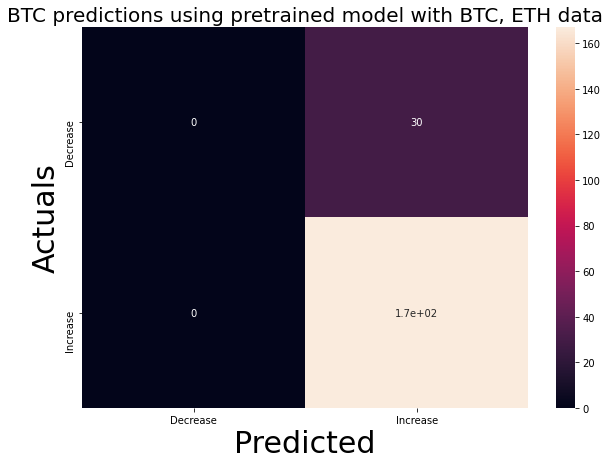

In [54]:
create_conf_matrix(test_preds, LSTM_rangd_test_out, 'BTC', 'BTC, ETH')

As with the previous model architecture, the test set predictions are all considered as increases. Even if this model does not aim to get over this drawback, it might be helpful in transfer learning proccess which is described in the next section.

<h3>Transfer learing</h3>
<p>The benefit of this architecture is that we can pretrain one or more of the sequencial models separately using different coins and then to take advantage of the obtained knowledge in order to make predictions for a coin with less historical data.</p>
<p>We will now try to predict Cardano close price fluctuations, which is a new coin compared to the other ones (Bitcoin and Ethereum). We will first train two sequential models as described in <i>Section 6</i> (1 RNN layer with GRU cells, followed by 3 Dense layers and 2 Dropout layers among them), one with BTC and one with ETH data and then we will transfer these networks' weights into a new model with concatanated layers architecture.</p>
<p> The new model will get trained by having frozen the BTC and ETH GRU's pre-trained layers' weights.</p>

In [59]:
btc_ds = dataset_creation(['BTC'])
btc_training_set, btc_test_set, btc_val_set, btc_split_date, btc_split_date_val = split_dataset_to_train_and_validation(btc_ds, 0.8, 0.5)
btc_LSTM_rangd_train_out, btc_LSTM_rangd_val_out, btc_LSTM_rangd_test_out, btc_LSTM_tr_in, btc_LSTM_val_in, btc_LSTM_test_in = normalize_in_out(pred_range, window_len, btc_training_set, btc_val_set, btc_test_set,  ['Close', 'Open', 'High'], 'BTC', ['BTC'])
btc_model, btc_model_hist = build_and_train_model(btc_LSTM_tr_in, btc_LSTM_rangd_train_out, 
                                                               pred_range*2, btc_LSTM_val_in,
                                                               btc_LSTM_rangd_val_out, GRU_neurons=20, 
                                                               first_dense_neurons=256, first_dropout=0.4, 
                                                               second_dense_neurons=128, second_dropout=0.25, 
                                                               prd_range=pred_range, epochs=500, batch_size=64,
                                                               early_stop_patience=10)

In [60]:
eth_ds = dataset_creation(['ETH'])
eth_training_set, eth_test_set, eth_val_set, eth_split_date, eth_split_date_val = split_dataset_to_train_and_validation(eth_ds, 0.8, 0.5)
eth_LSTM_rangd_train_out, eth_LSTM_rangd_val_out, eth_LSTM_rangd_test_out, eth_LSTM_tr_in, eth_LSTM_val_in, eth_LSTM_test_in = normalize_in_out(pred_range, window_len, eth_training_set, eth_val_set, eth_test_set,  ['Close', 'Open', 'High'], 'ETH', ['ETH'])
eth_model, eth_model_hist = build_and_train_model(eth_LSTM_tr_in, eth_LSTM_rangd_train_out, 
                                                               pred_range*2, eth_LSTM_val_in,
                                                               eth_LSTM_rangd_val_out, GRU_neurons=20, 
                                                               first_dense_neurons=256, first_dropout=0.4, 
                                                               second_dense_neurons=128, second_dropout=0.25, 
                                                               prd_range=pred_range, epochs=500, batch_size=64,
                                                               early_stop_patience=10)

In [70]:
ada_ds = dataset_creation(['ADA'])
ada_training_set, ada_test_set, ada_val_set, ada_split_date, ada_split_date_val = split_dataset_to_train_and_validation(ada_ds, 0.8, 0.5)
ada_LSTM_rangd_train_out, ada_LSTM_rangd_val_out, ada_LSTM_rangd_test_out, ada_LSTM_tr_in, ada_LSTM_val_in, ada_LSTM_test_in = normalize_in_out(pred_range, window_len, ada_training_set, ada_val_set, ada_test_set,  ['Close', 'Open', 'High'], 'ADA', ['ADA'])
ada_model, ada_model_hist = build_and_train_model(ada_LSTM_tr_in, ada_LSTM_rangd_train_out, 
                                                               pred_range*2, ada_LSTM_val_in,
                                                               ada_LSTM_rangd_val_out, GRU_neurons=20, 
                                                               first_dense_neurons=256, first_dropout=0.4, 
                                                               second_dense_neurons=128, second_dropout=0.25, 
                                                               prd_range=pred_range, epochs=500, batch_size=64,
                                                               early_stop_patience=10)

<p> We will first plot the results with a model trained only with ADA history data in order to compare them with the results of the concatenated architecture.</p>

In [ ]:
prds = ada_model.predict(ada_LSTM_val_in)[:-pred_range][::pred_range]

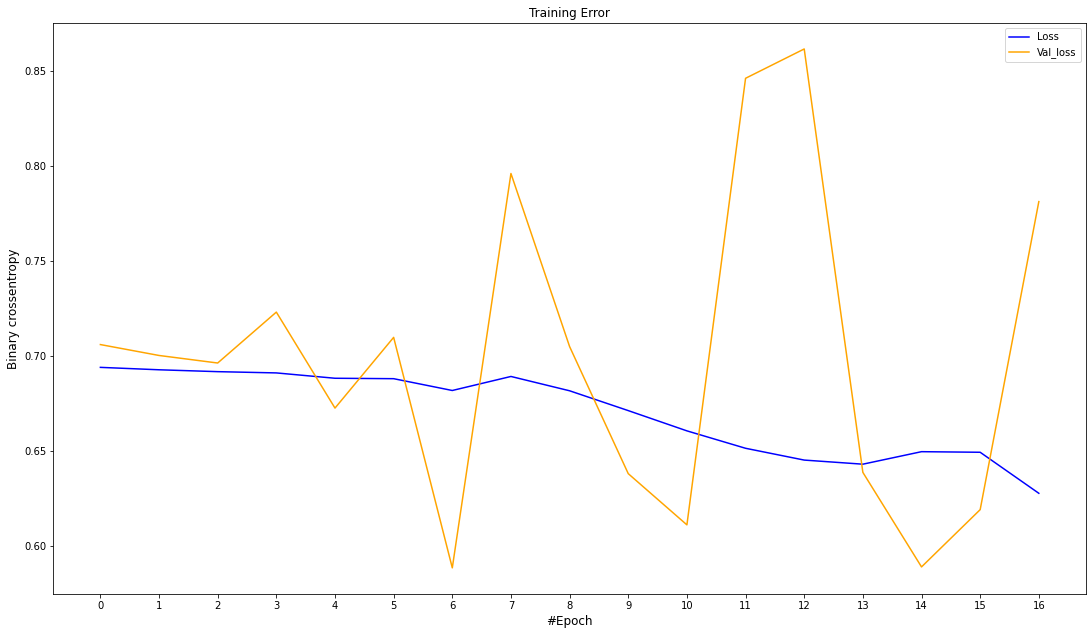

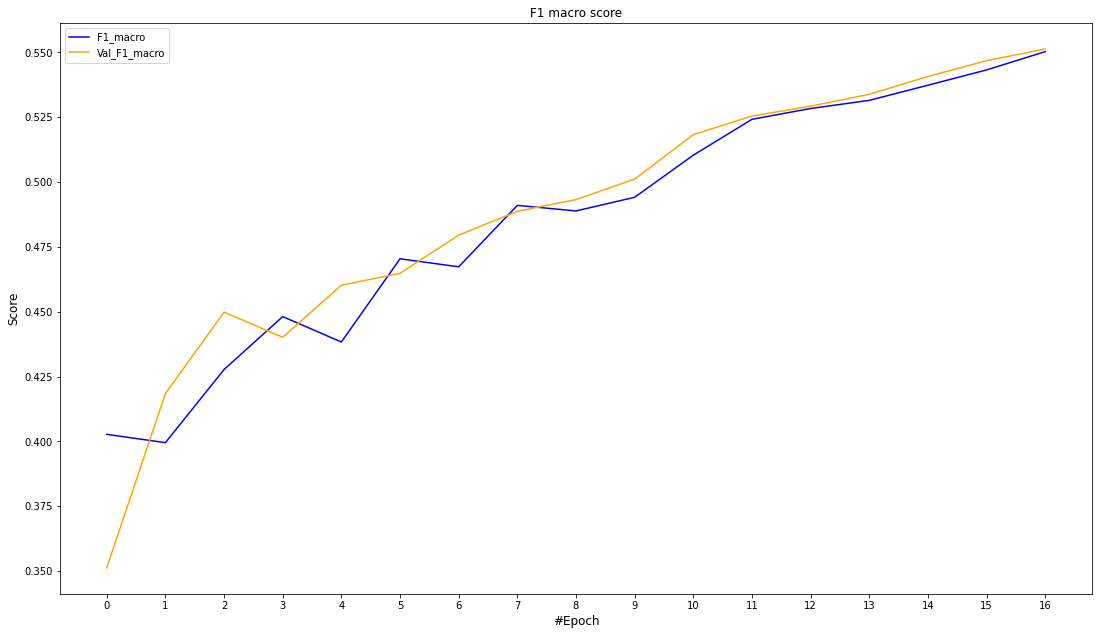

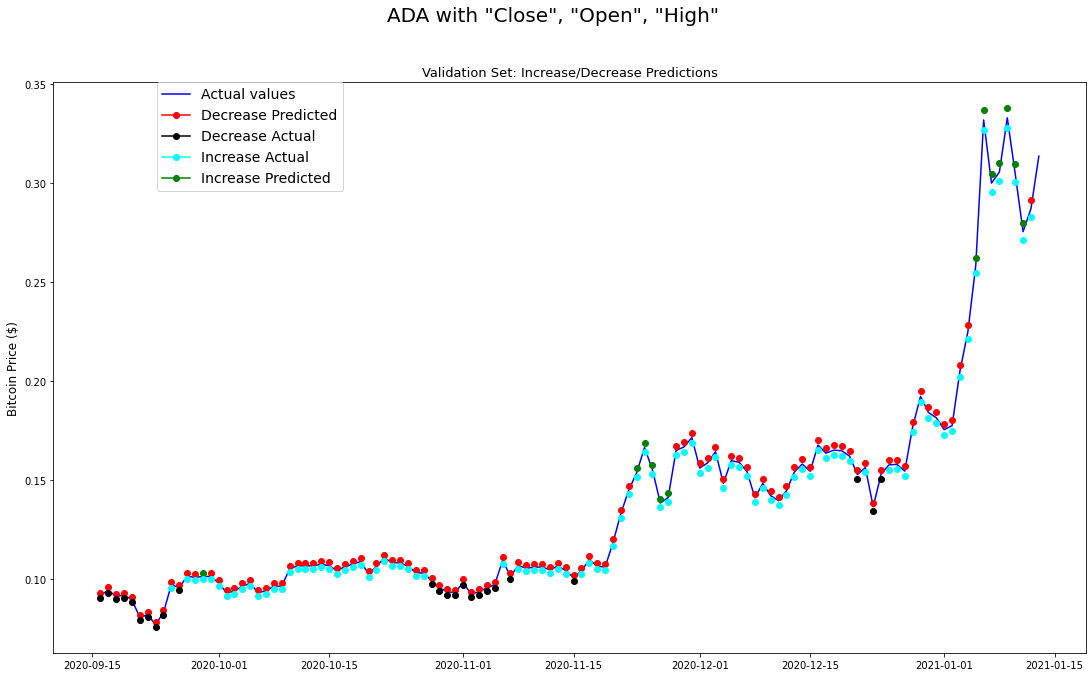

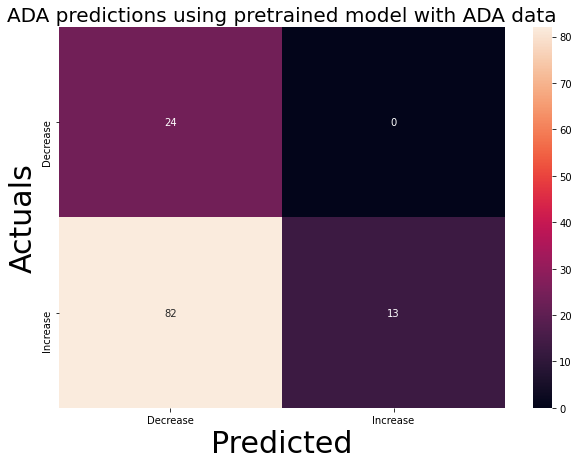

In [ ]:
plot_loss_and_val_loss(ada_model_hist, 'Binary crossentropy')
create_F1_macro_plot(ada_model_hist)
plot_actual_against_prediction_for_classification(ada_ds, prds, pred_range, window_len, ada_LSTM_val_in, ada_LSTM_rangd_val_out, ada_val_set, ada_split_date, ada_split_date_val, 'ADA_Close', 'ADA with "Close", "Open", "High"')
create_conf_matrix(prds, ada_LSTM_rangd_val_out, 'ADA', 'ADA')

In [62]:
pretrained_models = { "BTC" : btc_model.layers[0], "ETH" : eth_model.layers[0]}

In [63]:
ds_for_concatenate_with_transfer_lr = dataset_creation_for_concatenate(['BTC', 'ETH', 'ADA'])
dict_tr_set, dict_val_set, dict_tst_set, splt_date_train, splt_date_val = split_data_conc(0.8, 0.5, ds_for_concatenate_with_transfer_lr)
LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_rangd_test_out, dict_LSTM_tr_in, dict_LSTM_val_in, dict_LSTM_test_in = normalize_in_out_conc(pred_range, window_len, dict_tr_set, dict_val_set, dict_tst_set,  ['Close', 'Open', 'High'], 'ADA', ['BTC', 'ETH', 'ADA'])

In [77]:
conc_model_with_transfer_lr = build_concatenated_model(['BTC', 'ETH', 'ADA'], dict_LSTM_tr_in, pred_range*2, target_coin= "ADA", pretrained_models = pretrained_models)

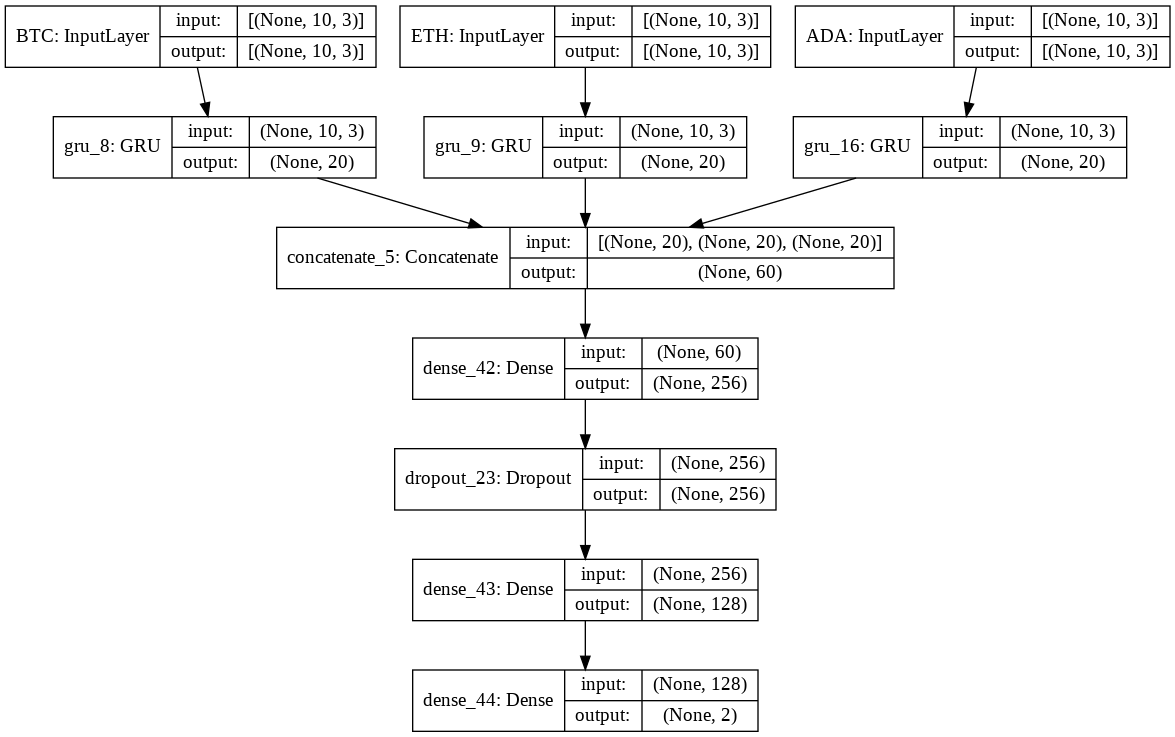

In [ ]:
tf.keras.utils.plot_model(conc_model_with_transfer_lr, show_shapes=True)

In [78]:
epochs = 1000
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
conc_model_hist = conc_model.fit(x= {'BTC':dict_LSTM_tr_in['BTC'][:-pred_range], 'ETH':dict_LSTM_tr_in['ETH'][:-pred_range], 'ADA':dict_LSTM_tr_in['ADA'][:-pred_range]}, y=LSTM_rangd_train_out, validation_data=({'BTC':dict_LSTM_val_in['BTC'][:-pred_range], 'ETH':dict_LSTM_val_in['ETH'][:-pred_range], 'ADA':dict_LSTM_val_in['ADA'][:-pred_range]}, LSTM_rangd_val_out),
                                 callbacks=[stop_early], epochs=500, batch_size=64, verbose=0, shuffle=True, workers=8)

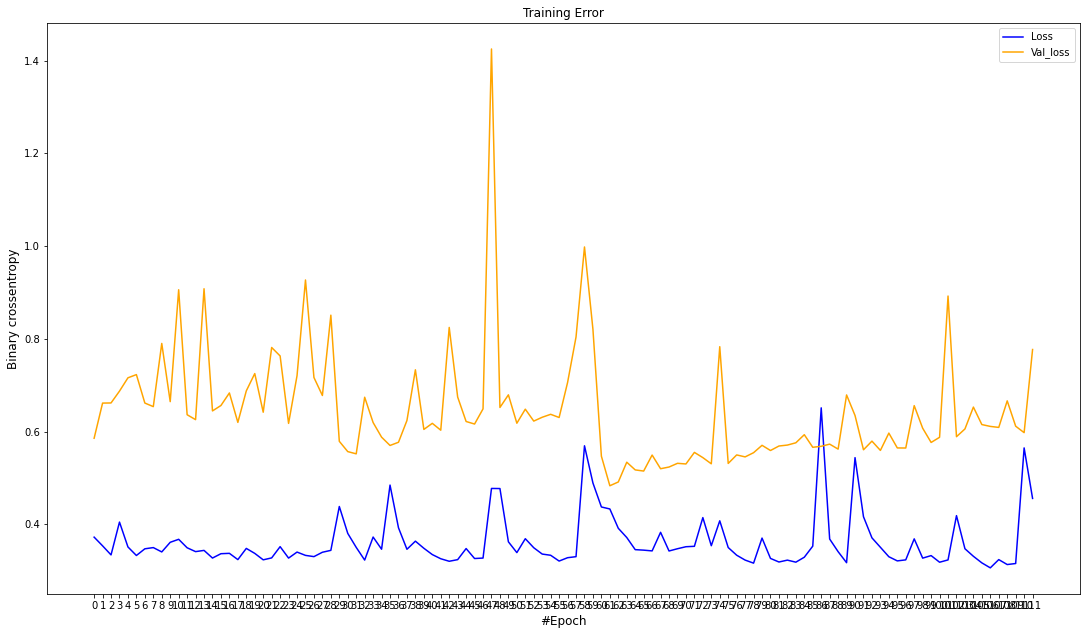

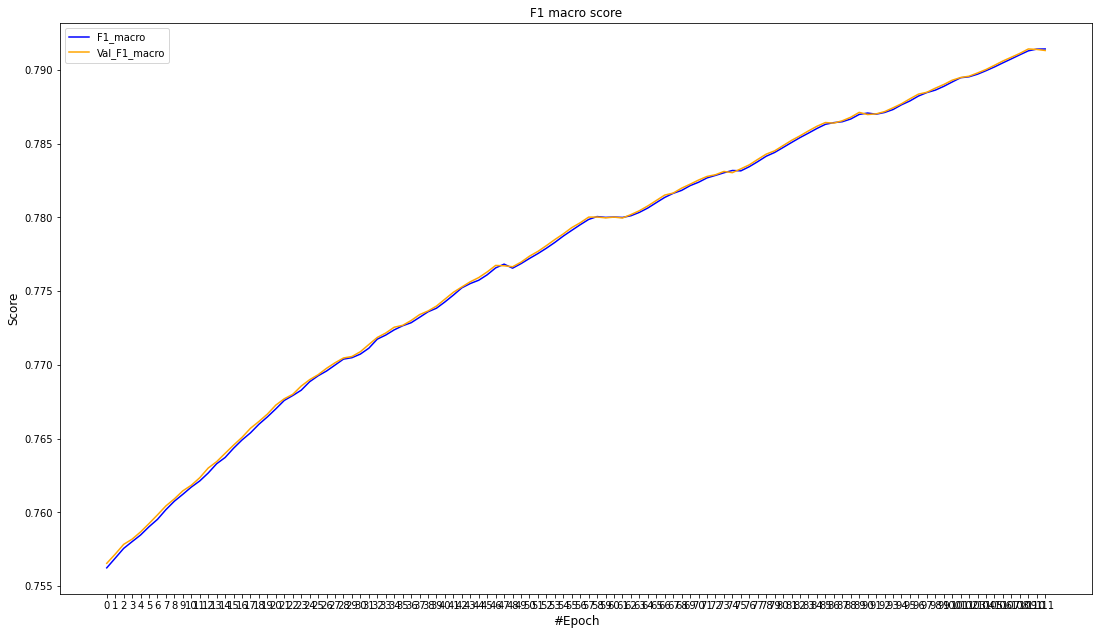

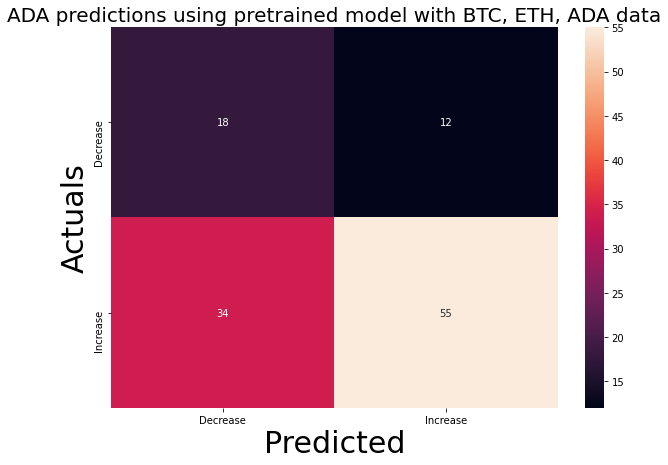

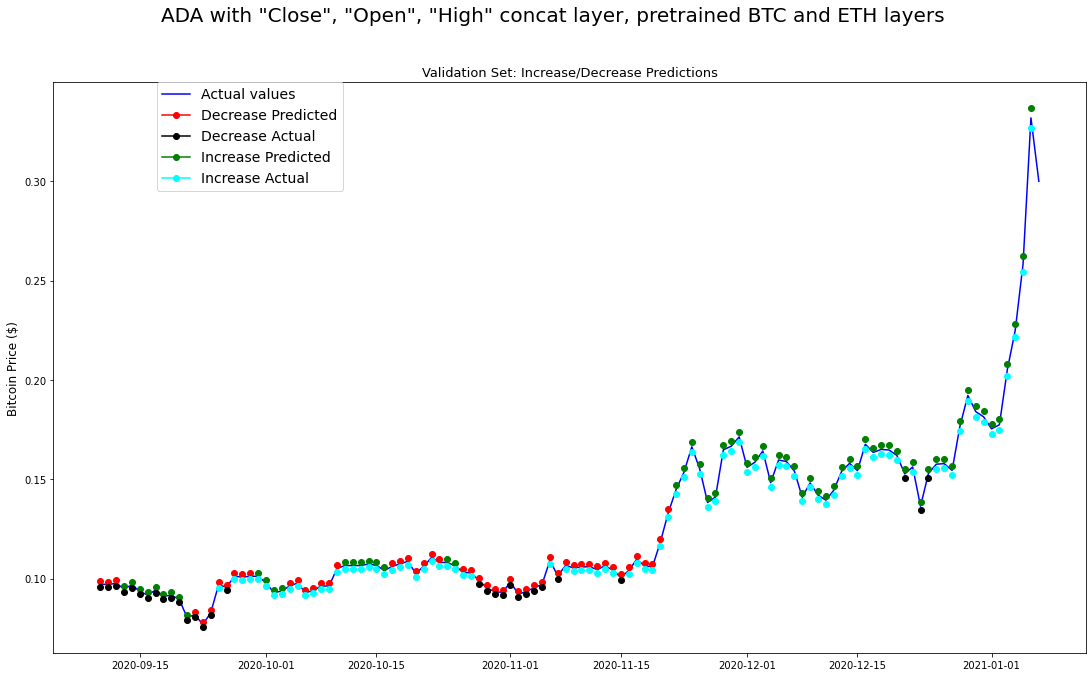

In [ ]:
plot_loss_and_val_loss(conc_model_hist, 'Binary crossentropy')
create_F1_macro_plot(conc_model_hist)
conc_preds = conc_model.predict({'BTC':dict_LSTM_val_in['BTC'], 'ETH':dict_LSTM_val_in['ETH'], 'ADA':dict_LSTM_val_in['ADA']})[:-pred_range][::pred_range]
create_conf_matrix(conc_preds, LSTM_rangd_val_out, 'ADA', 'BTC, ETH, ADA')
plot_actual_against_prediction_for_classification(ds_for_concatenate_with_transfer_lr['ADA'], conc_preds, pred_range, window_len, dict_LSTM_val_in['ADA'], LSTM_rangd_val_out, dict_val_set['ADA'], splt_date_train, splt_date_val, 'ADA_Close', 'ADA with "Close", "Open", "High" concat layer, pretrained BTC and ETH layers')

<p> As we can see the performance of the concatenated architecture using transfer learning, increases f1 macro value from 55% (using just a sequential model with ADA data only) to 79%. The predicted results are better than before, however our model is still biased to the increase class. </p>
<p>Now, we should perform predictions with test data both for sequential and concatenated models to validate the raise of F1 macro score.</p>

In [95]:
#Get predictions for test set using sequential model trained just ADA data and print f1 macro score 
ada_test_preds = ada_model.predict(ada_LSTM_test_in)[:-pred_range][::pred_range]
metric_f1 = tfa.metrics.F1Score(average='macro', num_classes=2*pred_range)
metric_f1.update_state(ada_LSTM_rangd_test_out[:-pred_range][::pred_range], ada_test_preds[:-1])
result = metric_f1.result()
result.numpy()

0.4407583

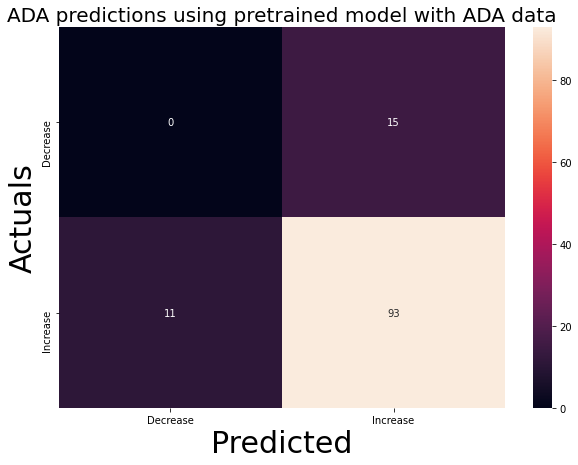

In [96]:
create_conf_matrix(ada_test_preds, ada_LSTM_rangd_test_out, 'ADA', 'ADA')

In [79]:
#Get predictions for test set using sequential model trained just ADA data and print f1 macro score 
ada_conc_preds = conc_model.predict({'BTC':dict_LSTM_test_in['BTC'], 'ETH':dict_LSTM_test_in['ETH'], 'ADA':dict_LSTM_test_in['ADA']})[:-pred_range][::pred_range]
metric_f1 = tfa.metrics.F1Score(average='macro', num_classes=2*pred_range)
metric_f1.update_state(LSTM_rangd_test_out[:-pred_range][::pred_range], ada_conc_preds[:-1])
result = metric_f1.result()
result.numpy()

0.47058827

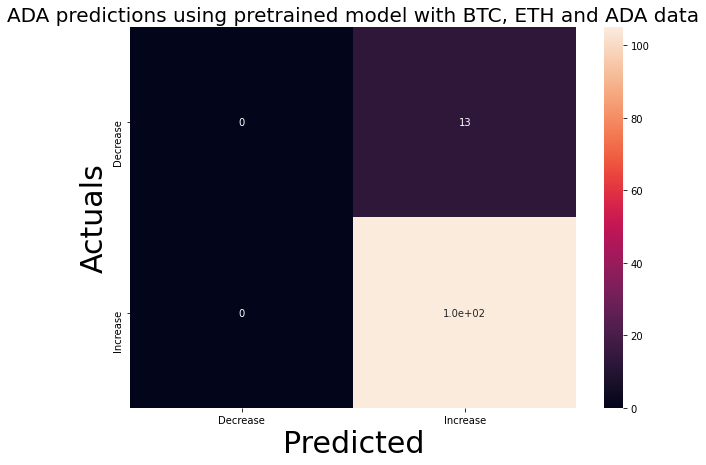

In [80]:
create_conf_matrix(ada_conc_preds, LSTM_rangd_test_out, 'ADA', 'BTC, ETH and ADA')

Unfortunately, the predictions for test set do not allow us to generalize the above assumption. Exploiting concatenated architecture, F1 macro scores are now almost the same (44% and 47%) in contrast with the validation set predictions results. Thus, the concept idea of tranfering the information acquired from different cryptocurrencies does not work as expected. 

Lastly, we will try to further train with ADA data the model which was initially trained with BTC in order to figured out whether the initialization of network weights trained with BTC data has a beneficial effect.  

In [86]:
#Because tf.keras.models.clone_model() does not work properly for our case, we will save the weights of the model trained with BTC data, 
#then we will build and train (training is not need it but we have define it in the same function) a new similar model and load the stored weights.
#Save the weights
btc_model.save_weights('./my_checkpoint')

In [89]:
loaded_btc_model, _ = build_and_train_model(btc_LSTM_tr_in, btc_LSTM_rangd_train_out, 
                                                               pred_range*2, btc_LSTM_val_in,
                                                               btc_LSTM_rangd_val_out, GRU_neurons=20, 
                                                               first_dense_neurons=256, first_dropout=0.4, 
                                                               second_dense_neurons=128, second_dropout=0.25, 
                                                               prd_range=pred_range, epochs=500, batch_size=64,
                                                               early_stop_patience=10)

In [92]:
loaded_btc_model.load_weights('./my_checkpoint')

In [94]:
#Firther train with ADA historical data
further_train_model_hist = loaded_btc_model.fit(ada_LSTM_tr_in[:-pred_range], ada_LSTM_rangd_train_out,
                                       validation_data=(ada_LSTM_val_in[:-pred_range], ada_LSTM_rangd_val_out), 
                                           callbacks=[stop_early],
                                        epochs=500, batch_size=64, verbose=0, shuffle=True, workers=8)

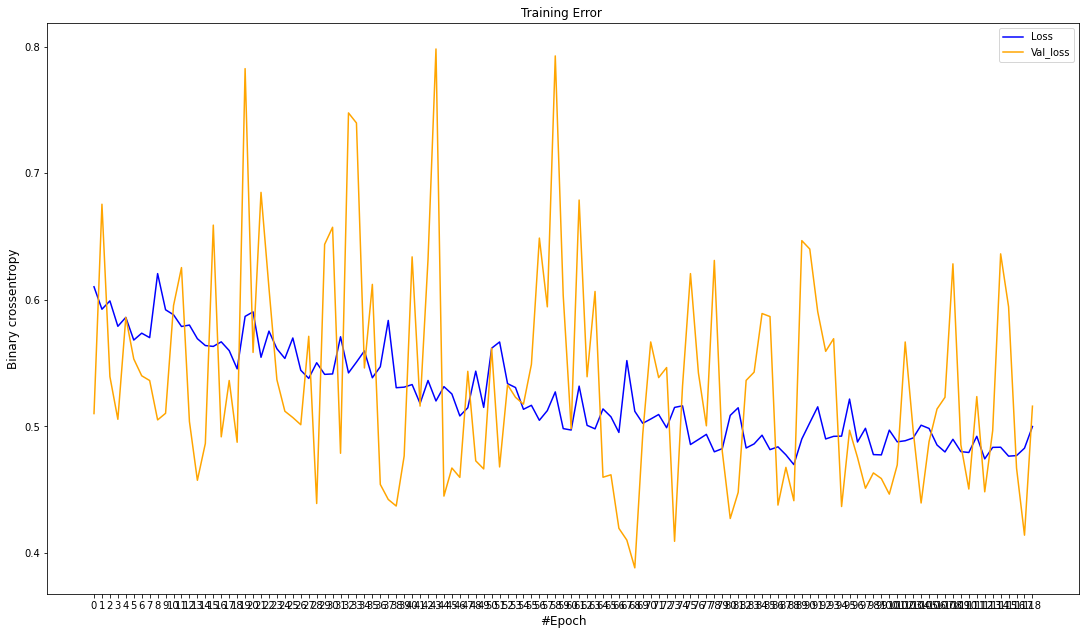

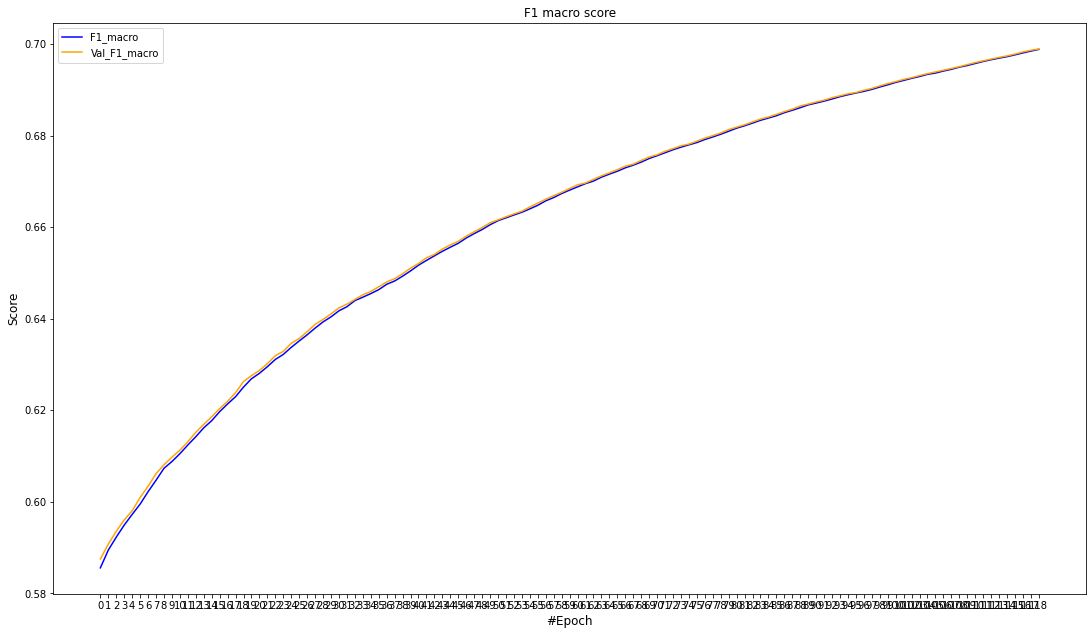

In [99]:
plot_loss_and_val_loss(further_train_model_hist, 'Binary crossentropy')
create_F1_macro_plot(further_train_model_hist)

In [100]:
#Get predictions for test set using sequential model trained just ADA data and print f1 macro score 
ada_test_preds = loaded_btc_model.predict(ada_LSTM_test_in)[:-pred_range][::pred_range]
metric_f1 = tfa.metrics.F1Score(average='macro', num_classes=2*pred_range)
metric_f1.update_state(ada_LSTM_rangd_test_out[:-pred_range][::pred_range], ada_test_preds[:-1])
result = metric_f1.result()
result.numpy()

0.4460094

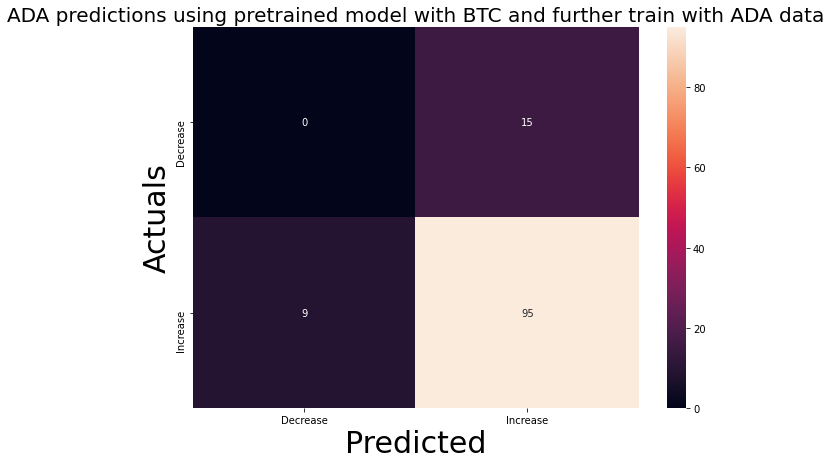

In [101]:
create_conf_matrix(ada_test_preds, ada_LSTM_rangd_test_out, 'ADA', 'BTC and further train with ADA')

In this case, F1 score in validation set achieves a high value (70% based on F1 plot) in relation with the model trained with only ADA data. Nonetheless, predictions with the test set led to low value of F1 score, almost identical with all preceding trials. Also, there is still the bias towards the class 'Increase' which we did not achieve to eliminate. 

Before this work is closed, it should be stated that we investigated the stationarity of BTC market information data as it is suggested in paper [3]. The stationarity property ensures the suitability of a time-series for fitting a Neural Network model. To examine it we used *Augmented Dickey-Fuller* test which can provide us the crucial information about how much significant autocorrelation exists in this specific series. The results are presented below.

In [103]:
from statsmodels.tsa.stattools import adfuller

print("ADF for original BTC timeseries:")
X = btc_ds['BTC_Close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for original BTC timeseries:
ADF Statistic: 0.923242
p-value: 0.993386
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


*p-value* (0.99) indicates that indeed there is strong autocorrelation in Bitcoin time-series. For this reason, we applied the proposed tranformation ((y^l)-1)/l, where l=-3 and *y* is the time-series value and performed the test again. 

In [107]:
print("ADF for ((y^l)-1)/l, where l=-3, transform BTC timeseries")
X = (((btc_ds['BTC_Close'].values)**(-3))-1)/-3

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for ((y^l)-1)/l, where l=-3, transform BTC timeseries
ADF Statistic: -2.512068
p-value: 0.112566
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Even with this transformation, the *p-value* is greater than 0.05, which means that we cannot reject null hypothesis of autocorrelation existance. However, we tried to feed the data transfored in this way to the model. The outocomes did not significantly differ from these presented until now.

As a result, we concluded that the cryptocurrency price forecasting is an extreme complex problem where such models (RNN layers followed fully connected layers) do not have the ability to catch the patterns of this kind of time-series which rapidly and completelly changes through the time. This is also can be verified by the low results achieved at the experiments of the reported literature.   

By examining more recent articles, we decided to set as future work the investigation of models based on *Transformers* architecture which seems to lead to superior performance even though at the most intricate sequential problems.  

<h1>References</h1>


1. I. E. Livieris, N. Kiriakidou, S. Stovroyiannisn and P. Pintelas, "An Advanced CNN-LSTM Model for Cryptocurrency Forecasting," *Electronics*, vol. 10, no. 3, pp. 287, Jan. 2021, doi: 10.3390/electronics10030287. 
2. E. Christoforou, Z. I. Emiris and A. Florakis, "Neural Networks for Cryptocurrency Evaluation and Price Fluctuation Forecasting," in *Mathematical Research for Blockchain Economy*, P. Pardalos, I. Kotsireas, Y. Guo, W. Knottenbelt, Eds. Springer, Cham, 2020, pp. 133-149, doi: 10.1007/978-3-030-37110-4_10.  
3. I. E. Livieris, S. Stavroyiannis, E. Pintelas and P. Pintelas, "A novel validation framework to enhance deep learning models in time-series forecasting," *Neural Computing and Applications*, vol. 32, pp. 17149–17167, 08 Jul. 2020, doi: 10.1007/s00521-020-05169-y. 